In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline


In [2]:
#Read in and make a list of calibration images
images = glob.glob('C:\carnd-term1\CarND-Advanced-Lane-Lines\camera_cal\calibration*.jpg')

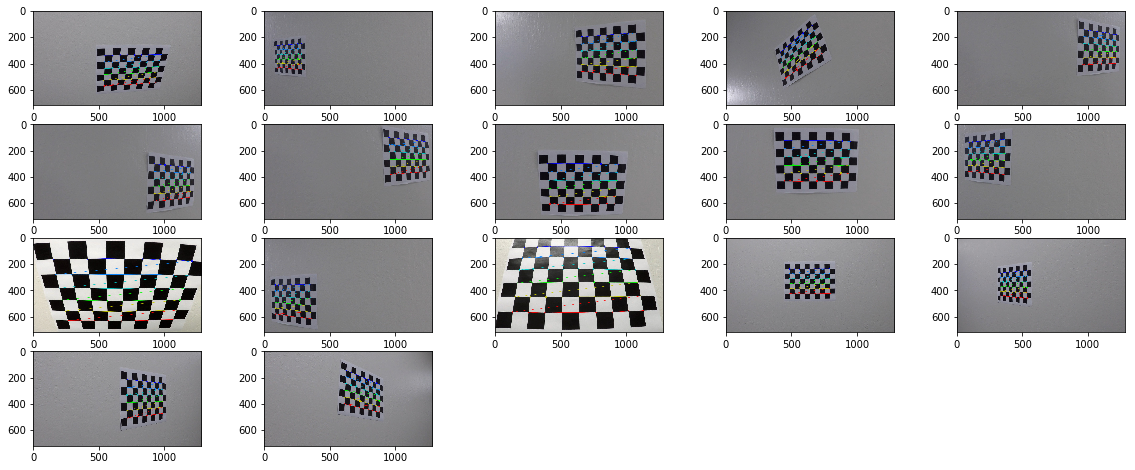

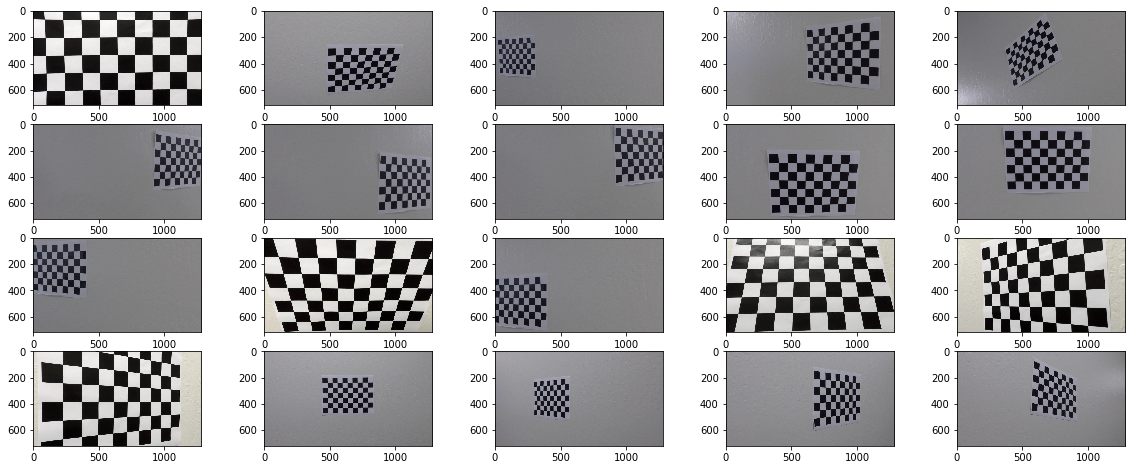

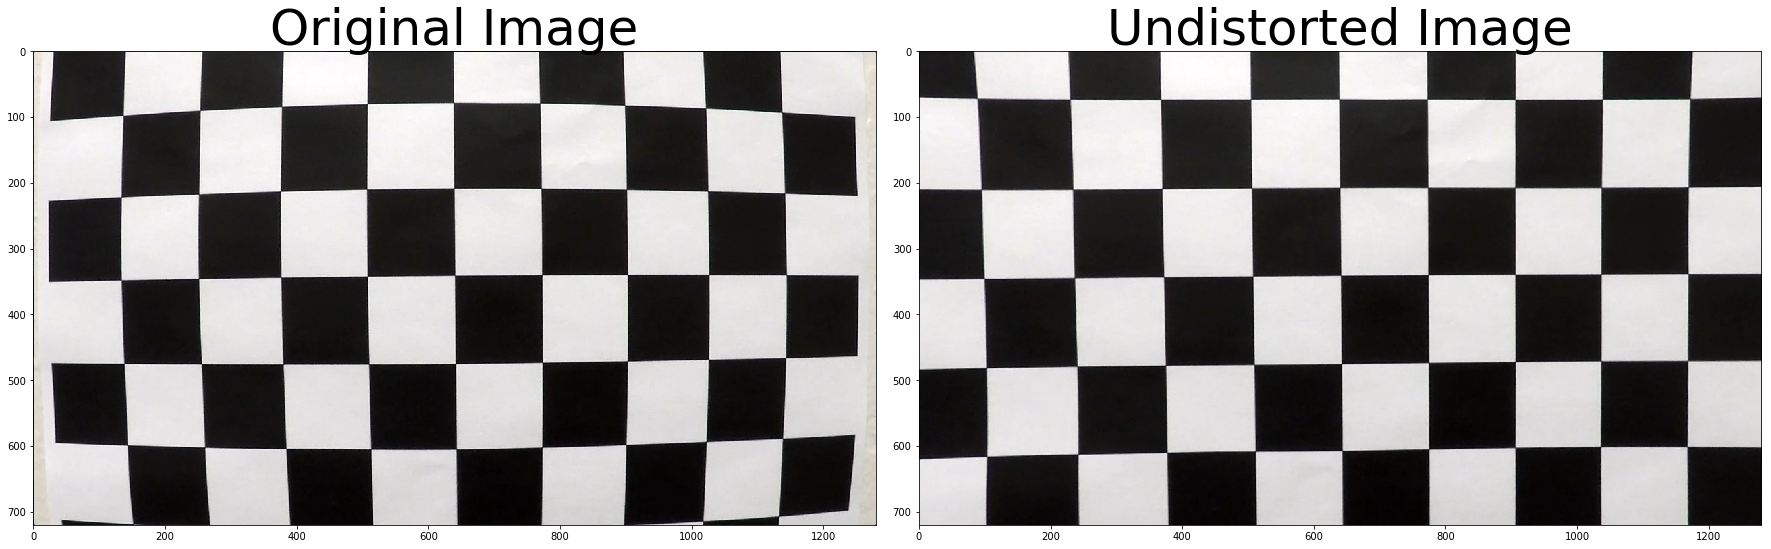

In [3]:
# Arrays to store object points and image points from all the images

objpoints = [] # 3D points in the real world space
imgpoints = [] # 2d points in image plane

# Prepare object points, like (0,0,0), (1,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

#Plot images identifying Chessboard corners
plt.subplots(figsize=(20, 8))
i = 0
for fname in images:
    # Read in each image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.subplot(4,5, 1 + i)
        i+=1
        plt.imshow(img)
        
# Calibrate Camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Undistort and plot images
plt.subplots(figsize=(20, 8))
i = 0
for fname in images:
    # Read in each image
    img = mpimg.imread(fname)
    
    # Undistort and print image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.subplot(4,5, 1 + i)
    i+=1
    plt.imshow(dst)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "C:\carnd-term1\CarND-Advanced-Lane-Lines\camera_cal\wide_dist_pickle.p", "wb" ) )

# Test undistortion on an image
img = mpimg.imread('C:\carnd-term1\CarND-Advanced-Lane-Lines\camera_cal\calibration1.jpg')


dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
def load_calibration(path):
    #Load image calibration
    calibration_file = path

    with open(calibration_file, mode='rb') as f:
        calibration = pickle.load(f)
    
    mtx, dist = calibration['mtx'], calibration['dist']
    
    return mtx, dist

def undistort(img,mtx,dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

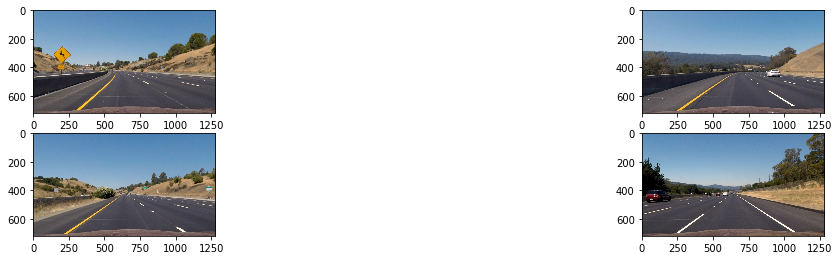

In [5]:
#Read in and make a list of road images
road_images = glob.glob('C:\\carnd-term1\\CarND-Advanced-Lane-Lines\\test_images\\test*.jpg')


# Undistort images
plt.subplots(figsize=(20, 20))
i = 0
for fname in road_images:
    # Read in each image
    img = cv2.imread(fname)
    
    # Undistort, save and print image
    mtx, dist = load_calibration('C:\carnd-term1\CarND-Advanced-Lane-Lines\camera_cal\wide_dist_pickle.p')
    dst = undistort(img, mtx, dist)
    plt.subplot(9,2, 1 + i)
    i+=1
    plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    cv2.imwrite('C:\\carnd-term1\\CarND-Advanced-Lane-Lines\\test_images\\undistort_test' + str(i) + '.jpg',dst)


In [6]:
#Define functions to apply differents sorts of thresholds on the images
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    grad_binary = sxbinary
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 2) Calculate the magnitude 
    sobelxy = (sobelx ** 2 + sobely ** 2) ** 0.5
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    # 4) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    mag_binary = sxbinary
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 2) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direct_sobel = np.arctan2(abs_sobely, abs_sobelx)
    # 4) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(direct_sobel)
    sxbinary[(direct_sobel >= thresh[0]) & (direct_sobel <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    dir_binary = sxbinary # Remove this line
    return dir_binary

def hsv_thres_w(hsv):
    # Apply the following steps to img
    # 1) Init output image
    hsv_binary_w = np.zeros_like(hsv[:,:,0])
    # 2) Define thresholds to identify white color on HSV colorspace
    lower = np.array([0, 0, 200], dtype = "uint8")
    upper = np.array([255, 40, 255], dtype = "uint8")
    # 3) Apply mask
    mask = cv2.inRange(hsv, lower, upper)
    # 4) Create binary output with the found points
    if (cv2.findNonZero(mask) is not None):
  
        hsv_binary_w[cv2.findNonZero(mask)[:,0,1],cv2.findNonZero(mask)[:,0,0]] = 1
    
    return hsv_binary_w

def lab_thres_y(lab):
    # Apply the following steps to img
    # 1) Init output image
    lab_binary_y = np.zeros_like(lab[:,:,0])
    # 2) Define thresholds to identify yellow color on LAB colorspace
    lower = np.array([0, 0, 150], dtype = "uint8")
    upper = np.array([255, 255, 255], dtype = "uint8")
    # 3) Apply mask
    mask = cv2.inRange(lab, lower, upper)
    # 4) Create binary output with the found points
    if (cv2.findNonZero(mask) is not None):

            lab_binary_y[cv2.findNonZero(mask)[:,0,1],cv2.findNonZero(mask)[:,0,0]] = 1

    return lab_binary_y


In [7]:
# Color and Gradient thresholding function
def color_gradient_threshold(img, s_thresh=(175, 255), sx_thresh=(40, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.uint8)
    v_channel = hsv[:,:,2]
    # Apply Local Histogram Equalization to the V channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    v_channel_eq = clahe.apply(v_channel)
    # Create new equalized image
    hsv_eq = np.zeros_like(hsv)
    hsv_eq[:,:,0] = hsv[:,:,0]
    hsv_eq[:,:,1] = hsv[:,:,1]
    hsv_eq[:,:,2] = v_channel_eq
    # Convert equalized HSV image to LAB colorspace
    img_eq = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB).astype(np.uint8)
    lab = cv2.cvtColor(img_eq, cv2.COLOR_RGB2Lab).astype(np.uint8)
    
    # Threshold HSV image for "white pixels"
    hsv_binary_w = hsv_thres_w(hsv_eq)
    
    # Threshold LAB image for "yellow pixels"
    lab_binary_y = lab_thres_y(lab)

    # Stack each channel
    color_binary = np.dstack(( hsv_binary_w, lab_binary_y, np.zeros_like(v_channel))).astype(float)
    
    # Combine the two binary thresholds
    combined_binary = np.uint8(np.zeros_like(v_channel))
    combined_binary[(hsv_binary_w == 1) | (lab_binary_y == 1)] = 255

    return color_binary, combined_binary


# Define warping source and destination 
src = np.float32([[258,682],[575,464],[707,464],[1049,682]])
dst = np.float32([[450,720],[450,0],[830,0],[830,720]]) 

# Image warping function
def warp_image(img,src,dst):
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Use cv2.warpPerspective() to warp your image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped


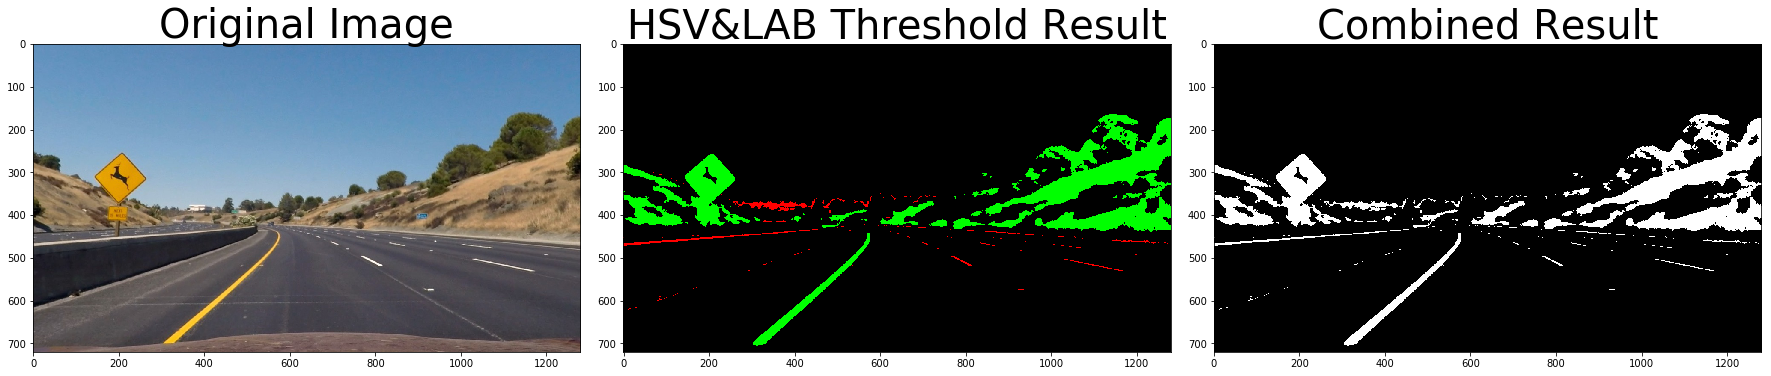

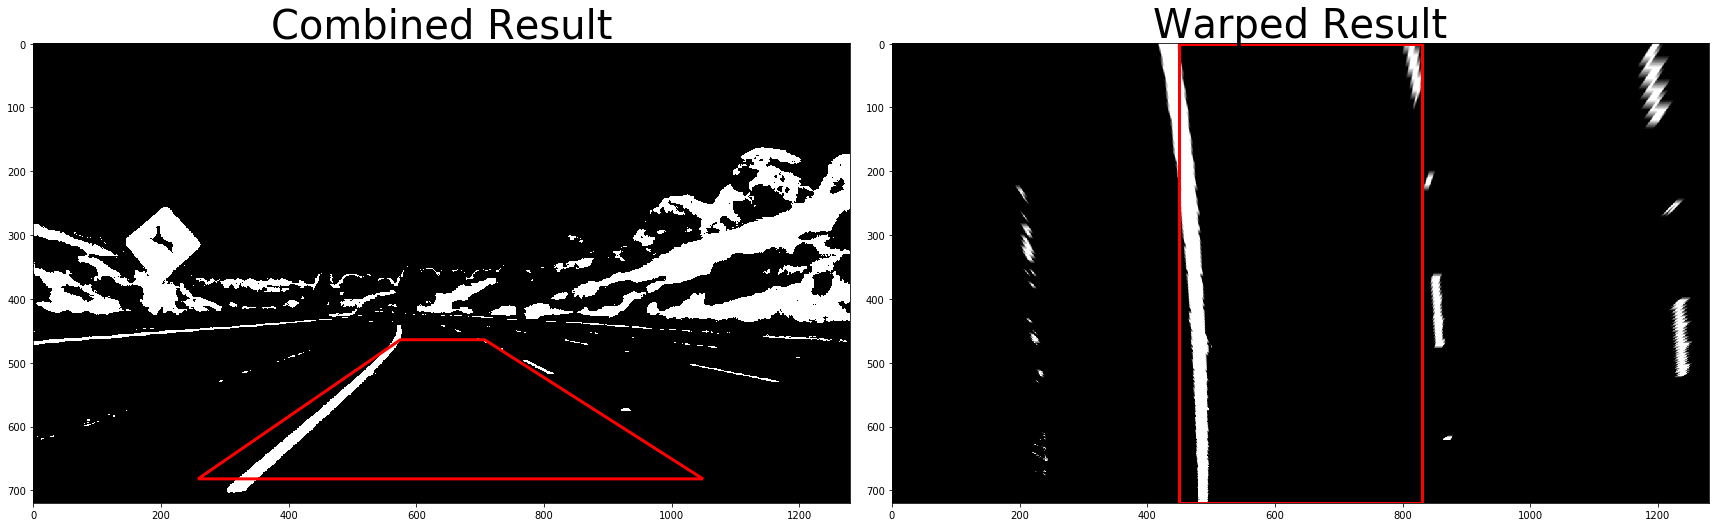

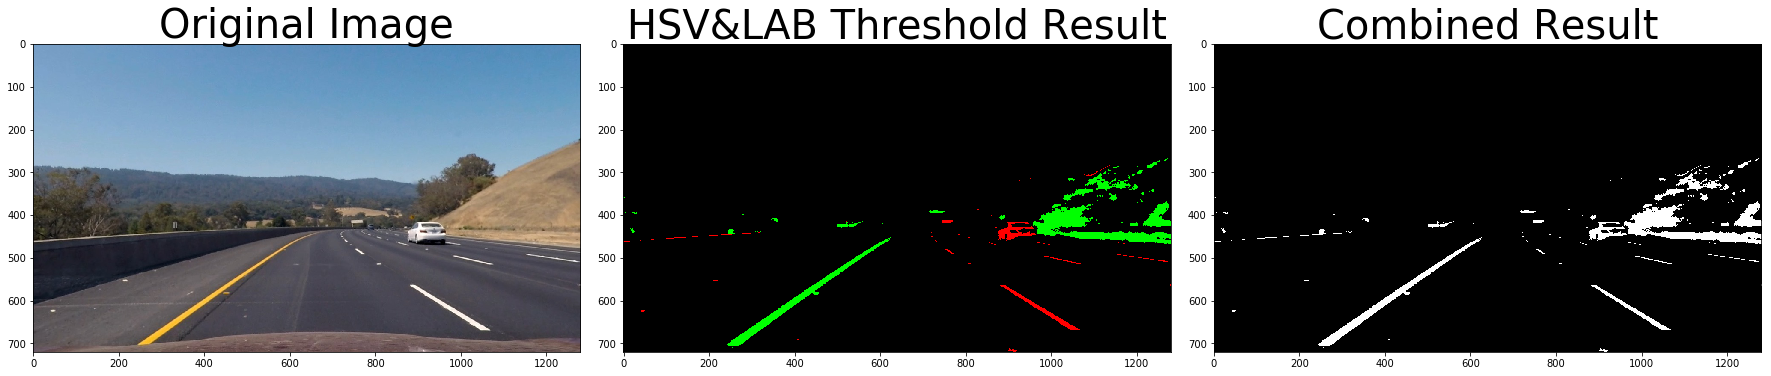

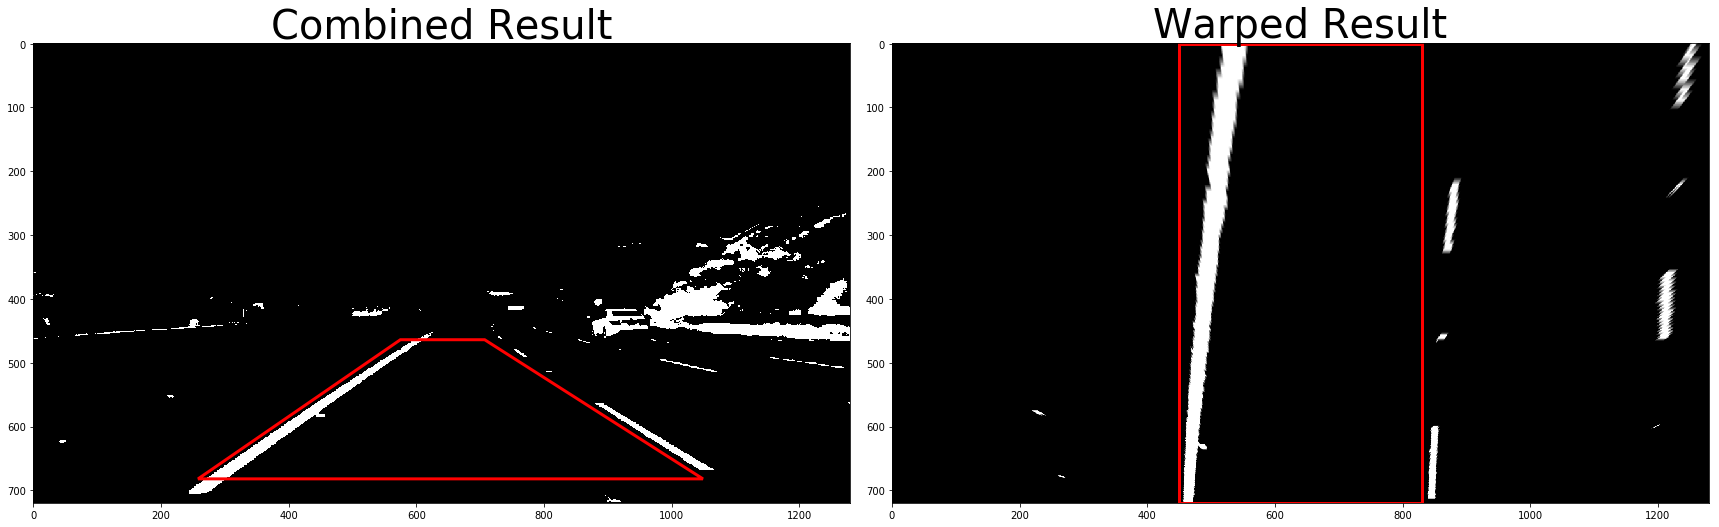

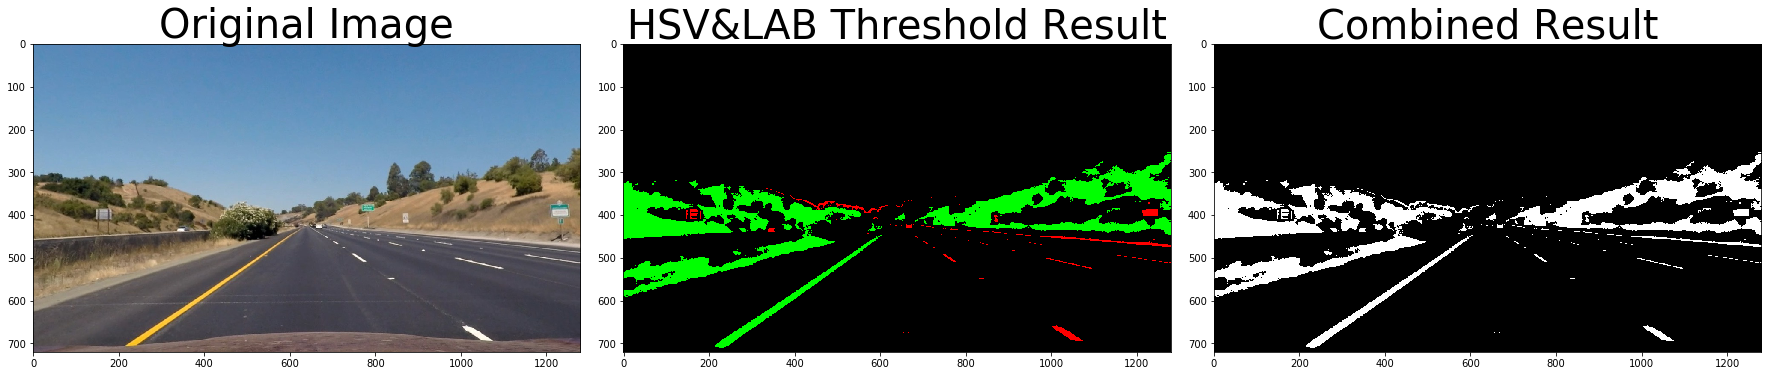

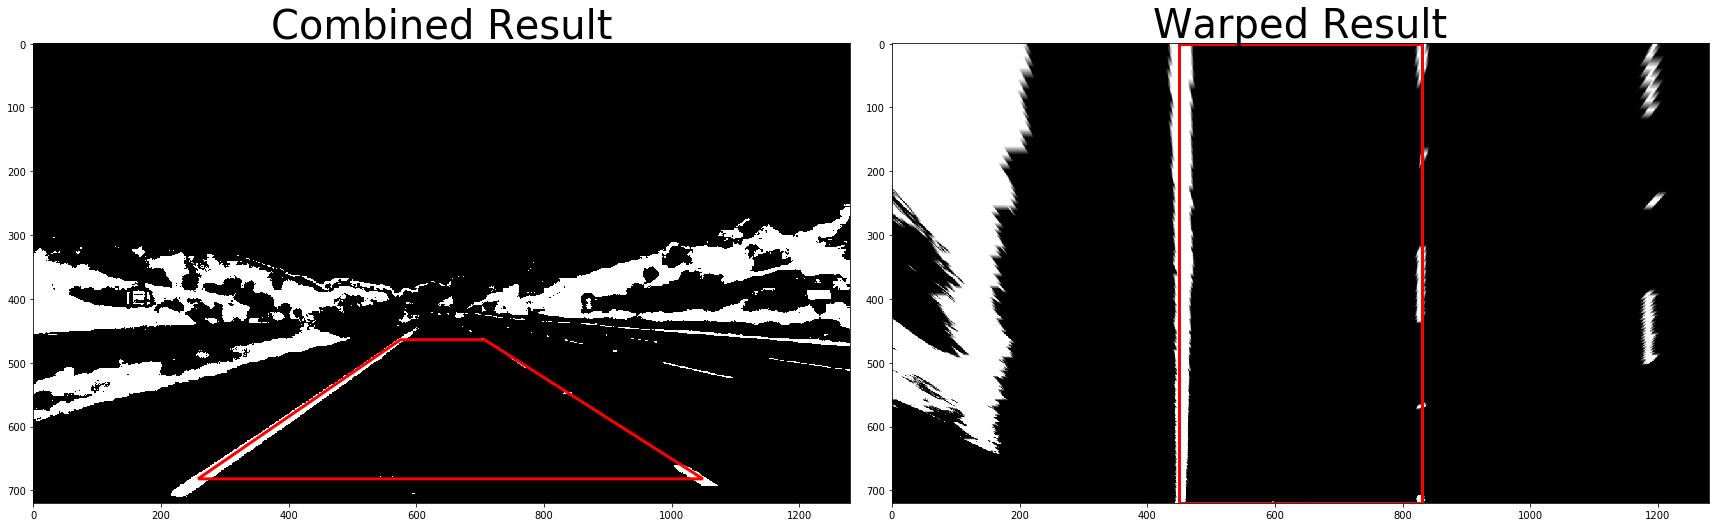

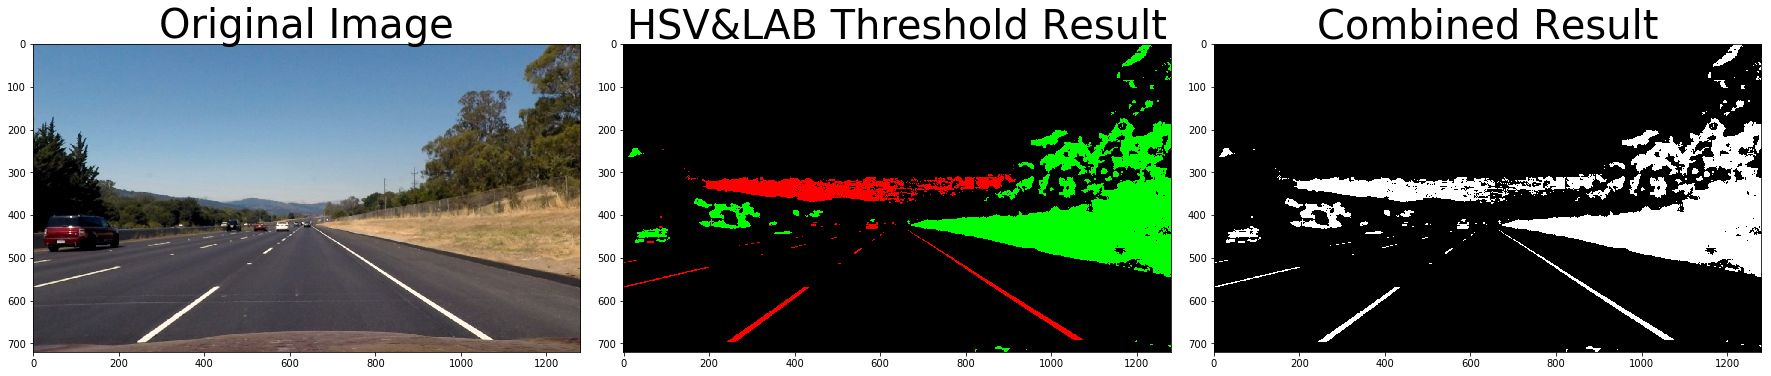

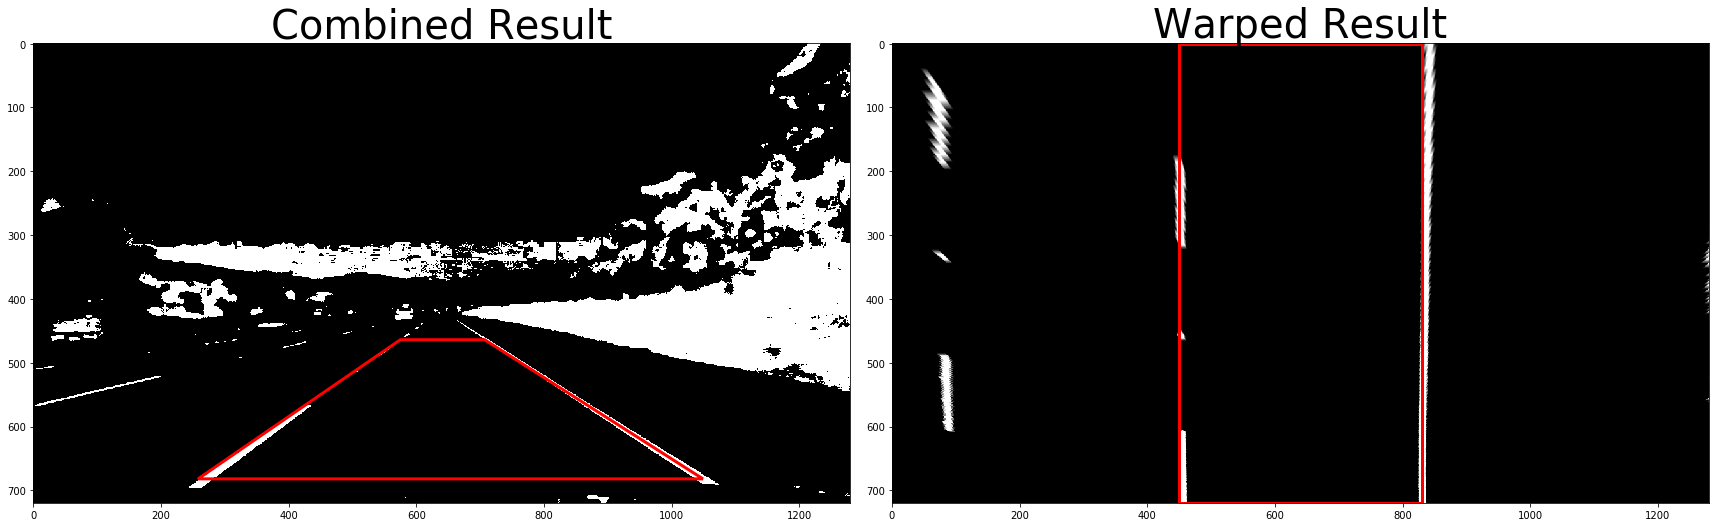

In [8]:
# Read in and make a list of undistorted road images
undistorted_road_images = glob.glob('C:\\carnd-term1\\CarND-Advanced-Lane-Lines\\test_images\\undistort_test*.jpg')

# Loop through the images
i=0
for fname in undistorted_road_images:
    
    # Apply thresholding and save the result
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    result, result_combined = color_gradient_threshold(img)
    i+=1
    cv2.imwrite('C:\\carnd-term1\\CarND-Advanced-Lane-Lines\\test_images\\color_grad_test' + str(i) + '.jpg',result_combined)

    # Plot the result
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result)
    ax2.set_title('HSV&LAB Threshold Result', fontsize=40)
    
    ax3.imshow(result_combined, cmap='gray')
    ax3.set_title('Combined Result', fontsize=40)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Warp result image
    warped = warp_image(result_combined,src,dst)
    cv2.imwrite('C:\\carnd-term1\\CarND-Advanced-Lane-Lines\\test_images\\warped_test' + str(i) + '.jpg',warped)

    f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(24, 9))
    f2.tight_layout()
    
    # Plot the result
    ax4.imshow(result_combined, cmap='gray')
    ax4.set_title('Combined Result', fontsize=40)
    ax4.add_patch(plt.Polygon(src,fill=None,ec = 'r',lw = 3))

    ax5.imshow(warped, cmap='gray')
    ax5.set_title('Warped Result', fontsize=40)
    ax5.add_patch(plt.Polygon(dst,fill=None,ec = 'r',lw = 3))

In [9]:
# Draw window mask function
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output


# Function to find windows centroids
def find_window_centroids(warped, window_width, window_height, margin):

    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        
        if (np.all((conv_signal[l_min_index:l_max_index])==0)) == False:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset

        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        if (np.all((conv_signal[r_min_index:r_max_index])==0)) == False:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

# Function to mask the thresholded image based on fou dwindows centroids or previous identified lines
def mask_lines(warped, window_centroids = None, previous_fit = None, window_width = 50,window_height = 80, margin = 50):
        
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    # If we have any window centers
    if window_centroids != None:

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        # Add both left and right window pixels together
        template = np.array(r_points+l_points,np.uint8)
        # Add left window pixels together
        template_l = np.array(l_points,np.uint8)
        # Add right window pixels together
        template_r = np.array(r_points,np.uint8)
        # Create a zero color channel
        zero_channel = np.zeros_like(template) 
        # Make left and right window pixels green and blue respectively
        template_3channels = np.array(cv2.merge((zero_channel,template_l,template_r)),np.uint8)
        # Making the original road pixels 3 color channels
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        # Overlay the orignal road image with window results
        windows_warped = cv2.addWeighted(warpage, 1, template_3channels, 0.5, 0.0) 
        masked_warped = cv2.bitwise_and(template, warped)
        # Retrieve found pixels for each line
        pixels_left = cv2.findNonZero(cv2.bitwise_and(warped, template_l))
        pixels_right = cv2.findNonZero(cv2.bitwise_and(warped, template_r))
        
    # If we have information from previous fitted lines
    elif previous_fit != None:
        
        # Separate previous fit into both lines
        left_fit = previous_fit[0]
        right_fit = previous_fit[1]
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-int(window_width), ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+int(window_width), ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-int(window_width), ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+int(window_width), ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # Draw the results
        # Draw search window for each of the lines
        window_img_l = np.zeros_like(warped)
        window_img_r = np.zeros_like(warped)
        l_mask = cv2.fillPoly(window_img_l, np.int_([left_line_pts]), (255,255,255))
        r_mask = cv2.fillPoly(window_img_r, np.int_([right_line_pts]), (255,255,255))
        template = np.array(l_mask+r_mask,np.uint8)
        template_l = np.array(l_mask,np.uint8) 
        template_r = np.array(r_mask,np.uint8)
        # Create a zero color channel
        zero_channel = np.zeros_like(template) # create a zero color channel
        # Make left and right window pixels green and blue respectively
        template_3channels = np.array(cv2.merge((zero_channel,template_l,template_r)),np.uint8) 
        # Making the original road pixels 3 color channels
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        # Overlay the orignal road image with window results
        windows_warped = cv2.addWeighted(warpage, 1, template_3channels, 0.5, 0.0) 
        masked_warped = cv2.bitwise_and(warped, template)
        pixels_left = cv2.findNonZero(cv2.bitwise_and(warped, template_l))
        pixels_right = cv2.findNonZero(cv2.bitwise_and(warped, template_r))
        
    # If no window centers found and not previous fit information is present, just display orginal road image
    else:
        windows_warped = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        masked_warped = warped
        pixels_left = None
        pixels_right = None

    
    return masked_warped, windows_warped, pixels_left, pixels_right

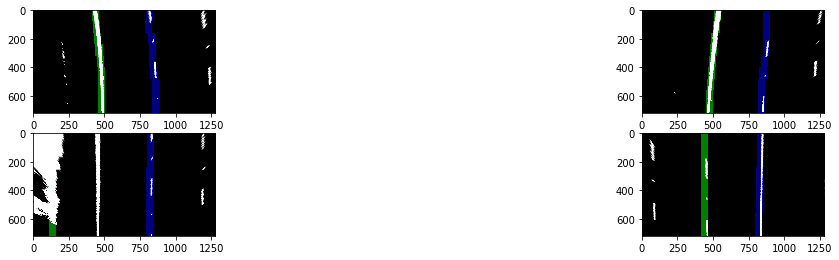

In [10]:
# Window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 35 # How much to slide left and right for searching
previous_fit = None

#Loop through warped images
warped_images = glob.glob('C:\\carnd-term1\\CarND-Advanced-Lane-Lines\\test_images\\warped_test*.jpg')
plt.subplots(figsize=(20, 20))
i = 0
for fname in warped_images:
    
    # Read in a warped thresholded image
    warped = mpimg.imread(fname)
    # Find window centroids
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    # Mask Lines
    masked_warped, windows_warped, pixels_left, pixels_right =  mask_lines(warped, window_centroids,previous_fit, window_width,window_height, margin)
    
    # Display the final results
    plt.subplot(9,2, 1 + i)
    i+=1
    plt.imshow(windows_warped)
    cv2.imwrite('C:\\carnd-term1\\CarND-Advanced-Lane-Lines\\test_images\\warped_windows_test' + str(i) + '.jpg',windows_warped)
    cv2.imwrite('C:\\carnd-term1\\CarND-Advanced-Lane-Lines\\test_images\\warped_masked_test' + str(i) + '.jpg',masked_warped)
    

In [11]:
# Function to fit lines based on pixels found
def fit_lines(masked_warped,pixels_left, pixels_right):
    
    # If no pixels are given return default values
    if pixels_left == None or pixels_right == None:
            left_fit = [np.array([False])]
            right_fit = [np.array([False])]
            left_fit_cr = None
            right_fit_cr = None
            left_curverad = None
            right_curverad = None
            pixels_left = None
            pixels_right = None
            offset = None
            left_line_x = None
            right_line_x = None
    else:
        # Separate pixels coordinates into a usable format
        lefty = pixels_left[:,0,1]
        righty = pixels_right[:,0,1]
        
        leftx = pixels_left[:,0,0]
        rightx = pixels_right[:,0,0]
        # Use np.polyfit to fit lines to the given pixels
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 21.95/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/380 # meters per pixel in x dimension
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the radio of curvature
        y_eval = masked_warped.shape[0]
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / (2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / (2*right_fit_cr[0])
    
        #Calculate x coordinate for start and end of both lines, also the offset from lane center  
        left_line_x = [left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2], left_fit[2]]
        right_line_x = [right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2], right_fit[2]]
        lane_center = (left_line_x[0] + right_line_x[1])/2
        offset = (lane_center - masked_warped.shape[1]/2)*xm_per_pix
        
    return left_fit, right_fit , left_fit_cr,right_fit_cr, left_curverad, right_curverad, offset, left_line_x, right_line_x


In [12]:
# Function to create and image representing the fitted lines
def fitted_lines_image(masked_warped,left_fit, right_fit, pixels_left, pixels_right):
    
    # Initialize output image as a 3-color image
    lines_img = np.zeros_like(masked_warped)
    lines_img = np.array(cv2.merge((lines_img,lines_img,lines_img)),np.uint8)
    # Add left and right pixels to the image as red and blue respectively
    for pixel in pixels_left:
        lines_img[pixel[0,1],pixel[0,0],0] = 255 
    for pixel in pixels_right:
        lines_img[pixel[0,1],pixel[0,0],2] = 255
    
    # Plot both lines
    ploty = np.linspace(0, int(masked_warped.shape[0])-1, num=int(masked_warped.shape[0]))# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_pixels = np.stack((left_fitx,ploty),axis=1)
    right_fit_pixels = np.stack((right_fitx,ploty),axis=1)  
    
    # Add line pixels to the image as green pixels, checking that the calculated values are inside the image
    for pixel in left_fit_pixels:
        if (pixel[0] <= 1279) and (pixel[0] >= 0):  
            lines_img[pixel[1],pixel[0]] = (0,255,0) 
    for pixel in right_fit_pixels:
        if (pixel[0] <= 1279) and (pixel[0] >= 0):
            lines_img[pixel[1],pixel[0]] = (0,255,0)
        
    return lines_img
        

C:\ProgramData\Miniconda3\envs\carnd-term1-gpu\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\ProgramData\Miniconda3\envs\carnd-term1-gpu\lib\site-packages\ipykernel\__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\ProgramData\Miniconda3\envs\carnd-term1-gpu\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


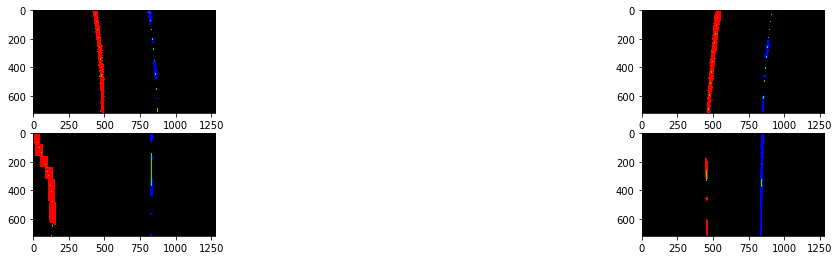

In [13]:
#Loop through warped images
warped_images = glob.glob('C:\\carnd-term1\\CarND-Advanced-Lane-Lines\\test_images\\warped_test*.jpg')
plt.subplots(figsize=(20, 20))
i = 0
for fname in warped_images:   
    # Read in a warped thresholded image
    warped = mpimg.imread(fname)
    # Find window centroids
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    # Mask Lines
    masked_warped, windows_warped, pixels_left, pixels_right =  mask_lines(warped, window_centroids,previous_fit, window_width,window_height, margin)
    # Fit Lines
    left_fit, right_fit , left_fit_cr,right_fit_cr, left_curverad, right_curverad, offset, left_line_x, right_line_x = fit_lines(masked_warped, pixels_left, pixels_right)
    # Create image with fitted lines
    lines_img = fitted_lines_image(masked_warped,left_fit, right_fit, pixels_left, pixels_right)
    # Plot results
    plt.subplot(9,2, 1 + i)
    i+=1
    plt.imshow(lines_img)

In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        self.detected_counter = 0
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # fit values of the last n fits of the line
        self.recent_fits = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = [np.array([False])]  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # difference in fit coefficients between last and new fits (percent)
        self.diffsper = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None

In [15]:
# Function to check if the fitted lines are plausible
def sanity_check(left_fit_cr,right_fit_cr, left_curverad, right_curverad, offset, left_line_x, right_line_x):
    result = True
    # Calculate width close to the car
    width_0 = (right_line_x[0] - left_line_x[0])*3.7/380
    # Calculate width far from the car
    width_1 = (right_line_x[1] - left_line_x[1])*3.7/380
    # Calculate curvature and curvature ratio between the both lines
    curvature_ratio_abs = abs(left_curverad/right_curverad)
    curvature_ratio = left_curverad/right_curverad
    curvature = (left_curverad+right_curverad)/2
    # Check for width
    if width_0 > 4.4 or width_0 < 2.8:
        result = False
        print("Sanity Check Failed due to width at the start")
        print(width_0)
    if width_1 >= width_0*1.08 or width_1 < 1.8:
        result = False
        print("Sanity Check Failed due to width at the end")
        print(width_1)
    # Check for curvature ratio
    if curvature_ratio_abs > 6 or curvature_ratio_abs < 0.166:
        print("Sanity Check Failed due to curvature")
        print(curvature_ratio)
        result = False
    return result

In [16]:
# Image processing pipeline
def process_image(img):
    # Load camera calibration
    mtx, dist = load_calibration('C:\carnd-term1\CarND-Advanced-Lane-Lines\camera_cal\wide_dist_pickle.p')
    # Undistort input image
    undist = undistort(img, mtx, dist)
    # Apply thresholding to the image
    result, result_combined = color_gradient_threshold(undist)
    # Get perspective transform
    src = np.float32([[258,682],[575,464],[707,464],[1049,682]])
    dst = np.float32([[450,720],[450,0],[830,0],[830,720]]) 
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(result_combined, M, img_size, flags=cv2.INTER_LINEAR)
    orig_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    # Search window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 35 # How much to slide left and right for searching
    # Get previous fit
    previous_fit = np.array([left_line.current_fit, right_line.current_fit])
    # Get previous best fit
    best_fit = np.array([left_line.best_fit, right_line.best_fit])
    # Initialize image
    lines_img = np.zeros_like(img)
    
    # In there is no previous fit or the non-detected counter achieved it's limit,
    # calculate windows centroids
    if (previous_fit == False).any() or left_line.detected_counter >= 10 or right_line.detected_counter >= 10:
        print('Calculating Centroids')
        window_centroids = find_window_centroids(warped, window_width, window_height, margin = margin)
    else:
        window_centroids = None        
    
    # Mask lines based on previous fit or calculated windows centroids
    masked_warped, windows_warped, pixels_left, pixels_right =  mask_lines(warped, window_centroids,best_fit, window_width,window_height, margin)
    
    # If no pixels were found for any of the lines, reset both and abort further calculations
    if pixels_left == None:
        left_line.detected = False
        left_line.detected_counter += 1
        left_curverad = None
        right_curverad = None
        print('No Left Pixels')
    elif pixels_right == None:
        right_line.detected = False
        right_line.detected_counter += 1
        right_curverad = None
        left_curverad = None
        print('No Right Pixels')
    else:
        # Separate found pixels coordinates
        left_line.allx = pixels_left[:,0,0]
        left_line.ally = pixels_left[:,0,1]
        right_line.allx = pixels_right[:,0,0]
        right_line.ally = pixels_right[:,0,1]
        # Fit lines
        left_fit, right_fit , left_fit_cr,right_fit_cr, left_curverad, right_curverad, offset, left_line_x, right_line_x = fit_lines(masked_warped,pixels_left, pixels_right)
        # Create image with fitted lines
        lines_img = fitted_lines_image(masked_warped,left_fit, right_fit, pixels_left, pixels_right)
        # Check for line plausability
        sanity_check_result = sanity_check(left_fit_cr,right_fit_cr, left_curverad, right_curverad, offset, left_line_x, right_line_x)
        # If check fails add 1 to the non-detected counter and abort further calculations
        if sanity_check_result == False:
            left_line.detected = False
            left_line.detected_counter += 1
            right_line.detected = False
            right_line.detected_counter += 1
        else:
            # Line was detected
            left_line.detected = True 
            right_line.detected = True
            
            # If previous fit was given
            if window_centroids == None:
                # Append calulated x values
                left_line.recent_xfitted.append(left_line_x)
                left_line.recent_xfitted = left_line.recent_xfitted[-10:]
                right_line.recent_xfitted.append(right_line_x)
                right_line.recent_xfitted = right_line.recent_xfitted[-10:]
                
                # Calculate difference between best and current fit
                left_line.diffs = left_line.best_fit - left_fit
                left_line.diffsper = (left_line.diffs / left_line.best_fit) * 100
                right_line.diffs = right_line.best_fit - right_fit
                right_line.diffsper = (right_line.diffs / right_line.best_fit) * 100
                
                # Append calculated fit
                left_line.recent_fits = np.column_stack((left_line.recent_fits,left_fit))
                left_line.recent_fits = left_line.recent_fits[:,-10:]
                left_line.best_fit = [np.mean(left_line.recent_fits[0,:]),np.mean(left_line.recent_fits[1,:]),np.mean(left_line.recent_fits[2,:])]
                # As line was succesfully calculated, reset non-detected counter
                left_line.detected_counter = 0
                # Append calculated fit
                right_line.recent_fits = np.column_stack((right_line.recent_fits,right_fit))
                right_line.recent_fits = right_line.recent_fits[:,-10:]
                right_line.best_fit = [np.mean(right_line.recent_fits[0,:]),np.mean(right_line.recent_fits[1,:]),np.mean(right_line.recent_fits[2,:])] 
                # As line was succesfully calculated, reset non-detected counter
                right_line.detected_counter = 0
                
                # Average radius of curvature over the last 10 values
                left_line.radius_of_curvature = (left_line.radius_of_curvature*9 + left_curverad)/10 
                left_line.line_base_pos = (left_line.line_base_pos*9 + offset)/10 
                right_line.radius_of_curvature = (right_line.radius_of_curvature*9 + right_curverad)/10 
                right_line.line_base_pos = (right_line.line_base_pos*9 + offset)/10
                # Set current fit
                left_line.current_fit = left_fit
                right_line.current_fit = right_fit
            # If window centrois were calculated
            else:
                # Append calulated x values
                left_line.recent_xfitted = []
                left_line.recent_xfitted.append(left_line_x)
                right_line.recent_xfitted = []
                right_line.recent_xfitted.append(right_line_x)
                
                # Append calculated fit
                left_line.recent_fits = left_fit
                left_line.best_fit = left_fit
                # As line was succesfully calculated, reset non-detected counter
                left_line.detected_counter = 0
                # Append calculated fit
                right_line.recent_fits = right_fit
                right_line.best_fit = right_fit
                # As line was succesfully calculated, reset non-detected counter
                right_line.detected_counter = 0
                
                # Calculate difference between best and current fit
                left_line.diffs = left_line.best_fit - left_fit
                left_line.diffsper = (left_line.diffs / left_line.best_fit) * 100
                right_line.diffs = right_line.best_fit - right_fit
                right_line.diffsper = (right_line.diffs / right_line.best_fit) * 100
                
                #Set radius of curvature
                left_line.radius_of_curvature = left_curverad
                left_line.line_base_pos = offset
                right_line.radius_of_curvature = right_curverad 
                right_line.line_base_pos = offset
                
                # Set current fit
                left_line.current_fit = left_fit
                right_line.current_fit = right_fit
    
    # Compile both best fits
    best_fit = np.array([left_line.best_fit, right_line.best_fit])
    # If best fit exists
    if (best_fit != False).all():
        
        #Plot best fir lines
        ploty = np.linspace(0, int(masked_warped.shape[0])-1, num=int(masked_warped.shape[0]))# to cover same y-range as image
        left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
        right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, M, (img.shape[1], img.shape[0]), flags=cv2.WARP_INVERSE_MAP) 
        # Combine the result with the original image
        output_warped = cv2.addWeighted(orig_warped, 1, color_warp, 0.3, 0)
        output = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        curverad = (left_line.radius_of_curvature + right_line.radius_of_curvature)/2
    else:
        # Return original image
        output = undist
        output_warped = orig_warped
        curverad = 0
    # Print data into the image
    output_image = cv2.putText(output,'Line detected: L ' + str(left_line.detected) + ' R ' + str(right_line.detected),(50,130), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    output_image = cv2.putText(output,'Curve Radio:' + str(curverad) + ' L ' + str(left_line.radius_of_curvature) + ' R ' + str(right_line.radius_of_curvature),(50,190), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    output_image = cv2.putText(output,'Offset From Center:' + str(right_line.line_base_pos),(50,250), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    # Add intermediate processing images to the video feed
    shape = output_image.shape
    new_shape = (int(output_image.shape[0] * 1.5), int(output_image.shape[1] * 1.5), 3)
    half_shape = (shape[0] // 2, shape[1] // 2)
    debug_image = np.zeros(new_shape, dtype=output_image.dtype)
    
    debug_image[:shape[0], :shape[1]] = output_image
    debug_image[shape[0]:, :half_shape[1]] =  cv2.resize(result, half_shape[::-1])*255
    debug_image[shape[0]:, half_shape[1]:int(2*half_shape[1])] =  cv2.resize(np.dstack((result_combined, result_combined, result_combined)), half_shape[::-1])
    debug_image[shape[0]:, int(2*half_shape[1]):] = cv2.resize(windows_warped, half_shape[::-1])
    debug_image[half_shape[0]:int(2*half_shape[0]), shape[1]:] = cv2.resize(lines_img, half_shape[::-1])
    debug_image[:half_shape[0], shape[1]:] = cv2.resize(output_warped, half_shape[::-1])
    
    output_image = debug_image
    return output_image 

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[WinError 5] Access is denied: 'C:\\ProgramData\\Miniconda3\\envs\\carnd-term1-gpu\\lib\\site-packages\\imageio\\resources\\ffmpeg\\ffmpeg.win32.exe'
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [18]:
left_line = Line()
right_line = Line()
video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_output_clip.write_videofile(video_output, audio=False)

Calculating Centroids


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:C:\ProgramData\Miniconda3\envs\carnd-term1-gpu\lib\site-packages\ipykernel\__main__.py:90: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.






  1%|▊                                                                               | 12/1261 [00:03<05:14,  3.98it/s]

Sanity Check Failed due to curvature
-0.113292368839


  1%|▉                                                                               | 14/1261 [00:03<05:13,  3.98it/s]

Sanity Check Failed due to curvature
0.0477790843849


 13%|██████████▏                                                                    | 163/1261 [00:42<04:56,  3.70it/s]

Sanity Check Failed due to curvature
0.0658455994241


 13%|██████████▎                                                                    | 165/1261 [00:42<04:59,  3.66it/s]

Sanity Check Failed due to curvature
0.161331359364


 18%|██████████████                                                                 | 224/1261 [00:58<04:30,  3.84it/s]

Sanity Check Failed due to curvature
0.163271341688


 24%|███████████████████▏                                                           | 306/1261 [01:19<03:56,  4.04it/s]

Sanity Check Failed due to curvature
-0.0531383914779


 25%|███████████████████▉                                                           | 319/1261 [01:22<03:57,  3.97it/s]

Sanity Check Failed due to curvature
11.852599618


 25%|████████████████████                                                           | 320/1261 [01:22<03:58,  3.95it/s]

Sanity Check Failed due to curvature
-9.34202776927


 26%|████████████████████▏                                                          | 323/1261 [01:23<03:57,  3.95it/s]

Sanity Check Failed due to curvature
-0.0951859449431


 27%|█████████████████████                                                          | 336/1261 [01:26<03:55,  3.93it/s]

Sanity Check Failed due to curvature
-12.8982979678


 27%|█████████████████████▎                                                         | 340/1261 [01:30<08:32,  1.80it/s]

Sanity Check Failed due to curvature
12.6033456066


 27%|█████████████████████▎                                                         | 341/1261 [01:30<07:13,  2.12it/s]

Sanity Check Failed due to curvature
12.1145575472


 28%|██████████████████████                                                         | 353/1261 [01:34<03:58,  3.81it/s]

Sanity Check Failed due to curvature
-0.0933181570544


 29%|██████████████████████▌                                                        | 361/1261 [01:36<03:55,  3.83it/s]

Sanity Check Failed due to curvature
18.3234648052


 29%|██████████████████████▉                                                        | 367/1261 [01:37<04:02,  3.68it/s]

Sanity Check Failed due to curvature
0.158188693605


 29%|███████████████████████                                                        | 368/1261 [01:38<04:01,  3.70it/s]

Sanity Check Failed due to curvature
-0.0445727010754


 30%|███████████████████████▍                                                       | 375/1261 [01:40<03:59,  3.70it/s]

Sanity Check Failed due to curvature
-0.0458418329608


 30%|███████████████████████▌                                                       | 377/1261 [01:40<04:04,  3.61it/s]

Sanity Check Failed due to curvature
10.3084491683


 30%|███████████████████████▋                                                       | 378/1261 [01:40<04:02,  3.64it/s]

Sanity Check Failed due to curvature
-10.4165127242


 31%|████████████████████████                                                       | 385/1261 [01:42<03:59,  3.66it/s]

Sanity Check Failed due to curvature
6.65502992209


 31%|████████████████████████▎                                                      | 388/1261 [01:43<03:57,  3.68it/s]

Sanity Check Failed due to curvature
0.107153687377


 31%|████████████████████████▎                                                      | 389/1261 [01:43<03:57,  3.66it/s]

Sanity Check Failed due to curvature
18.9628931437


 31%|████████████████████████▍                                                      | 390/1261 [01:44<04:04,  3.57it/s]

Sanity Check Failed due to curvature
7.49749006195


 31%|████████████████████████▍                                                      | 391/1261 [01:44<04:15,  3.41it/s]

Sanity Check Failed due to curvature
17.6602137458


 31%|████████████████████████▌                                                      | 392/1261 [01:44<04:16,  3.38it/s]

Sanity Check Failed due to curvature
9.24915459105


 31%|████████████████████████▌                                                      | 393/1261 [01:45<04:17,  3.37it/s]

Sanity Check Failed due to curvature
-13.4619122938


 31%|████████████████████████▋                                                      | 394/1261 [01:45<04:14,  3.41it/s]

Sanity Check Failed due to curvature
-18.5199808062


 32%|█████████████████████████                                                      | 400/1261 [01:46<03:55,  3.66it/s]

Sanity Check Failed due to curvature
-0.0630801678856


 32%|█████████████████████████▎                                                     | 405/1261 [01:48<04:00,  3.56it/s]

Sanity Check Failed due to curvature
-20.599345418


 32%|█████████████████████████▍                                                     | 406/1261 [01:48<04:00,  3.55it/s]

Sanity Check Failed due to curvature
9.22296178152


 32%|█████████████████████████▌                                                     | 409/1261 [01:49<03:53,  3.64it/s]

Sanity Check Failed due to curvature
6.99791364388


 33%|█████████████████████████▋                                                     | 411/1261 [01:50<03:53,  3.64it/s]

Sanity Check Failed due to curvature
-7.8277140968


 34%|███████████████████████████▏                                                   | 433/1261 [01:56<03:49,  3.60it/s]

Sanity Check Failed due to curvature
-7.68299780376


 34%|███████████████████████████▎                                                   | 435/1261 [01:56<03:50,  3.59it/s]

Sanity Check Failed due to curvature
16.2113699114


 36%|████████████████████████████▋                                                  | 458/1261 [02:03<03:32,  3.78it/s]

Sanity Check Failed due to curvature
129.2662716


 36%|████████████████████████████▊                                                  | 460/1261 [02:03<03:23,  3.94it/s]

Sanity Check Failed due to curvature
-10.9090701726


 38%|█████████████████████████████▉                                                 | 477/1261 [02:07<03:15,  4.01it/s]

Sanity Check Failed due to curvature
-6.48103949771


 38%|██████████████████████████████▏                                                | 481/1261 [02:08<03:14,  4.01it/s]

Sanity Check Failed due to width at the end
4.01622872473


 38%|██████████████████████████████▏                                                | 482/1261 [02:09<03:16,  3.97it/s]

Sanity Check Failed due to width at the end
4.02923006961


 39%|██████████████████████████████▍                                                | 486/1261 [02:10<03:22,  3.82it/s]

Sanity Check Failed due to curvature
8.94555854705


 39%|██████████████████████████████▌                                                | 487/1261 [02:10<03:20,  3.86it/s]

Sanity Check Failed due to curvature
14.4040229618


 39%|██████████████████████████████▌                                                | 488/1261 [02:10<03:19,  3.87it/s]

Sanity Check Failed due to curvature
7.88493622498


 39%|██████████████████████████████▋                                                | 489/1261 [02:11<03:20,  3.85it/s]

Sanity Check Failed due to curvature
6.84081366892


 39%|██████████████████████████████▋                                                | 490/1261 [02:11<03:17,  3.91it/s]

Sanity Check Failed due to curvature
8.43197196339


 39%|██████████████████████████████▊                                                | 491/1261 [02:11<03:18,  3.88it/s]

Sanity Check Failed due to curvature
-25.8304563966


 39%|██████████████████████████████▉                                                | 494/1261 [02:12<03:11,  4.01it/s]

Sanity Check Failed due to curvature
-9.05065312764


 39%|███████████████████████████████                                                | 495/1261 [02:12<03:12,  3.98it/s]

Sanity Check Failed due to curvature
-6.77802707746


 39%|███████████████████████████████▏                                               | 498/1261 [02:13<03:14,  3.92it/s]

Sanity Check Failed due to curvature
-6.60543845464


 42%|█████████████████████████████████▏                                             | 530/1261 [02:21<03:06,  3.93it/s]

Sanity Check Failed due to curvature
15.0471698709


 42%|█████████████████████████████████▍                                             | 534/1261 [02:22<03:03,  3.96it/s]

Sanity Check Failed due to curvature
10.6101994097


 42%|█████████████████████████████████▌                                             | 535/1261 [02:22<03:05,  3.92it/s]

Sanity Check Failed due to curvature
18.5219600934


 43%|█████████████████████████████████▊                                             | 539/1261 [02:23<03:05,  3.88it/s]

Sanity Check Failed due to curvature
13.7550286955


 43%|█████████████████████████████████▉                                             | 542/1261 [02:24<03:16,  3.67it/s]

Sanity Check Failed due to curvature
72.4143233132


 43%|██████████████████████████████████                                             | 544/1261 [02:25<03:17,  3.63it/s]

Sanity Check Failed due to curvature
-11.6989154078


 43%|██████████████████████████████████▏                                            | 546/1261 [02:25<03:18,  3.59it/s]

Sanity Check Failed due to width at the end
4.1924670933


 43%|██████████████████████████████████▎                                            | 547/1261 [02:25<03:15,  3.65it/s]

Sanity Check Failed due to width at the end
4.17576213877


 43%|██████████████████████████████████▎                                            | 548/1261 [02:26<03:18,  3.59it/s]

Sanity Check Failed due to width at the end
4.12369286404
Sanity Check Failed due to curvature
-32.338062323


 44%|██████████████████████████████████▍                                            | 549/1261 [02:26<03:19,  3.57it/s]

Sanity Check Failed due to width at the end
4.11856781


 44%|██████████████████████████████████▍                                            | 550/1261 [02:26<03:17,  3.59it/s]

Sanity Check Failed due to width at the end
3.82325368507


 44%|██████████████████████████████████▌                                            | 551/1261 [02:27<03:26,  3.43it/s]

Sanity Check Failed due to width at the end
3.81057717801


 44%|██████████████████████████████████▌                                            | 552/1261 [02:27<03:25,  3.46it/s]

Sanity Check Failed due to width at the end
3.82222023275


 44%|██████████████████████████████████▋                                            | 553/1261 [02:27<03:30,  3.37it/s]

Sanity Check Failed due to width at the end
3.81299032074


 44%|██████████████████████████████████▊                                            | 556/1261 [02:28<03:29,  3.37it/s]

Sanity Check Failed due to curvature
3693.24977486


 44%|██████████████████████████████████▉                                            | 557/1261 [02:28<03:35,  3.27it/s]

Sanity Check Failed due to curvature
6.53829316807


 44%|███████████████████████████████████                                            | 559/1261 [02:29<03:28,  3.36it/s]

Sanity Check Failed due to curvature
14.0145980313


 44%|███████████████████████████████████                                            | 560/1261 [02:29<03:22,  3.46it/s]

Sanity Check Failed due to curvature
11.846361081


 45%|███████████████████████████████████▍                                           | 565/1261 [02:31<03:12,  3.61it/s]

Sanity Check Failed due to curvature
-0.123948659941


 45%|███████████████████████████████████▍                                           | 566/1261 [02:31<03:13,  3.59it/s]

Sanity Check Failed due to curvature
-0.0720203815355


 45%|███████████████████████████████████▌                                           | 567/1261 [02:31<03:12,  3.61it/s]

Sanity Check Failed due to curvature
-0.0208152217119


 45%|███████████████████████████████████▊                                           | 571/1261 [02:32<03:13,  3.56it/s]

Sanity Check Failed due to width at the end
4.18592832992


 45%|███████████████████████████████████▊                                           | 572/1261 [02:33<03:18,  3.48it/s]

Sanity Check Failed due to width at the end
4.24027493651


 45%|███████████████████████████████████▉                                           | 573/1261 [02:33<03:16,  3.50it/s]

Sanity Check Failed due to width at the end
4.44530730474


 46%|███████████████████████████████████▉                                           | 574/1261 [02:33<03:14,  3.53it/s]

Sanity Check Failed due to width at the end
4.37347185421
Sanity Check Failed due to curvature
-342.028855666


 46%|████████████████████████████████████                                           | 575/1261 [02:34<03:19,  3.44it/s]

Sanity Check Failed due to width at the end
4.26497981564
Sanity Check Failed due to curvature
-9.80885358203


 46%|████████████████████████████████████▏                                          | 577/1261 [02:34<03:13,  3.54it/s]

Sanity Check Failed due to width at the end
4.16107351251
Sanity Check Failed due to curvature
-15.5114074628


 46%|████████████████████████████████████▋                                          | 586/1261 [02:36<03:00,  3.73it/s]

Sanity Check Failed due to curvature
0.155164808982


 47%|████████████████████████████████████▉                                          | 590/1261 [02:38<03:03,  3.66it/s]

Sanity Check Failed due to curvature
-0.0225185995487


 47%|█████████████████████████████████████                                          | 591/1261 [02:38<03:03,  3.65it/s]

Sanity Check Failed due to curvature
-0.0512483549531


 47%|█████████████████████████████████████                                          | 592/1261 [02:38<03:06,  3.59it/s]

Sanity Check Failed due to curvature
-0.0150694284347


 47%|█████████████████████████████████████▏                                         | 593/1261 [02:38<03:06,  3.58it/s]

Sanity Check Failed due to curvature
0.15686536509


 47%|█████████████████████████████████████▍                                         | 597/1261 [02:39<02:53,  3.83it/s]

Sanity Check Failed due to width at the end
4.22135586971


 47%|█████████████████████████████████████▍                                         | 598/1261 [02:40<02:53,  3.83it/s]

Sanity Check Failed due to width at the end
4.17617107737
Sanity Check Failed due to curvature
-0.145842039808


 48%|█████████████████████████████████████▌                                         | 599/1261 [02:40<02:54,  3.79it/s]

Sanity Check Failed due to width at the end
4.38416022339


 48%|█████████████████████████████████████▌                                         | 600/1261 [02:40<02:53,  3.82it/s]

Sanity Check Failed due to width at the end
4.70339941759


 48%|█████████████████████████████████████▋                                         | 601/1261 [02:40<02:54,  3.77it/s]

Sanity Check Failed due to width at the end
4.91486817488


 48%|█████████████████████████████████████▋                                         | 602/1261 [02:41<02:52,  3.82it/s]

Sanity Check Failed due to width at the end
4.58392974756


 48%|█████████████████████████████████████▊                                         | 603/1261 [02:41<02:55,  3.75it/s]

Sanity Check Failed due to width at the end
4.46344374935


 48%|█████████████████████████████████████▊                                         | 604/1261 [02:41<02:58,  3.68it/s]

Sanity Check Failed due to width at the end
5.30595885929


 49%|██████████████████████████████████████▎                                        | 612/1261 [02:44<03:00,  3.59it/s]

Sanity Check Failed due to width at the end
4.42832123391


 49%|██████████████████████████████████████▍                                        | 613/1261 [02:44<02:56,  3.66it/s]

Sanity Check Failed due to width at the end
4.63791869947


 49%|██████████████████████████████████████▍                                        | 614/1261 [02:44<02:55,  3.68it/s]

Sanity Check Failed due to width at the end
4.03325484209


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [03:32<01:53,  3.99it/s]

Sanity Check Failed due to curvature
0.0518830138067


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [03:32<01:55,  3.91it/s]

Sanity Check Failed due to curvature
0.0937198201624


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [03:33<01:56,  3.89it/s]

Sanity Check Failed due to curvature
0.156009988134


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [03:41<01:46,  3.93it/s]

Sanity Check Failed due to width at the end
4.01359231632


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [03:41<01:48,  3.87it/s]

Sanity Check Failed due to width at the end
4.04383698144


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [03:41<01:47,  3.88it/s]

Sanity Check Failed due to width at the end
4.06221640539


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [03:42<01:48,  3.83it/s]

Sanity Check Failed due to width at the end
4.04743611514


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [03:47<01:38,  4.04it/s]

Sanity Check Failed due to width at the end
4.12865251052


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [03:47<01:38,  4.01it/s]

Sanity Check Failed due to width at the end
4.11787200627


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [03:47<01:41,  3.89it/s]

Sanity Check Failed due to width at the end
4.17809665974


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [03:47<01:40,  3.92it/s]

Sanity Check Failed due to width at the end
4.20277745782


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [03:48<01:41,  3.85it/s]

Sanity Check Failed due to width at the end
4.19408364628


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [03:48<01:41,  3.85it/s]

Sanity Check Failed due to width at the end
4.22738532621


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [03:48<01:41,  3.85it/s]

Sanity Check Failed due to width at the end
4.11632192327


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [03:48<01:40,  3.89it/s]

Sanity Check Failed due to width at the end
4.19934350318


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [03:49<01:40,  3.85it/s]

Sanity Check Failed due to width at the end
4.20648406348


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [03:49<01:42,  3.78it/s]

Sanity Check Failed due to width at the end
4.25927624399


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [03:49<01:42,  3.77it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.26388834993


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [03:50<01:50,  3.50it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.21568281492


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [03:50<01:52,  3.43it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.26555731278


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [03:50<01:55,  3.33it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.29499155969


 70%|███████████████████████████████████████████████████████                        | 878/1261 [03:50<01:57,  3.27it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.22490676475


 70%|███████████████████████████████████████████████████████                        | 879/1261 [03:51<01:58,  3.24it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.25397031343


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [03:51<01:58,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.23839213681


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [03:51<02:00,  3.14it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.31093922359


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [03:52<02:01,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.15065469401
Sanity Check Failed due to curvature
0.0911373697407


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [03:52<01:59,  3.15it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.48230429901


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [03:52<01:58,  3.18it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.01414389238
Sanity Check Failed due to curvature
-9.24054657415


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [03:53<01:59,  3.15it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.26702813536
Sanity Check Failed due to curvature
-6.68704829426


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [03:53<01:59,  3.15it/s]

Calculating Centroids


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [04:00<01:31,  3.81it/s]

Sanity Check Failed due to width at the end
4.06328816204


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [04:00<01:30,  3.86it/s]

Sanity Check Failed due to width at the end
4.02635238486


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [04:00<01:32,  3.77it/s]

Sanity Check Failed due to width at the end
4.06099250614


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [04:01<01:31,  3.79it/s]

Sanity Check Failed due to width at the end
4.06154249718


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [04:01<01:30,  3.80it/s]

Sanity Check Failed due to width at the end
4.12047119868


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [04:01<01:32,  3.70it/s]

Sanity Check Failed due to width at the end
3.99200538097


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [04:01<01:33,  3.67it/s]

Sanity Check Failed due to width at the end
4.03035228794


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [04:10<01:20,  3.86it/s]

Sanity Check Failed due to width at the end
4.1266420708


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [04:11<01:20,  3.84it/s]

Sanity Check Failed due to width at the end
4.0602005157


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [04:16<01:10,  4.07it/s]

Sanity Check Failed due to curvature
7.70307448452


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [04:16<01:12,  3.95it/s]

Sanity Check Failed due to curvature
0.0456186395522


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [04:18<01:14,  3.73it/s]

Sanity Check Failed due to curvature
6.80662518198


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [04:18<01:14,  3.74it/s]

Sanity Check Failed due to curvature
26.6140087346


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [04:20<01:11,  3.83it/s]

Sanity Check Failed due to width at the start
4.43080410096
Sanity Check Failed due to curvature
10.6518225614


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [04:20<01:11,  3.80it/s]

Sanity Check Failed due to curvature
-104.737412276


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [04:20<01:11,  3.81it/s]

Sanity Check Failed due to curvature
25.4180258584


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [04:20<01:09,  3.89it/s]

Sanity Check Failed due to curvature
10.2328980242


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [04:21<01:07,  3.99it/s]

Sanity Check Failed due to curvature
7.32247970824


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [04:21<01:08,  3.92it/s]

Sanity Check Failed due to curvature
6.14948575448


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [04:21<01:08,  3.89it/s]

Sanity Check Failed due to width at the end
4.11108257927


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [04:22<01:09,  3.83it/s]

Sanity Check Failed due to width at the end
4.14381124347


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [04:22<01:09,  3.82it/s]

Sanity Check Failed due to width at the end
4.1035399394


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [04:22<01:07,  3.90it/s]

Sanity Check Failed due to width at the end
4.04901282074


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [04:23<01:07,  3.86it/s]

Sanity Check Failed due to width at the end
4.49570244384


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [04:23<01:08,  3.79it/s]

Sanity Check Failed due to width at the end
5.05690934301


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [04:23<01:08,  3.76it/s]

Sanity Check Failed due to width at the end
4.8190685026


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [04:23<01:09,  3.71it/s]

Sanity Check Failed due to width at the end
4.1312768547


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [04:24<01:05,  3.89it/s]

Sanity Check Failed due to width at the end
4.27754229016


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [04:24<01:06,  3.82it/s]

Sanity Check Failed due to width at the end
4.38084433908


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [04:25<01:09,  3.60it/s]

Sanity Check Failed due to width at the end
4.23304239496


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [04:26<01:11,  3.48it/s]

Sanity Check Failed due to width at the end
4.37189200397


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [04:26<01:10,  3.52it/s]

Sanity Check Failed due to width at the end
4.40183369115


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [04:26<01:11,  3.46it/s]

Sanity Check Failed due to width at the end
4.51347917155


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [04:27<01:12,  3.39it/s]

Sanity Check Failed due to width at the end
4.68978203243


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [04:27<01:10,  3.49it/s]

Sanity Check Failed due to width at the end
4.33693271571


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [04:27<01:10,  3.48it/s]

Sanity Check Failed due to width at the end
4.19189697544


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [04:27<01:08,  3.57it/s]

Sanity Check Failed due to width at the end
4.145264927
Sanity Check Failed due to curvature
0.156396401624


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [04:28<01:10,  3.46it/s]

Sanity Check Failed due to width at the end
4.09843717289


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [04:28<01:09,  3.50it/s]

Sanity Check Failed due to width at the end
4.193576449


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [04:28<01:08,  3.54it/s]

Calculating Centroids
Sanity Check Failed due to curvature
-7.78792176483


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [04:29<01:14,  3.23it/s]

Calculating Centroids
Sanity Check Failed due to curvature
-6.03216609974


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [04:29<01:19,  3.03it/s]

Calculating Centroids
Sanity Check Failed due to curvature
-18.8623758512


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [04:29<01:21,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.68549488207


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [04:30<01:21,  2.92it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.7308912274
Sanity Check Failed due to curvature
9.77135069005


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [04:30<01:21,  2.91it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.73195184923
Sanity Check Failed due to width at the end
3.47890883917
Sanity Check Failed due to curvature
12.6603719357


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [04:30<01:21,  2.90it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.51690359337
Sanity Check Failed due to curvature
7.63462099905


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [04:31<01:20,  2.91it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.42238764341
Sanity Check Failed due to curvature
6.4664579096


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [04:31<01:21,  2.87it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.40433188515
Sanity Check Failed due to width at the end
4.25787441035
Sanity Check Failed due to curvature
11.4558753506


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [04:32<01:22,  2.80it/s]

Calculating Centroids


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [04:32<01:19,  2.89it/s]

Sanity Check Failed due to curvature
10.2550024202


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [04:32<01:17,  2.97it/s]

Sanity Check Failed due to curvature
8.9290739971


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [04:32<01:13,  3.12it/s]

Sanity Check Failed due to width at the end
4.65877392859


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [04:33<01:09,  3.28it/s]

Sanity Check Failed due to width at the end
4.42405768541


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [04:33<01:06,  3.43it/s]

Sanity Check Failed due to width at the end
4.39288546549


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [04:34<01:00,  3.70it/s]

Sanity Check Failed due to curvature
8.71915493719


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [04:34<00:59,  3.72it/s]

Sanity Check Failed due to curvature
-17.9203030059


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [04:35<00:58,  3.79it/s]

Sanity Check Failed due to curvature
-48.7524469684


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [04:36<00:55,  3.90it/s]

Sanity Check Failed due to width at the end
4.32614312719


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [04:36<00:54,  3.94it/s]

Sanity Check Failed due to width at the end
4.28236286556


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [04:37<00:54,  3.91it/s]

Sanity Check Failed due to width at the end
4.34539068193


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [04:37<00:55,  3.81it/s]

Sanity Check Failed due to width at the end
4.32170619241


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [04:45<00:49,  3.67it/s]

Sanity Check Failed due to width at the end
4.06134180291


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [04:46<00:45,  3.85it/s]

Sanity Check Failed due to width at the end
4.10071985716


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [04:49<00:44,  3.81it/s]

Sanity Check Failed due to width at the end
4.07203208494


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [04:51<00:40,  3.94it/s]

Sanity Check Failed due to width at the end
4.09980146111
Sanity Check Failed due to curvature
9.10221681541


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [04:51<00:40,  3.89it/s]

Sanity Check Failed due to width at the end
4.03426021185
Sanity Check Failed due to curvature
6.29047277481


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [04:51<00:41,  3.78it/s]

Sanity Check Failed due to width at the end
4.08785068488


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [04:51<00:41,  3.75it/s]

Sanity Check Failed due to width at the end
4.07787988224


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [04:52<00:41,  3.74it/s]

Sanity Check Failed due to curvature
0.10463081967


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [04:52<00:40,  3.84it/s]

Sanity Check Failed due to width at the end
4.01822113401


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [04:55<00:35,  3.95it/s]

Sanity Check Failed due to width at the end
3.97588700333


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [04:56<00:36,  3.85it/s]

Sanity Check Failed due to width at the end
4.04356955624


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [04:56<00:36,  3.85it/s]

Sanity Check Failed due to width at the end
4.15148025757
Sanity Check Failed due to curvature
7.53899647038


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [04:56<00:37,  3.74it/s]

Sanity Check Failed due to width at the end
4.277447519
Sanity Check Failed due to curvature
6.55874373205


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [04:56<00:36,  3.74it/s]

Sanity Check Failed due to width at the end
4.19024533965


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [04:57<00:36,  3.74it/s]

Sanity Check Failed due to width at the end
4.28105892161


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [04:57<00:36,  3.70it/s]

Sanity Check Failed due to width at the end
4.28547763046


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [04:57<00:35,  3.77it/s]

Sanity Check Failed due to width at the end
4.19620455763


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [04:57<00:35,  3.73it/s]

Sanity Check Failed due to width at the end
4.25483118815


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [04:58<00:35,  3.74it/s]

Sanity Check Failed due to width at the end
4.12914681556


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [04:58<00:35,  3.76it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.23853859183


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [04:58<00:37,  3.49it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.20707034291


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [04:59<00:38,  3.42it/s]

Calculating Centroids


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [04:59<00:39,  3.23it/s]

Sanity Check Failed due to width at the end
3.98423356201


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [05:04<00:29,  3.71it/s]

Sanity Check Failed due to width at the end
3.9847863308


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [05:05<00:29,  3.62it/s]

Sanity Check Failed due to width at the end
4.03706813253


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [05:05<00:29,  3.61it/s]

Sanity Check Failed due to width at the end
4.04142497009


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [05:05<00:29,  3.56it/s]

Sanity Check Failed due to width at the end
4.16309871772


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [05:06<00:29,  3.53it/s]

Sanity Check Failed due to width at the end
4.10432312105


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [05:06<00:29,  3.46it/s]

Sanity Check Failed due to width at the end
4.10100216321


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [05:16<00:15,  3.95it/s]

Sanity Check Failed due to width at the end
4.00711196484


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [05:16<00:16,  3.84it/s]

Sanity Check Failed due to width at the end
4.13859067518


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [05:17<00:15,  3.90it/s]

Sanity Check Failed due to width at the end
4.14770046347


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [05:21<00:11,  3.97it/s]

Sanity Check Failed due to width at the end
4.02188076206


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [05:21<00:11,  3.88it/s]

Sanity Check Failed due to width at the end
4.01226279221


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [05:21<00:11,  3.86it/s]

Sanity Check Failed due to width at the end
4.0765985118


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [05:23<00:09,  3.88it/s]

Sanity Check Failed due to width at the end
4.07837135365


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [05:24<00:08,  3.90it/s]

Sanity Check Failed due to width at the end
4.12290836747


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [05:24<00:08,  3.84it/s]

Sanity Check Failed due to width at the end
4.24463812058


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [05:24<00:08,  3.75it/s]

Sanity Check Failed due to width at the end
4.26638804188


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [05:24<00:08,  3.80it/s]

Sanity Check Failed due to width at the end
4.05841064954


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [05:25<00:07,  3.84it/s]

Sanity Check Failed due to width at the end
4.03175062363


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [05:26<00:07,  3.78it/s]

Sanity Check Failed due to width at the end
3.99082762382


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [05:26<00:06,  3.78it/s]

Sanity Check Failed due to width at the end
4.01033699756


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [05:26<00:06,  3.82it/s]

Sanity Check Failed due to width at the end
4.07637889097


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [05:26<00:06,  3.81it/s]

Sanity Check Failed due to width at the end
4.09471138593


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [05:27<00:06,  3.79it/s]

Sanity Check Failed due to width at the end
4.01860297422
Sanity Check Failed due to curvature
6.84515634469


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [05:27<00:05,  3.77it/s]

Sanity Check Failed due to width at the end
4.04950872941
Sanity Check Failed due to curvature
7.43087542432


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [05:27<00:05,  3.74it/s]

Sanity Check Failed due to width at the end
4.0267274838
Sanity Check Failed due to curvature
19.3594814868


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [05:31<00:01,  3.92it/s]

Sanity Check Failed due to curvature
9.1834542432


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [05:32<00:01,  3.81it/s]

Sanity Check Failed due to curvature
-22.4769033856


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [05:32<00:00,  3.81it/s]

Sanity Check Failed due to curvature
-419.66270119


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [05:32<00:00,  3.84it/s]

Sanity Check Failed due to curvature
6.45632489733


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:32<00:00,  3.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 5min 34s


In [19]:
left_line = Line()
right_line = Line()
video_output = 'challenge_video_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
video_output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_output_clip.write_videofile(video_output, audio=False)

Calculating Centroids


[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]WARNING:py.warnings:C:\ProgramData\Miniconda3\envs\carnd-term1-gpu\lib\site-packages\ipykernel\__main__.py:90: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.






  0%|▎                                                                                 | 2/485 [00:00<01:54,  4.20it/s]

Sanity Check Failed due to width at the end
1.74385447605


  1%|▌                                                                                 | 3/485 [00:00<01:55,  4.17it/s]

Sanity Check Failed due to width at the end
1.74042074228


  1%|▋                                                                                 | 4/485 [00:00<01:51,  4.30it/s]

Sanity Check Failed due to width at the end
1.64144405122


  1%|▊                                                                                 | 5/485 [00:01<01:48,  4.42it/s]

Sanity Check Failed due to width at the end
1.59501545514


  1%|█                                                                                 | 6/485 [00:01<01:45,  4.54it/s]

Sanity Check Failed due to width at the end
1.6401595789


  1%|█▏                                                                                | 7/485 [00:01<01:44,  4.57it/s]

Sanity Check Failed due to width at the end
1.68332688582


  2%|█▎                                                                                | 8/485 [00:01<01:43,  4.61it/s]

Sanity Check Failed due to width at the end
1.62631561778


  2%|█▌                                                                                | 9/485 [00:01<01:42,  4.64it/s]

Sanity Check Failed due to width at the end
1.74493985501


  2%|█▋                                                                               | 10/485 [00:02<01:43,  4.58it/s]

Sanity Check Failed due to width at the end
1.71329905001


  3%|██▏                                                                              | 13/485 [00:02<01:41,  4.65it/s]

Sanity Check Failed due to curvature
12.4203501386


  3%|██▎                                                                              | 14/485 [00:03<01:43,  4.57it/s]

Sanity Check Failed due to curvature
65.9629078295


  4%|███▌                                                                             | 21/485 [00:04<01:40,  4.60it/s]

Sanity Check Failed due to width at the end
1.7201713063


  6%|████▌                                                                            | 27/485 [00:05<01:38,  4.64it/s]

Sanity Check Failed due to curvature
19.2111508721


  6%|████▋                                                                            | 28/485 [00:06<01:38,  4.62it/s]

Sanity Check Failed due to curvature
-38.6837656222


  6%|█████                                                                            | 30/485 [00:06<01:38,  4.61it/s]

Sanity Check Failed due to curvature
-8.40756470306


  6%|█████▏                                                                           | 31/485 [00:06<01:39,  4.54it/s]

Sanity Check Failed due to curvature
-7.76243163677


  7%|█████▌                                                                           | 33/485 [00:07<01:41,  4.43it/s]

Sanity Check Failed due to curvature
-27.6342694538


  7%|█████▊                                                                           | 35/485 [00:07<01:48,  4.16it/s]

Sanity Check Failed due to curvature
-23.7082436364


  7%|██████                                                                           | 36/485 [00:08<01:48,  4.16it/s]

Sanity Check Failed due to curvature
150.47037007


  8%|██████▏                                                                          | 37/485 [00:08<01:47,  4.16it/s]

Sanity Check Failed due to curvature
-31.2916411594


  8%|██████▎                                                                          | 38/485 [00:08<01:47,  4.15it/s]

Sanity Check Failed due to curvature
11.1390493646


 13%|██████████▎                                                                      | 62/485 [00:14<01:37,  4.33it/s]

Sanity Check Failed due to width at the end
1.59594232228


 13%|██████████▊                                                                      | 65/485 [00:14<01:37,  4.30it/s]

Sanity Check Failed due to width at the end
1.71277505057


 14%|███████████▋                                                                     | 70/485 [00:15<01:35,  4.35it/s]

Sanity Check Failed due to curvature
-25.8700279714


 15%|████████████                                                                     | 72/485 [00:16<01:35,  4.31it/s]

Sanity Check Failed due to curvature
8.15427176075


 15%|████████████▎                                                                    | 74/485 [00:16<01:38,  4.17it/s]

Sanity Check Failed due to curvature
11.3298974355


 16%|████████████▋                                                                    | 76/485 [00:17<01:35,  4.29it/s]

Sanity Check Failed due to width at the end
1.62929897041


 18%|██████████████▋                                                                  | 88/485 [00:20<01:31,  4.34it/s]

Sanity Check Failed due to width at the end
1.67788515164


 18%|██████████████▊                                                                  | 89/485 [00:20<01:32,  4.30it/s]

Sanity Check Failed due to width at the end
1.58567201211


 20%|████████████████▏                                                                | 97/485 [00:22<01:30,  4.30it/s]

Sanity Check Failed due to curvature
-6.22101823535


 22%|█████████████████▎                                                              | 105/485 [00:24<01:31,  4.17it/s]

Sanity Check Failed due to curvature
8.54559099081


 22%|█████████████████▍                                                              | 106/485 [00:24<01:31,  4.13it/s]

Sanity Check Failed due to curvature
33.8595934746


 22%|█████████████████▋                                                              | 107/485 [00:24<01:32,  4.08it/s]

Sanity Check Failed due to curvature
11.9712176863


 22%|█████████████████▊                                                              | 108/485 [00:24<01:33,  4.04it/s]

Sanity Check Failed due to curvature
48.574103217


 22%|█████████████████▉                                                              | 109/485 [00:25<01:32,  4.06it/s]

Sanity Check Failed due to curvature
12.1321238075


 23%|██████████████████▏                                                             | 110/485 [00:25<01:33,  4.02it/s]

Sanity Check Failed due to curvature
11.8815891524


 23%|██████████████████▎                                                             | 111/485 [00:25<01:34,  3.96it/s]

Sanity Check Failed due to curvature
33.1024279394


 23%|██████████████████▍                                                             | 112/485 [00:25<01:33,  3.98it/s]

Sanity Check Failed due to curvature
17.1013629825


 23%|██████████████████▋                                                             | 113/485 [00:26<01:32,  4.00it/s]

Sanity Check Failed due to width at the end
3.4378589612
Sanity Check Failed due to curvature
-73.2633624255


 24%|██████████████████▊                                                             | 114/485 [00:26<01:32,  4.01it/s]

Sanity Check Failed due to width at the end
3.69847205669
Sanity Check Failed due to curvature
-34.066496598


 24%|██████████████████▉                                                             | 115/485 [00:26<01:32,  3.99it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.08492522832
Sanity Check Failed due to curvature
-29.4434825899


 24%|███████████████████▏                                                            | 116/485 [00:26<01:38,  3.74it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.04924066237
Sanity Check Failed due to curvature
28.7780380895


 24%|███████████████████▎                                                            | 117/485 [00:27<01:45,  3.48it/s]

Calculating Centroids
Sanity Check Failed due to curvature
7.20977752593


 24%|███████████████████▍                                                            | 118/485 [00:27<01:47,  3.40it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.68323127066
Sanity Check Failed due to width at the end
22.2138320526
Sanity Check Failed due to curvature
-218.027842596


 25%|███████████████████▋                                                            | 119/485 [00:27<01:50,  3.32it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.65868998172
Sanity Check Failed due to width at the end
14.2239530622
Sanity Check Failed due to curvature
-87.094088709


 25%|███████████████████▊                                                            | 120/485 [00:28<01:50,  3.30it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.63268637209
Sanity Check Failed due to width at the end
27.9021725946
Sanity Check Failed due to curvature
-96.7676292096


 25%|███████████████████▉                                                            | 121/485 [00:28<01:50,  3.29it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.62145611041
Sanity Check Failed due to width at the end
-16.194212414
Sanity Check Failed due to curvature
112.363035244


 25%|████████████████████                                                            | 122/485 [00:28<01:51,  3.24it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.01547600714


 25%|████████████████████▎                                                           | 123/485 [00:29<01:50,  3.27it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.41709037338
Sanity Check Failed due to curvature
8.07946802317


 26%|████████████████████▍                                                           | 124/485 [00:29<01:50,  3.27it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.21406228493
Sanity Check Failed due to curvature
-78.347459526


 26%|████████████████████▌                                                           | 125/485 [00:29<01:50,  3.27it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.04561494062
Sanity Check Failed due to curvature
-0.00799516078196


 26%|████████████████████▊                                                           | 126/485 [00:30<01:50,  3.25it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
0.603881332499


 26%|████████████████████▉                                                           | 127/485 [00:30<01:48,  3.31it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.62586970559


 26%|█████████████████████                                                           | 128/485 [00:30<01:49,  3.26it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
0.801195893572


 27%|█████████████████████▎                                                          | 129/485 [00:30<01:49,  3.26it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
10.890156985
Sanity Check Failed due to curvature
-0.0911141462938


 27%|█████████████████████▍                                                          | 130/485 [00:31<01:52,  3.16it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
71.7303110118
Sanity Check Failed due to curvature
-0.00802565210286


 27%|█████████████████████▌                                                          | 131/485 [00:31<01:51,  3.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.38211659022
Sanity Check Failed due to width at the end
-177.662841104
Sanity Check Failed due to curvature
0.020070499746


 27%|█████████████████████▊                                                          | 132/485 [00:31<01:50,  3.18it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.70431595451
Sanity Check Failed due to width at the end
66.1638539289
Sanity Check Failed due to curvature
-0.0793908105031


 27%|█████████████████████▉                                                          | 133/485 [00:32<01:51,  3.16it/s]

Calculating Centroids
No Left Pixels


 28%|██████████████████████                                                          | 134/485 [00:32<01:44,  3.37it/s]

Calculating Centroids
No Left Pixels


 28%|██████████████████████▎                                                         | 135/485 [00:32<01:37,  3.58it/s]

Calculating Centroids
No Left Pixels


 28%|██████████████████████▍                                                         | 136/485 [00:32<01:32,  3.76it/s]

Calculating Centroids
No Left Pixels


 28%|██████████████████████▌                                                         | 137/485 [00:33<01:30,  3.86it/s]

Calculating Centroids
No Left Pixels


 28%|██████████████████████▊                                                         | 138/485 [00:33<01:26,  4.01it/s]

Calculating Centroids
No Left Pixels


 29%|██████████████████████▉                                                         | 139/485 [00:33<01:24,  4.10it/s]

Calculating Centroids
No Left Pixels


 29%|███████████████████████                                                         | 140/485 [00:33<01:23,  4.13it/s]

Calculating Centroids
No Left Pixels


 29%|███████████████████████▎                                                        | 141/485 [00:34<01:22,  4.19it/s]

Calculating Centroids
No Left Pixels


 29%|███████████████████████▍                                                        | 142/485 [00:34<01:22,  4.16it/s]

Calculating Centroids
No Left Pixels


 29%|███████████████████████▌                                                        | 143/485 [00:34<01:22,  4.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
-5.45320096904
Sanity Check Failed due to width at the end
6.04062498134


 30%|███████████████████████▊                                                        | 144/485 [00:34<01:26,  3.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
6.07946568027


 30%|███████████████████████▉                                                        | 145/485 [00:35<01:30,  3.74it/s]

Calculating Centroids
No Left Pixels


 30%|████████████████████████                                                        | 146/485 [00:35<01:29,  3.78it/s]

Calculating Centroids
No Left Pixels


 30%|████████████████████████▏                                                       | 147/485 [00:35<01:26,  3.90it/s]

Calculating Centroids
No Left Pixels


 31%|████████████████████████▍                                                       | 148/485 [00:35<01:24,  3.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
67.7036375426
Sanity Check Failed due to curvature
-10.787118317


 31%|████████████████████████▌                                                       | 149/485 [00:36<01:26,  3.90it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.85211859318
Sanity Check Failed due to width at the end
5.04010507003


 31%|████████████████████████▋                                                       | 150/485 [00:36<01:31,  3.67it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.61944412549


 31%|████████████████████████▉                                                       | 151/485 [00:36<01:37,  3.42it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.61295555812


 31%|█████████████████████████                                                       | 152/485 [00:37<01:41,  3.29it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.46441210084


 32%|█████████████████████████▏                                                      | 153/485 [00:37<01:44,  3.18it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.58959234573


 32%|█████████████████████████▍                                                      | 154/485 [00:37<01:47,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.58094695954


 32%|█████████████████████████▌                                                      | 155/485 [00:38<01:48,  3.04it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.61697798037


 32%|█████████████████████████▋                                                      | 156/485 [00:38<01:49,  2.99it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.77814707738


 32%|█████████████████████████▉                                                      | 157/485 [00:38<01:51,  2.93it/s]

Calculating Centroids


 36%|█████████████████████████████                                                   | 176/485 [00:43<01:16,  4.04it/s]

Sanity Check Failed due to curvature
299.526348526


 41%|████████████████████████████████▍                                               | 197/485 [00:48<01:07,  4.29it/s]

Sanity Check Failed due to curvature
7.92727793521


 41%|████████████████████████████████▉                                               | 200/485 [00:49<01:07,  4.23it/s]

Sanity Check Failed due to curvature
8.73996486155


 41%|█████████████████████████████████▏                                              | 201/485 [00:49<01:07,  4.19it/s]

Sanity Check Failed due to curvature
18.2978131861


 42%|█████████████████████████████████▍                                              | 203/485 [00:50<01:06,  4.23it/s]

Sanity Check Failed due to curvature
-43.5770867192


 42%|█████████████████████████████████▊                                              | 205/485 [00:50<01:06,  4.19it/s]

Sanity Check Failed due to curvature
15.7056019518


 42%|█████████████████████████████████▉                                              | 206/485 [00:51<01:07,  4.14it/s]

Sanity Check Failed due to curvature
6.02263682138


 44%|███████████████████████████████████▏                                            | 213/485 [00:52<01:04,  4.21it/s]

Sanity Check Failed due to width at the end
1.63052086916


 49%|███████████████████████████████████████▌                                        | 240/485 [00:59<00:56,  4.32it/s]

Sanity Check Failed due to width at the end
1.37944947924


 50%|███████████████████████████████████████▊                                        | 241/485 [00:59<00:57,  4.27it/s]

Sanity Check Failed due to width at the end
1.49727597542


 50%|███████████████████████████████████████▉                                        | 242/485 [00:59<00:58,  4.18it/s]

Sanity Check Failed due to width at the end
1.71233019988


 50%|████████████████████████████████████████                                        | 243/485 [00:59<00:58,  4.14it/s]

Sanity Check Failed due to curvature
12.3588540071


 50%|████████████████████████████████████████▏                                       | 244/485 [01:00<00:57,  4.20it/s]

Sanity Check Failed due to curvature
17.3714690649


 51%|████████████████████████████████████████▌                                       | 246/485 [01:00<00:56,  4.21it/s]

Sanity Check Failed due to curvature
14.1771382884


 51%|████████████████████████████████████████▋                                       | 247/485 [01:00<00:56,  4.22it/s]

Sanity Check Failed due to curvature
-14.0478744145


 51%|████████████████████████████████████████▉                                       | 248/485 [01:00<00:55,  4.26it/s]

Sanity Check Failed due to curvature
-21.6021042451


 51%|█████████████████████████████████████████                                       | 249/485 [01:01<00:55,  4.25it/s]

Sanity Check Failed due to curvature
-17.1307941536


 52%|█████████████████████████████████████████▏                                      | 250/485 [01:01<00:55,  4.21it/s]

Sanity Check Failed due to curvature
-9.68084360707


 52%|█████████████████████████████████████████▍                                      | 251/485 [01:01<00:55,  4.20it/s]

Sanity Check Failed due to curvature
9.70103746177


 53%|██████████████████████████████████████████▌                                     | 258/485 [01:03<00:51,  4.41it/s]

Sanity Check Failed due to width at the end
3.82262909126


 53%|██████████████████████████████████████████▋                                     | 259/485 [01:03<00:52,  4.34it/s]

Sanity Check Failed due to width at the end
3.81710466776


 54%|██████████████████████████████████████████▉                                     | 260/485 [01:03<00:52,  4.32it/s]

Sanity Check Failed due to width at the end
3.99862687245


 54%|███████████████████████████████████████████                                     | 261/485 [01:03<00:52,  4.28it/s]

Sanity Check Failed due to width at the end
4.3023609218


 54%|███████████████████████████████████████████▏                                    | 262/485 [01:04<00:53,  4.15it/s]

Sanity Check Failed due to width at the end
3.80754848628


 54%|███████████████████████████████████████████▍                                    | 263/485 [01:04<00:53,  4.14it/s]

Sanity Check Failed due to width at the end
3.861590089


 54%|███████████████████████████████████████████▌                                    | 264/485 [01:04<00:53,  4.12it/s]

Sanity Check Failed due to width at the end
3.61254560643


 55%|███████████████████████████████████████████▉                                    | 266/485 [01:05<00:52,  4.15it/s]

Sanity Check Failed due to curvature
6.45977531583


 55%|████████████████████████████████████████████                                    | 267/485 [01:05<00:53,  4.08it/s]

Sanity Check Failed due to width at the end
1.71869627278


 55%|████████████████████████████████████████████▏                                   | 268/485 [01:05<00:53,  4.09it/s]

Sanity Check Failed due to width at the end
1.45211273587


 55%|████████████████████████████████████████████▎                                   | 269/485 [01:05<00:52,  4.15it/s]

Sanity Check Failed due to width at the end
1.6453126945


 56%|████████████████████████████████████████████▌                                   | 270/485 [01:06<00:51,  4.16it/s]

Sanity Check Failed due to width at the end
1.5576601556


 56%|████████████████████████████████████████████▋                                   | 271/485 [01:06<00:52,  4.10it/s]

Sanity Check Failed due to width at the end
1.53335317688


 56%|████████████████████████████████████████████▊                                   | 272/485 [01:06<00:52,  4.07it/s]

Sanity Check Failed due to width at the end
1.52199694416


 57%|█████████████████████████████████████████████▎                                  | 275/485 [01:07<00:50,  4.14it/s]

Sanity Check Failed due to curvature
12.6848248329


 57%|█████████████████████████████████████████████▌                                  | 276/485 [01:07<00:50,  4.11it/s]

Sanity Check Failed due to curvature
-26.8179335517


 57%|█████████████████████████████████████████████▊                                  | 278/485 [01:08<00:51,  4.00it/s]

Sanity Check Failed due to width at the end
1.7423564335


 58%|██████████████████████████████████████████████                                  | 279/485 [01:08<00:54,  3.81it/s]

Sanity Check Failed due to width at the end
1.74662838596


 58%|██████████████████████████████████████████████▏                                 | 280/485 [01:08<00:54,  3.76it/s]

Sanity Check Failed due to width at the end
1.38308436695


 58%|██████████████████████████████████████████████▎                                 | 281/485 [01:09<00:55,  3.69it/s]

Sanity Check Failed due to width at the end
1.30279099463


 58%|██████████████████████████████████████████████▌                                 | 282/485 [01:09<00:55,  3.65it/s]

Sanity Check Failed due to width at the end
1.14109240901


 58%|██████████████████████████████████████████████▋                                 | 283/485 [01:09<00:57,  3.54it/s]

Sanity Check Failed due to width at the end
1.60810885079


 59%|██████████████████████████████████████████████▊                                 | 284/485 [01:09<00:54,  3.67it/s]

Sanity Check Failed due to width at the end
1.69326865027


 59%|███████████████████████████████████████████████                                 | 285/485 [01:10<00:52,  3.81it/s]

Sanity Check Failed due to width at the end
1.71319216093


 60%|███████████████████████████████████████████████▋                                | 289/485 [01:11<00:48,  4.04it/s]

Sanity Check Failed due to curvature
-12.0894256057


 60%|███████████████████████████████████████████████▊                                | 290/485 [01:11<00:47,  4.10it/s]

Sanity Check Failed due to curvature
-14.7551364711


 60%|████████████████████████████████████████████████▏                               | 292/485 [01:11<00:46,  4.15it/s]

Sanity Check Failed due to width at the end
1.59358972706


 60%|████████████████████████████████████████████████▎                               | 293/485 [01:12<00:46,  4.15it/s]

Sanity Check Failed due to width at the end
1.71731881449


 61%|████████████████████████████████████████████████▍                               | 294/485 [01:12<00:45,  4.21it/s]

Sanity Check Failed due to width at the end
1.67232262635


 61%|████████████████████████████████████████████████▋                               | 295/485 [01:12<00:45,  4.21it/s]

Sanity Check Failed due to width at the end
1.61603648336


 61%|████████████████████████████████████████████████▊                               | 296/485 [01:12<00:44,  4.28it/s]

Sanity Check Failed due to width at the end
1.68738216884


 62%|█████████████████████████████████████████████████▉                              | 303/485 [01:14<00:41,  4.43it/s]

Sanity Check Failed due to curvature
7.84742038968


 63%|██████████████████████████████████████████████████▎                             | 305/485 [01:14<00:40,  4.41it/s]

Sanity Check Failed due to curvature
147.687558208


 64%|██████████████████████████████████████████████████▉                             | 309/485 [01:15<00:40,  4.35it/s]

Sanity Check Failed due to width at the end
1.73670571574


 66%|████████████████████████████████████████████████████▉                           | 321/485 [01:18<00:37,  4.43it/s]

Sanity Check Failed due to width at the end
1.61873043699


 66%|█████████████████████████████████████████████████████                           | 322/485 [01:18<00:38,  4.24it/s]

Sanity Check Failed due to width at the end
1.44741062775


 67%|█████████████████████████████████████████████████████▎                          | 323/485 [01:18<00:38,  4.24it/s]

Sanity Check Failed due to width at the end
1.46174916085


 67%|█████████████████████████████████████████████████████▍                          | 324/485 [01:19<00:37,  4.26it/s]

Sanity Check Failed due to width at the end
1.59971342473


 67%|█████████████████████████████████████████████████████▌                          | 325/485 [01:19<00:37,  4.25it/s]

Sanity Check Failed due to width at the end
1.71028048399


 67%|█████████████████████████████████████████████████████▊                          | 326/485 [01:19<00:37,  4.29it/s]

Sanity Check Failed due to width at the end
1.70379797432


 67%|█████████████████████████████████████████████████████▉                          | 327/485 [01:19<00:37,  4.27it/s]

Sanity Check Failed due to width at the end
1.73823813516


 68%|██████████████████████████████████████████████████████                          | 328/485 [01:20<00:36,  4.26it/s]

Sanity Check Failed due to curvature
220.383284497


 68%|██████████████████████████████████████████████████████▍                         | 330/485 [01:20<00:36,  4.26it/s]

Sanity Check Failed due to width at the end
1.63997002498


 68%|██████████████████████████████████████████████████████▌                         | 331/485 [01:20<00:36,  4.19it/s]

Sanity Check Failed due to width at the end
1.6040986957


 68%|██████████████████████████████████████████████████████▊                         | 332/485 [01:20<00:35,  4.29it/s]

Sanity Check Failed due to width at the end
1.58112610524


 69%|██████████████████████████████████████████████████████▉                         | 333/485 [01:21<00:35,  4.25it/s]

Sanity Check Failed due to width at the end
1.7343716397


 69%|███████████████████████████████████████████████████████                         | 334/485 [01:21<00:36,  4.16it/s]

Sanity Check Failed due to width at the end
1.77707938537


 69%|███████████████████████████████████████████████████████▌                        | 337/485 [01:22<00:35,  4.18it/s]

Sanity Check Failed due to width at the end
1.56281709315


 70%|███████████████████████████████████████████████████████▊                        | 338/485 [01:22<00:35,  4.18it/s]

Sanity Check Failed due to width at the end
1.63880888545


 70%|███████████████████████████████████████████████████████▉                        | 339/485 [01:22<00:35,  4.17it/s]

Sanity Check Failed due to width at the end
1.73945673006
Sanity Check Failed due to curvature
-12.0866748525


 70%|████████████████████████████████████████████████████████▏                       | 341/485 [01:23<00:35,  4.02it/s]

Sanity Check Failed due to width at the end
1.78848665211


 71%|████████████████████████████████████████████████████████▋                       | 344/485 [01:23<00:33,  4.25it/s]

Sanity Check Failed due to curvature
-0.110705802312


 71%|████████████████████████████████████████████████████████▉                       | 345/485 [01:24<00:32,  4.25it/s]

Sanity Check Failed due to curvature
0.10716095053


 71%|█████████████████████████████████████████████████████████                       | 346/485 [01:24<00:32,  4.22it/s]

Sanity Check Failed due to curvature
-0.0617454982586


 72%|█████████████████████████████████████████████████████████▏                      | 347/485 [01:24<00:32,  4.25it/s]

Sanity Check Failed due to curvature
-0.0674895801292


 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [01:24<00:32,  4.19it/s]

Sanity Check Failed due to curvature
-0.147341856417


 72%|█████████████████████████████████████████████████████████▋                      | 350/485 [01:25<00:32,  4.12it/s]

Sanity Check Failed due to width at the end
1.69358753317


 72%|█████████████████████████████████████████████████████████▉                      | 351/485 [01:25<00:31,  4.22it/s]

Sanity Check Failed due to width at the end
1.27720620242
Sanity Check Failed due to curvature
0.0789312518513


 73%|██████████████████████████████████████████████████████████                      | 352/485 [01:25<00:32,  4.14it/s]

Sanity Check Failed due to width at the end
1.52921698536


 73%|██████████████████████████████████████████████████████████▏                     | 353/485 [01:26<00:32,  4.05it/s]

Sanity Check Failed due to width at the end
1.41927172242


 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [01:26<00:31,  4.17it/s]

Sanity Check Failed due to width at the end
1.47370774584


 73%|██████████████████████████████████████████████████████████▌                     | 355/485 [01:26<00:31,  4.18it/s]

Sanity Check Failed due to width at the end
1.42103172681


 73%|██████████████████████████████████████████████████████████▋                     | 356/485 [01:26<00:30,  4.20it/s]

Sanity Check Failed due to width at the end
1.49838335912


 74%|██████████████████████████████████████████████████████████▉                     | 357/485 [01:26<00:30,  4.24it/s]

Sanity Check Failed due to width at the end
1.5489728867


 74%|███████████████████████████████████████████████████████████                     | 358/485 [01:27<00:29,  4.26it/s]

Sanity Check Failed due to width at the end
1.62589226511


 74%|███████████████████████████████████████████████████████████▏                    | 359/485 [01:27<00:29,  4.30it/s]

Sanity Check Failed due to width at the end
1.62176488893


 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [01:27<00:29,  4.24it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.56586131734


 74%|███████████████████████████████████████████████████████████▌                    | 361/485 [01:27<00:31,  3.89it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.54996820855


 75%|███████████████████████████████████████████████████████████▋                    | 362/485 [01:28<00:33,  3.69it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.57400647305


 75%|███████████████████████████████████████████████████████████▉                    | 363/485 [01:28<00:33,  3.61it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.61492393527


 75%|████████████████████████████████████████████████████████████                    | 364/485 [01:28<00:34,  3.51it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.63827603578


 75%|████████████████████████████████████████████████████████████▏                   | 365/485 [01:29<00:33,  3.55it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.36073541248


 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [01:29<00:34,  3.44it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.51509043035
Sanity Check Failed due to curvature
7.9393084422


 76%|████████████████████████████████████████████████████████████▌                   | 367/485 [01:29<00:34,  3.42it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.52334139621
Sanity Check Failed due to curvature
9.89157262072


 76%|████████████████████████████████████████████████████████████▋                   | 368/485 [01:30<00:35,  3.30it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.61145659588
Sanity Check Failed due to curvature
-10.6387666159


 76%|████████████████████████████████████████████████████████████▊                   | 369/485 [01:30<00:34,  3.33it/s]

Calculating Centroids


 77%|█████████████████████████████████████████████████████████████▌                  | 373/485 [01:31<00:27,  4.02it/s]

Sanity Check Failed due to curvature
-18.6680614875


 78%|██████████████████████████████████████████████████████████████▏                 | 377/485 [01:32<00:25,  4.27it/s]

Sanity Check Failed due to width at the end
1.77468094399


 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [01:32<00:25,  4.27it/s]

Sanity Check Failed due to width at the end
1.69114379175


 78%|██████████████████████████████████████████████████████████████▌                 | 379/485 [01:32<00:24,  4.27it/s]

Sanity Check Failed due to width at the end
1.70277205482


 79%|███████████████████████████████████████████████████████████████                 | 382/485 [01:33<00:23,  4.31it/s]

Sanity Check Failed due to curvature
9.08219668487


 79%|███████████████████████████████████████████████████████████████▌                | 385/485 [01:34<00:23,  4.25it/s]

Sanity Check Failed due to curvature
-9.52629019811


 81%|████████████████████████████████████████████████████████████████▋               | 392/485 [01:35<00:22,  4.22it/s]

Sanity Check Failed due to width at the end
1.7670142425


 81%|████████████████████████████████████████████████████████████████▊               | 393/485 [01:36<00:21,  4.23it/s]

Sanity Check Failed due to width at the end
1.79952555047


 83%|██████████████████████████████████████████████████████████████████▍             | 403/485 [01:38<00:18,  4.44it/s]

Sanity Check Failed due to curvature
30.6359991306


 84%|██████████████████████████████████████████████████████████████████▊             | 405/485 [01:38<00:18,  4.29it/s]

Sanity Check Failed due to width at the end
1.67457520691
Sanity Check Failed due to curvature
0.1343665365


 84%|██████████████████████████████████████████████████████████████████▉             | 406/485 [01:39<00:18,  4.20it/s]

Sanity Check Failed due to width at the end
1.55286278362


 84%|███████████████████████████████████████████████████████████████████▏            | 407/485 [01:39<00:18,  4.15it/s]

Sanity Check Failed due to width at the end
1.79091554364


 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [01:39<00:18,  4.11it/s]

Sanity Check Failed due to curvature
22.038524208


 84%|███████████████████████████████████████████████████████████████████▍            | 409/485 [01:39<00:18,  4.11it/s]

Sanity Check Failed due to width at the end
1.65542509243
Sanity Check Failed due to curvature
0.155636415256


 85%|███████████████████████████████████████████████████████████████████▊            | 411/485 [01:40<00:17,  4.18it/s]

Sanity Check Failed due to width at the end
1.76435116001
Sanity Check Failed due to curvature
-0.0350880136166


 85%|███████████████████████████████████████████████████████████████████▉            | 412/485 [01:40<00:17,  4.26it/s]

Sanity Check Failed due to width at the end
1.69644786274
Sanity Check Failed due to curvature
-0.154046296834


 85%|████████████████████████████████████████████████████████████████████            | 413/485 [01:40<00:17,  4.11it/s]

Sanity Check Failed due to width at the end
1.50418194615


 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [01:40<00:16,  4.18it/s]

Sanity Check Failed due to width at the end
1.40976773984
Sanity Check Failed due to curvature
-0.161039112932


 86%|████████████████████████████████████████████████████████████████████▍           | 415/485 [01:41<00:16,  4.18it/s]

Sanity Check Failed due to width at the end
1.58888638163


 86%|████████████████████████████████████████████████████████████████████▌           | 416/485 [01:41<00:16,  4.23it/s]

Sanity Check Failed due to width at the end
1.47732308419


 86%|████████████████████████████████████████████████████████████████████▊           | 417/485 [01:41<00:16,  4.24it/s]

Sanity Check Failed due to width at the end
1.58867203976


 86%|████████████████████████████████████████████████████████████████████▉           | 418/485 [01:41<00:16,  4.12it/s]

Sanity Check Failed due to width at the end
1.53548185323


 86%|█████████████████████████████████████████████████████████████████████           | 419/485 [01:42<00:15,  4.20it/s]

Sanity Check Failed due to width at the end
1.64754314245


 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [01:42<00:15,  4.21it/s]

Sanity Check Failed due to width at the end
1.63639213855


 87%|█████████████████████████████████████████████████████████████████████▍          | 421/485 [01:42<00:15,  4.22it/s]

Calculating Centroids


 87%|█████████████████████████████████████████████████████████████████████▊          | 423/485 [01:43<00:15,  4.01it/s]

Sanity Check Failed due to curvature
0.00334420603698


 87%|█████████████████████████████████████████████████████████████████████▉          | 424/485 [01:43<00:15,  4.05it/s]

Sanity Check Failed due to curvature
0.0331767763828


 88%|██████████████████████████████████████████████████████████████████████          | 425/485 [01:43<00:15,  3.99it/s]

Sanity Check Failed due to width at the end
1.78923364633


 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [01:43<00:14,  4.04it/s]

Sanity Check Failed due to width at the end
1.61394979922
Sanity Check Failed due to curvature
-0.0949760742004


 88%|██████████████████████████████████████████████████████████████████████▍         | 427/485 [01:44<00:14,  4.05it/s]

Sanity Check Failed due to width at the end
1.5330305209


 88%|██████████████████████████████████████████████████████████████████████▌         | 428/485 [01:44<00:14,  4.07it/s]

Sanity Check Failed due to width at the end
1.49091933985


 88%|██████████████████████████████████████████████████████████████████████▊         | 429/485 [01:44<00:13,  4.11it/s]

Sanity Check Failed due to width at the end
1.73109981336


 93%|██████████████████████████████████████████████████████████████████████████▌     | 452/485 [01:49<00:07,  4.41it/s]

Sanity Check Failed due to curvature
0.00689088763448


 94%|██████████████████████████████████████████████████████████████████████████▉     | 454/485 [01:50<00:07,  4.31it/s]

Sanity Check Failed due to curvature
-0.141634270544


 94%|███████████████████████████████████████████████████████████████████████████▍    | 457/485 [01:51<00:06,  4.31it/s]

Sanity Check Failed due to curvature
0.0749412521581


100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [01:57<00:00,  4.31it/s]WARNING:py.warnings:C:\ProgramData\Miniconda3\envs\carnd-term1-gpu\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:116: UserWarning: Warning: in file challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:57<00:00,  4.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

Wall time: 1min 59s


In [20]:
left_line = Line()
right_line = Line()
video_output = 'harder_challenge_video_out.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
video_output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_output_clip.write_videofile(video_output, audio=False)

Calculating Centroids


[MoviePy] >>>> Building video harder_challenge_video_out.mp4
[MoviePy] Writing video harder_challenge_video_out.mp4


  0%|                                                                                         | 0/1200 [00:00<?, ?it/s]WARNING:py.warnings:C:\ProgramData\Miniconda3\envs\carnd-term1-gpu\lib\site-packages\ipykernel\__main__.py:90: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.






  0%|                                                                                 | 1/1200 [00:00<06:08,  3.26it/s]

Sanity Check Failed due to width at the end
3.70176310433


  0%|▏                                                                                | 2/1200 [00:00<06:04,  3.29it/s]

Sanity Check Failed due to width at the end
3.78175618534


  0%|▏                                                                                | 3/1200 [00:00<06:00,  3.32it/s]

Sanity Check Failed due to width at the end
3.82246350793


  0%|▎                                                                                | 4/1200 [00:01<05:48,  3.44it/s]

Sanity Check Failed due to width at the end
3.83297755828


  0%|▎                                                                                | 5/1200 [00:01<05:43,  3.47it/s]

Sanity Check Failed due to width at the end
3.86284825435


  0%|▍                                                                                | 6/1200 [00:01<05:44,  3.46it/s]

Sanity Check Failed due to width at the end
3.80001163126


  2%|█▏                                                                              | 18/1200 [00:05<04:56,  3.99it/s]

Sanity Check Failed due to width at the end
4.18260380124


  2%|█▎                                                                              | 19/1200 [00:05<05:00,  3.93it/s]

Sanity Check Failed due to width at the end
4.00814932927


  2%|█▎                                                                              | 20/1200 [00:05<05:04,  3.88it/s]

Sanity Check Failed due to width at the end
4.01394798998


  2%|█▍                                                                              | 21/1200 [00:05<05:02,  3.90it/s]

Sanity Check Failed due to width at the end
4.26940684529


  2%|█▍                                                                              | 22/1200 [00:06<05:04,  3.87it/s]

Sanity Check Failed due to width at the end
4.37444154595


  2%|█▌                                                                              | 23/1200 [00:06<05:01,  3.91it/s]

Sanity Check Failed due to width at the end
4.38716055328


  2%|█▌                                                                              | 24/1200 [00:06<05:01,  3.91it/s]

Sanity Check Failed due to width at the end
4.36448075245


  2%|█▋                                                                              | 25/1200 [00:06<05:04,  3.86it/s]

Sanity Check Failed due to width at the end
4.31009830458


  2%|█▋                                                                              | 26/1200 [00:07<05:03,  3.87it/s]

Sanity Check Failed due to width at the end
4.20621954854


  2%|█▊                                                                              | 27/1200 [00:07<04:59,  3.92it/s]

Sanity Check Failed due to width at the end
4.21006575712


  2%|█▊                                                                              | 28/1200 [00:07<04:56,  3.96it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.49280266022
Sanity Check Failed due to width at the end
7.82064629995


  2%|█▉                                                                              | 29/1200 [00:07<05:27,  3.57it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.82569244022
Sanity Check Failed due to width at the end
8.40163135531


  2%|██                                                                              | 30/1200 [00:08<05:42,  3.42it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.12303545549
Sanity Check Failed due to width at the end
8.31670776958
Sanity Check Failed due to curvature
-0.120963246739


  3%|██                                                                              | 31/1200 [00:08<06:03,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.05401477693
Sanity Check Failed due to width at the end
8.32776190001


  3%|██▏                                                                             | 32/1200 [00:08<06:19,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.1720751666
Sanity Check Failed due to width at the end
8.60511962049
Sanity Check Failed due to curvature
-0.00761432900862


  3%|██▏                                                                             | 33/1200 [00:09<06:23,  3.04it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.22036912111
Sanity Check Failed due to width at the end
8.75258730589
Sanity Check Failed due to curvature
-0.00610794764561


  3%|██▎                                                                             | 34/1200 [00:09<06:31,  2.98it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.48655557854
Sanity Check Failed due to width at the end
8.94607777456


  3%|██▎                                                                             | 35/1200 [00:10<06:35,  2.94it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.49205438059
Sanity Check Failed due to width at the end
9.00244880524


  3%|██▍                                                                             | 36/1200 [00:10<06:35,  2.94it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.53876869498
Sanity Check Failed due to width at the end
9.26801701593


  3%|██▍                                                                             | 37/1200 [00:10<06:27,  3.00it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.81144863114
Sanity Check Failed due to width at the end
7.59955895741


  3%|██▌                                                                             | 38/1200 [00:10<06:27,  3.00it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.75342431353
Sanity Check Failed due to width at the end
7.0877536148
Sanity Check Failed due to curvature
11.7368502455


  3%|██▌                                                                             | 39/1200 [00:11<06:35,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.71204977879
Sanity Check Failed due to width at the end
7.08021011859
Sanity Check Failed due to curvature
35.2425312854


  3%|██▋                                                                             | 40/1200 [00:11<06:34,  2.94it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.94886276004
Sanity Check Failed due to width at the end
6.89403909165


  3%|██▋                                                                             | 41/1200 [00:12<06:36,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.94500815194
Sanity Check Failed due to width at the end
7.01579381843


  4%|██▊                                                                             | 42/1200 [00:12<06:34,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.24292793964
Sanity Check Failed due to width at the end
7.10904109987


  4%|██▊                                                                             | 43/1200 [00:12<06:57,  2.77it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.80805899088
Sanity Check Failed due to width at the end
7.62311519568
Sanity Check Failed due to curvature
-19.0999511496


  4%|██▉                                                                             | 44/1200 [00:13<06:53,  2.79it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.90432834116
Sanity Check Failed due to width at the end
7.3792285875


  4%|███                                                                             | 45/1200 [00:13<06:45,  2.85it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.43872725415
Sanity Check Failed due to width at the end
7.49473961202


  4%|███                                                                             | 46/1200 [00:13<06:40,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.05525476892
Sanity Check Failed due to width at the end
7.72045397125


  4%|███▏                                                                            | 47/1200 [00:14<06:43,  2.86it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.20111634959
Sanity Check Failed due to width at the end
7.63991585276


  4%|███▏                                                                            | 48/1200 [00:14<06:53,  2.79it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.41885430274
Sanity Check Failed due to width at the end
7.87660109465


  4%|███▎                                                                            | 49/1200 [00:14<06:46,  2.83it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.52427901955
Sanity Check Failed due to width at the end
7.96079873411


  4%|███▎                                                                            | 50/1200 [00:15<06:42,  2.86it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.60586163222
Sanity Check Failed due to width at the end
8.2086906382


  4%|███▍                                                                            | 51/1200 [00:15<06:48,  2.81it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.51937753967
Sanity Check Failed due to width at the end
8.3064092614


  4%|███▍                                                                            | 52/1200 [00:15<06:51,  2.79it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.31782489606
Sanity Check Failed due to width at the end
8.33338502355


  4%|███▌                                                                            | 53/1200 [00:16<06:47,  2.82it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.35480405654
Sanity Check Failed due to width at the end
8.48071505503


  4%|███▌                                                                            | 54/1200 [00:16<06:50,  2.79it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.31515334824
Sanity Check Failed due to width at the end
8.88324269402


  5%|███▋                                                                            | 55/1200 [00:17<06:53,  2.77it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.21100893216
Sanity Check Failed due to width at the end
6.81984422019


  5%|███▋                                                                            | 56/1200 [00:17<06:52,  2.77it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.34112300912
Sanity Check Failed due to width at the end
6.72794166603


  5%|███▊                                                                            | 57/1200 [00:17<06:51,  2.78it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.08002017813
Sanity Check Failed due to width at the end
8.97327056374


  5%|███▊                                                                            | 58/1200 [00:18<06:42,  2.83it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.1237873981
Sanity Check Failed due to width at the end
9.30669883691


  5%|███▉                                                                            | 59/1200 [00:18<06:36,  2.87it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.02397983585
Sanity Check Failed due to width at the end
9.37947817821


  5%|████                                                                            | 60/1200 [00:18<06:38,  2.86it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.90538409955
Sanity Check Failed due to width at the end
9.50671048172


  5%|████                                                                            | 61/1200 [00:19<06:40,  2.84it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.26655988502
Sanity Check Failed due to width at the end
11.0634356027


  5%|████▏                                                                           | 62/1200 [00:19<06:33,  2.90it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.30506435604
Sanity Check Failed due to width at the end
10.5772919166


  5%|████▏                                                                           | 63/1200 [00:19<06:28,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.74506185768
Sanity Check Failed due to width at the end
7.26909544918


  5%|████▎                                                                           | 64/1200 [00:20<06:28,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.36879050966
Sanity Check Failed due to width at the end
6.97788589957


  5%|████▎                                                                           | 65/1200 [00:20<06:30,  2.91it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
8.45854497022


  6%|████▍                                                                           | 66/1200 [00:20<06:24,  2.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
8.35783851024


  6%|████▍                                                                           | 67/1200 [00:21<06:26,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.99124935641


  6%|████▌                                                                           | 68/1200 [00:21<06:26,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.81839050527
Sanity Check Failed due to width at the end
9.01398543994


  6%|████▌                                                                           | 69/1200 [00:21<06:19,  2.98it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.2382696985
Sanity Check Failed due to width at the end
8.38486826347


  6%|████▋                                                                           | 70/1200 [00:22<06:20,  2.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.77700533015
Sanity Check Failed due to width at the end
9.45803673294


  6%|████▋                                                                           | 71/1200 [00:22<06:28,  2.91it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.28803766768
Sanity Check Failed due to width at the end
10.0007909471
Sanity Check Failed due to curvature
6.0121796889


  6%|████▊                                                                           | 72/1200 [00:22<06:23,  2.94it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.23119296139
Sanity Check Failed due to width at the end
10.2458096595


  6%|████▊                                                                           | 73/1200 [00:23<06:22,  2.94it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.29101904751
Sanity Check Failed due to width at the end
10.3687852162


  6%|████▉                                                                           | 74/1200 [00:23<06:25,  2.92it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.95651526225
Sanity Check Failed due to width at the end
11.6836219221
Sanity Check Failed due to curvature
185.617540221


  6%|█████                                                                           | 75/1200 [00:23<06:24,  2.92it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.36087635049
Sanity Check Failed due to width at the end
6.29332496879


  6%|█████                                                                           | 76/1200 [00:24<06:20,  2.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.53268090188
Sanity Check Failed due to width at the end
7.60773483561
Sanity Check Failed due to curvature
-10.4762370549


  6%|█████▏                                                                          | 77/1200 [00:24<06:20,  2.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.03394341605


  6%|█████▏                                                                          | 78/1200 [00:24<06:19,  2.96it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.15169044104
Sanity Check Failed due to width at the end
1.11978111686
Sanity Check Failed due to curvature
9.88712635554


  7%|█████▎                                                                          | 79/1200 [00:25<06:12,  3.01it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.99071182779
Sanity Check Failed due to width at the end
0.378514438023
Sanity Check Failed due to curvature
-11.2204309327


  7%|█████▎                                                                          | 80/1200 [00:25<06:10,  3.02it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.78344147458
Sanity Check Failed due to width at the end
-0.285125244363


  7%|█████▍                                                                          | 81/1200 [00:25<06:08,  3.04it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.52286947461


  7%|█████▍                                                                          | 82/1200 [00:26<05:59,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.17036765166
Sanity Check Failed due to width at the end
-0.737005631126
Sanity Check Failed due to curvature
24.7862921951


  7%|█████▌                                                                          | 83/1200 [00:26<06:07,  3.04it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.29044933186
Sanity Check Failed due to curvature
940.42980128


  7%|█████▌                                                                          | 84/1200 [00:26<06:02,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.40616237943


  7%|█████▋                                                                          | 85/1200 [00:27<06:00,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.7320972326
Sanity Check Failed due to width at the end
10.9213062437


  7%|█████▋                                                                          | 86/1200 [00:27<06:05,  3.05it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.70785250436
Sanity Check Failed due to width at the end
11.4829785906


  7%|█████▊                                                                          | 87/1200 [00:27<05:58,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.20795354944


  7%|█████▊                                                                          | 88/1200 [00:28<06:00,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.09623916134


  7%|█████▉                                                                          | 89/1200 [00:28<05:59,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.12357633554


  8%|██████                                                                          | 90/1200 [00:28<06:01,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.60719952488
Sanity Check Failed due to width at the end
8.47963125902


  8%|██████                                                                          | 91/1200 [00:29<06:08,  3.01it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
8.81185277123
Sanity Check Failed due to width at the end
9.81366905005


  8%|██████▏                                                                         | 92/1200 [00:29<06:00,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.0030311821
Sanity Check Failed due to curvature
8.51081462032


  8%|██████▏                                                                         | 93/1200 [00:29<06:03,  3.05it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
9.84266877788


  8%|██████▎                                                                         | 94/1200 [00:30<05:57,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.3401018885
Sanity Check Failed due to curvature
-7.99771831825


  8%|██████▎                                                                         | 95/1200 [00:30<05:55,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.5537844257
Sanity Check Failed due to curvature
8.69495253505


  8%|██████▍                                                                         | 96/1200 [00:30<05:58,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.6403767677


  8%|██████▍                                                                         | 97/1200 [00:31<05:53,  3.12it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.6507453171
Sanity Check Failed due to curvature
6.57285266479


  8%|██████▌                                                                         | 98/1200 [00:31<05:55,  3.10it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.86098269892
Sanity Check Failed due to width at the end
9.38660482552


  8%|██████▌                                                                         | 99/1200 [00:31<05:57,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.94536895863
Sanity Check Failed due to width at the end
9.61560715485


  8%|██████▌                                                                        | 100/1200 [00:32<05:55,  3.10it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.11726310272
Sanity Check Failed due to width at the end
10.2814018732


  8%|██████▋                                                                        | 101/1200 [00:32<05:57,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.57102423878
Sanity Check Failed due to width at the end
8.59464312081


  8%|██████▋                                                                        | 102/1200 [00:32<05:56,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.95763651745
Sanity Check Failed due to width at the end
8.45087675994


  9%|██████▊                                                                        | 103/1200 [00:33<05:54,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.60486750353
Sanity Check Failed due to width at the end
8.57753525277


  9%|██████▊                                                                        | 104/1200 [00:33<05:55,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.62740760135
Sanity Check Failed due to width at the end
8.9772381162


  9%|██████▉                                                                        | 105/1200 [00:33<05:54,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.56219135186
Sanity Check Failed due to width at the end
9.23970255833


  9%|██████▉                                                                        | 106/1200 [00:33<05:56,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.41859934596
Sanity Check Failed due to width at the end
9.40344876733


  9%|███████                                                                        | 107/1200 [00:34<05:55,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.15504134775
Sanity Check Failed due to width at the end
9.10872131189


  9%|███████                                                                        | 108/1200 [00:34<05:59,  3.04it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.83473909722
Sanity Check Failed due to width at the end
9.22287812822


  9%|███████▏                                                                       | 109/1200 [00:34<06:01,  3.02it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.800952839
Sanity Check Failed due to width at the end
9.14126613492


  9%|███████▏                                                                       | 110/1200 [00:35<06:09,  2.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.80190348312
Sanity Check Failed due to width at the end
9.3122924503


  9%|███████▎                                                                       | 111/1200 [00:35<06:06,  2.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.62636885361
Sanity Check Failed due to width at the end
9.17566758295


  9%|███████▎                                                                       | 112/1200 [00:36<06:05,  2.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.94975791105
Sanity Check Failed due to width at the end
8.69024893849


  9%|███████▍                                                                       | 113/1200 [00:36<06:09,  2.94it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
7.3938767015


 10%|███████▌                                                                       | 114/1200 [00:36<05:55,  3.06it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.32263937021
Sanity Check Failed due to width at the end
6.17424074292


 10%|███████▌                                                                       | 115/1200 [00:36<06:00,  3.01it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.34351024795


 10%|███████▋                                                                       | 116/1200 [00:37<06:05,  2.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.31394927225


 10%|███████▋                                                                       | 117/1200 [00:37<05:59,  3.01it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.51632707127
Sanity Check Failed due to width at the end
7.14540619657


 10%|███████▊                                                                       | 118/1200 [00:37<06:00,  3.00it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.52843514097
Sanity Check Failed due to width at the end
7.28795549841


 10%|███████▊                                                                       | 119/1200 [00:38<06:02,  2.98it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.48839686645


 10%|███████▉                                                                       | 120/1200 [00:38<06:06,  2.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.2927048101


 10%|███████▉                                                                       | 121/1200 [00:39<06:03,  2.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.34682907375


 10%|████████                                                                       | 122/1200 [00:39<06:05,  2.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.85568440266


 10%|████████                                                                       | 123/1200 [00:39<06:02,  2.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.79395883214


 10%|████████▏                                                                      | 124/1200 [00:40<06:02,  2.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
5.15637383396


 10%|████████▏                                                                      | 125/1200 [00:40<05:58,  2.99it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
5.07132010114


 10%|████████▎                                                                      | 126/1200 [00:40<05:55,  3.02it/s]

Calculating Centroids


 11%|████████▍                                                                      | 129/1200 [00:41<05:24,  3.30it/s]

Sanity Check Failed due to width at the start
4.40576431301


 11%|████████▌                                                                      | 130/1200 [00:41<05:09,  3.45it/s]

Sanity Check Failed due to width at the start
4.44492929043


 11%|████████▌                                                                      | 131/1200 [00:42<05:08,  3.46it/s]

Sanity Check Failed due to width at the start
4.4747730032


 11%|████████▋                                                                      | 132/1200 [00:42<05:00,  3.56it/s]

Sanity Check Failed due to width at the start
4.49233005848


 11%|████████▊                                                                      | 133/1200 [00:42<04:53,  3.63it/s]

Sanity Check Failed due to width at the start
4.45419351868


 11%|████████▊                                                                      | 134/1200 [00:42<04:51,  3.66it/s]

Sanity Check Failed due to width at the start
4.42132928282
Sanity Check Failed due to curvature
0.154681444692


 11%|████████▉                                                                      | 135/1200 [00:43<04:49,  3.68it/s]

Sanity Check Failed due to width at the start
4.47282359078


 11%|████████▉                                                                      | 136/1200 [00:43<04:46,  3.72it/s]

Sanity Check Failed due to width at the start
4.52729079225


 11%|█████████                                                                      | 137/1200 [00:43<04:35,  3.85it/s]

Sanity Check Failed due to width at the start
4.60181778365


 12%|█████████                                                                      | 138/1200 [00:43<04:33,  3.89it/s]

Sanity Check Failed due to width at the start
4.68799224091
Sanity Check Failed due to width at the end
5.91728674143


 12%|█████████▏                                                                     | 139/1200 [00:44<04:32,  3.89it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.687163017


 12%|█████████▏                                                                     | 140/1200 [00:44<04:55,  3.58it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.71693881378


 12%|█████████▎                                                                     | 141/1200 [00:44<05:04,  3.48it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.80560060086


 12%|█████████▎                                                                     | 142/1200 [00:45<05:07,  3.44it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.1866092461
Sanity Check Failed due to width at the end
7.58972255732


 12%|█████████▍                                                                     | 143/1200 [00:45<05:16,  3.34it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.237225012
Sanity Check Failed due to width at the end
5.66171903069


 12%|█████████▍                                                                     | 144/1200 [00:45<05:24,  3.25it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.01454613635


 12%|█████████▌                                                                     | 145/1200 [00:46<05:21,  3.28it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.01412322779


 12%|█████████▌                                                                     | 146/1200 [00:46<05:31,  3.18it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.85024880618
Sanity Check Failed due to width at the end
0.63462643887


 12%|█████████▋                                                                     | 147/1200 [00:46<05:33,  3.15it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.00573371272
Sanity Check Failed due to width at the end
1.37611393764
Sanity Check Failed due to curvature
-0.0659602464301


 12%|█████████▋                                                                     | 148/1200 [00:47<05:35,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.09707309464
Sanity Check Failed due to width at the end
-0.133155188674


 12%|█████████▊                                                                     | 149/1200 [00:47<05:43,  3.06it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.23599914485
Sanity Check Failed due to width at the end
0.700671229696
Sanity Check Failed due to curvature
-0.11184768074


 12%|█████████▉                                                                     | 150/1200 [00:47<05:44,  3.04it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.28932875901
Sanity Check Failed due to width at the end
1.52179789735
Sanity Check Failed due to curvature
0.0390862343016


 13%|█████████▉                                                                     | 151/1200 [00:48<05:40,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.33381315483


 13%|██████████                                                                     | 152/1200 [00:48<05:41,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.85602474755
Sanity Check Failed due to width at the end
-2.44029173585


 13%|██████████                                                                     | 153/1200 [00:48<05:32,  3.15it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.14538183594


 13%|██████████▏                                                                    | 154/1200 [00:48<05:30,  3.16it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.14088515741


 13%|██████████▏                                                                    | 155/1200 [00:49<05:27,  3.19it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.74255266332
Sanity Check Failed due to width at the end
-1.72963234082


 13%|██████████▎                                                                    | 156/1200 [00:49<05:30,  3.16it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.83563547326
Sanity Check Failed due to width at the end
0.339815220111


 13%|██████████▎                                                                    | 157/1200 [00:49<05:32,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.83797664434
Sanity Check Failed due to width at the end
0.741054485695


 13%|██████████▍                                                                    | 158/1200 [00:50<05:28,  3.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.71761944261
Sanity Check Failed due to width at the end
-9.73147280764


 13%|██████████▍                                                                    | 159/1200 [00:50<05:23,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.67904358852
Sanity Check Failed due to width at the end
-9.87344503388


 13%|██████████▌                                                                    | 160/1200 [00:50<05:22,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.71528968577
Sanity Check Failed due to width at the end
-1.19357077284


 13%|██████████▌                                                                    | 161/1200 [00:51<05:26,  3.18it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.69171913335
Sanity Check Failed due to width at the end
-1.41857198257


 14%|██████████▋                                                                    | 162/1200 [00:51<05:21,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.73618399469
Sanity Check Failed due to width at the end
-0.904658679861


 14%|██████████▋                                                                    | 163/1200 [00:51<05:28,  3.16it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.90358969502
Sanity Check Failed due to width at the end
0.154492640983


 14%|██████████▊                                                                    | 164/1200 [00:52<05:23,  3.20it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.847677143
Sanity Check Failed due to width at the end
1.14713262073
Sanity Check Failed due to curvature
-0.0513676667301


 14%|██████████▊                                                                    | 165/1200 [00:52<05:30,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.03984519481
Sanity Check Failed due to width at the end
0.25523465643
Sanity Check Failed due to curvature
0.0779937123474


 14%|██████████▉                                                                    | 166/1200 [00:52<05:29,  3.14it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.82001515506
Sanity Check Failed due to width at the end
11.7310160295


 14%|██████████▉                                                                    | 167/1200 [00:53<05:23,  3.19it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
8.17094348021
Sanity Check Failed due to width at the end
10.2341320843


 14%|███████████                                                                    | 168/1200 [00:53<05:26,  3.16it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.07172669758
Sanity Check Failed due to width at the end
7.48272810843


 14%|███████████▏                                                                   | 169/1200 [00:53<05:25,  3.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.00637995099
Sanity Check Failed due to width at the end
9.61961379908


 14%|███████████▏                                                                   | 170/1200 [00:53<05:18,  3.23it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.9510685866
Sanity Check Failed due to width at the end
11.8599596762


 14%|███████████▎                                                                   | 171/1200 [00:54<05:21,  3.20it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.94433721661
Sanity Check Failed due to width at the end
12.5204337137


 14%|███████████▎                                                                   | 172/1200 [00:54<05:19,  3.21it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.66292297996
Sanity Check Failed due to width at the end
-8.01657490079


 14%|███████████▍                                                                   | 173/1200 [00:54<05:21,  3.19it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-27.5395093988
Sanity Check Failed due to curvature
-6.85941469785


 14%|███████████▍                                                                   | 174/1200 [00:55<05:15,  3.25it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-35.257960515


 15%|███████████▌                                                                   | 175/1200 [00:55<05:20,  3.20it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-37.1375571746


 15%|███████████▌                                                                   | 176/1200 [00:55<05:15,  3.24it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-37.3458367366


 15%|███████████▋                                                                   | 177/1200 [00:56<05:08,  3.32it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.83311040748
Sanity Check Failed due to width at the end
-28.4287394061


 15%|███████████▋                                                                   | 178/1200 [00:56<05:05,  3.35it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.85495988594
Sanity Check Failed due to width at the end
-21.2575776586


 15%|███████████▊                                                                   | 179/1200 [00:56<05:07,  3.32it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.48053515546
Sanity Check Failed due to width at the end
-10.0921301151


 15%|███████████▊                                                                   | 180/1200 [00:57<05:05,  3.34it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.36222471135
Sanity Check Failed due to width at the end
-10.4968856236


 15%|███████████▉                                                                   | 181/1200 [00:57<05:08,  3.30it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.45922675872
Sanity Check Failed due to width at the end
-7.51013457071
Sanity Check Failed due to curvature
0.0169120234288


 15%|███████████▉                                                                   | 182/1200 [00:57<05:11,  3.26it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.5405365801
Sanity Check Failed due to width at the end
-8.61516936433
Sanity Check Failed due to curvature
-0.142054498231


 15%|████████████                                                                   | 183/1200 [00:57<05:15,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.17010317801
Sanity Check Failed due to width at the end
23.5000728162
Sanity Check Failed due to curvature
-0.0144033182083


 15%|████████████                                                                   | 184/1200 [00:58<05:17,  3.20it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.26352668206
Sanity Check Failed due to width at the end
24.7903804578
Sanity Check Failed due to curvature
0.0308709950638


 15%|████████████▏                                                                  | 185/1200 [00:58<05:20,  3.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.97557934813
Sanity Check Failed due to width at the end
13.8049474967


 16%|████████████▏                                                                  | 186/1200 [00:58<05:16,  3.21it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.4753017614
Sanity Check Failed due to width at the end
71.5024705631


 16%|████████████▎                                                                  | 187/1200 [00:59<05:12,  3.25it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
12.9978027442
Sanity Check Failed due to width at the end
97.7948275852


 16%|████████████▍                                                                  | 188/1200 [00:59<05:14,  3.21it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
14.0315405014
Sanity Check Failed due to width at the end
82.8628754726


 16%|████████████▍                                                                  | 189/1200 [00:59<05:06,  3.30it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
14.4186155622
Sanity Check Failed due to width at the end
80.0856368905
Sanity Check Failed due to curvature
-0.154315242252


 16%|████████████▌                                                                  | 190/1200 [01:00<05:06,  3.30it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.51887752638
Sanity Check Failed due to width at the end
-56.6237534274


 16%|████████████▌                                                                  | 191/1200 [01:00<05:04,  3.32it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
15.5232618325
Sanity Check Failed due to width at the end
80.3934875448


 16%|████████████▋                                                                  | 192/1200 [01:00<05:03,  3.32it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.57024875284
Sanity Check Failed due to width at the end
-86.774543847
Sanity Check Failed due to curvature
-0.159224814575


 16%|████████████▋                                                                  | 193/1200 [01:01<05:10,  3.24it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.447891432504
Sanity Check Failed due to width at the end
-106.154183126


 16%|████████████▊                                                                  | 194/1200 [01:01<05:13,  3.21it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-59.53381633


 16%|████████████▊                                                                  | 195/1200 [01:01<05:12,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.76823054986
Sanity Check Failed due to width at the end
-52.6783515348


 16%|████████████▉                                                                  | 196/1200 [01:01<05:09,  3.24it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
5.14281262892


 16%|████████████▉                                                                  | 197/1200 [01:02<05:11,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.53436091314


 16%|█████████████                                                                  | 198/1200 [01:02<05:11,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.02720245781
Sanity Check Failed due to width at the end
4.94355087929


 17%|█████████████                                                                  | 199/1200 [01:02<05:17,  3.15it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.40931612251
Sanity Check Failed due to curvature
-0.0469773102546


 17%|█████████████▏                                                                 | 200/1200 [01:03<05:19,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.25341197493


 17%|█████████████▏                                                                 | 201/1200 [01:03<05:24,  3.07it/s]

Calculating Centroids


 17%|█████████████▋                                                                 | 208/1200 [01:05<04:33,  3.63it/s]

Sanity Check Failed due to width at the end
5.15347976155


 17%|█████████████▊                                                                 | 209/1200 [01:05<04:32,  3.64it/s]

Sanity Check Failed due to width at the end
3.97119262435


 18%|█████████████▊                                                                 | 210/1200 [01:06<04:30,  3.65it/s]

Sanity Check Failed due to width at the end
3.84534498286


 18%|█████████████▉                                                                 | 212/1200 [01:06<04:48,  3.42it/s]

Sanity Check Failed due to curvature
-12.5414149877


 18%|██████████████                                                                 | 213/1200 [01:07<04:55,  3.34it/s]

Sanity Check Failed due to curvature
6.17744822277


 18%|██████████████▍                                                                | 220/1200 [01:09<05:06,  3.20it/s]

Sanity Check Failed due to width at the end
4.34378433307


 18%|██████████████▌                                                                | 221/1200 [01:09<05:04,  3.22it/s]

Sanity Check Failed due to width at the end
4.41819553866


 18%|██████████████▌                                                                | 222/1200 [01:09<04:53,  3.33it/s]

Sanity Check Failed due to width at the end
4.34858480913


 19%|██████████████▋                                                                | 223/1200 [01:10<04:49,  3.38it/s]

Sanity Check Failed due to width at the end
4.309559828


 19%|██████████████▋                                                                | 224/1200 [01:10<04:48,  3.38it/s]

Sanity Check Failed due to width at the end
4.31173675696


 19%|███████████████▏                                                               | 230/1200 [01:12<04:47,  3.37it/s]

Sanity Check Failed due to width at the end
4.239713103


 20%|███████████████▌                                                               | 236/1200 [01:13<04:40,  3.43it/s]

Sanity Check Failed due to width at the end
1.27706280327


 20%|███████████████▌                                                               | 237/1200 [01:14<04:41,  3.42it/s]

Sanity Check Failed due to width at the end
0.031172013864
Sanity Check Failed due to curvature
6.95118289056


 20%|███████████████▉                                                               | 243/1200 [01:15<04:20,  3.67it/s]

Sanity Check Failed due to width at the end
5.54030698711


 20%|████████████████                                                               | 244/1200 [01:16<04:25,  3.60it/s]

Sanity Check Failed due to width at the end
6.53411610531
Sanity Check Failed due to curvature
0.0131980453266


 20%|████████████████▏                                                              | 245/1200 [01:16<04:32,  3.51it/s]

Sanity Check Failed due to width at the end
5.86747888473


 21%|████████████████▎                                                              | 247/1200 [01:16<04:26,  3.58it/s]

Sanity Check Failed due to width at the end
0.761477977984


 21%|████████████████▍                                                              | 249/1200 [01:17<04:17,  3.70it/s]

Sanity Check Failed due to curvature
15.6334736964


 21%|████████████████▍                                                              | 250/1200 [01:17<04:15,  3.72it/s]

Sanity Check Failed due to curvature
53.0998258695


 21%|████████████████▌                                                              | 251/1200 [01:18<04:10,  3.79it/s]

Sanity Check Failed due to width at the end
1.75983188695


 21%|████████████████▌                                                              | 252/1200 [01:18<04:08,  3.82it/s]

Sanity Check Failed due to width at the end
0.18610056414


 21%|████████████████▋                                                              | 253/1200 [01:18<04:11,  3.76it/s]

Sanity Check Failed due to width at the end
-10.3596346103


 21%|████████████████▋                                                              | 254/1200 [01:18<04:19,  3.65it/s]

Sanity Check Failed due to width at the end
-8.61200207034


 22%|████████████████▉                                                              | 258/1200 [01:19<04:30,  3.48it/s]

Sanity Check Failed due to curvature
9.52083794811


 22%|█████████████████                                                              | 259/1200 [01:20<04:28,  3.51it/s]

Sanity Check Failed due to width at the end
4.54267062731


 22%|█████████████████                                                              | 260/1200 [01:20<04:36,  3.40it/s]

Sanity Check Failed due to width at the end
4.90216334718


 22%|█████████████████▎                                                             | 263/1200 [01:21<04:37,  3.38it/s]

Sanity Check Failed due to curvature
-8.28922704236


 22%|█████████████████▍                                                             | 265/1200 [01:22<04:30,  3.46it/s]

Sanity Check Failed due to width at the end
0.533636110987


 22%|█████████████████▌                                                             | 266/1200 [01:22<04:24,  3.54it/s]

Sanity Check Failed due to width at the end
-0.196743339067


 22%|█████████████████▌                                                             | 267/1200 [01:22<04:22,  3.56it/s]

Sanity Check Failed due to width at the end
-1.52662450178


 22%|█████████████████▋                                                             | 268/1200 [01:22<04:14,  3.66it/s]

Sanity Check Failed due to width at the end
-2.25001985745


 22%|█████████████████▋                                                             | 269/1200 [01:23<04:16,  3.63it/s]

Sanity Check Failed due to width at the end
-3.15064364472


 22%|█████████████████▊                                                             | 270/1200 [01:23<04:14,  3.65it/s]

Sanity Check Failed due to width at the end
14.3665794772


 23%|██████████████████▏                                                            | 277/1200 [01:25<04:20,  3.55it/s]

Sanity Check Failed due to curvature
23.1744683416


 23%|██████████████████▎                                                            | 278/1200 [01:25<04:18,  3.56it/s]

Sanity Check Failed due to width at the end
4.66428889257


 23%|██████████████████▎                                                            | 279/1200 [01:25<04:18,  3.56it/s]

Sanity Check Failed due to width at the end
4.46883906856


 23%|██████████████████▍                                                            | 280/1200 [01:26<04:16,  3.59it/s]

Sanity Check Failed due to width at the end
3.65021562525


 23%|██████████████████▍                                                            | 281/1200 [01:26<04:16,  3.58it/s]

Sanity Check Failed due to width at the start
2.4540612466
Sanity Check Failed due to width at the end
3.29126799503


 24%|██████████████████▌                                                            | 282/1200 [01:26<04:10,  3.66it/s]

Sanity Check Failed due to width at the start
2.68646095763
Sanity Check Failed due to width at the end
3.58972785646


 24%|██████████████████▋                                                            | 283/1200 [01:26<04:11,  3.65it/s]

Sanity Check Failed due to width at the end
4.61238024094


 24%|██████████████████▋                                                            | 284/1200 [01:27<04:05,  3.73it/s]

Sanity Check Failed due to width at the end
3.85711906258


 24%|██████████████████▊                                                            | 285/1200 [01:27<04:00,  3.81it/s]

Sanity Check Failed due to width at the end
7.34249842583


 24%|██████████████████▊                                                            | 286/1200 [01:27<03:56,  3.86it/s]

Sanity Check Failed due to width at the end
3.87740539595


 24%|██████████████████▉                                                            | 287/1200 [01:27<03:55,  3.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-37.3791345554
Sanity Check Failed due to curvature
-0.0382863134327


 24%|██████████████████▉                                                            | 288/1200 [01:28<04:09,  3.66it/s]

Calculating Centroids


 24%|███████████████████                                                            | 290/1200 [01:28<04:14,  3.57it/s]

Sanity Check Failed due to curvature
-0.0674369105639


 24%|███████████████████▏                                                           | 291/1200 [01:29<04:12,  3.60it/s]

Sanity Check Failed due to width at the end
1.71182201449


 24%|███████████████████▎                                                           | 293/1200 [01:29<04:08,  3.64it/s]

Sanity Check Failed due to width at the end
4.25891774759


 24%|███████████████████▎                                                           | 294/1200 [01:30<04:12,  3.58it/s]

Sanity Check Failed due to width at the end
4.32738700983


 25%|███████████████████▍                                                           | 295/1200 [01:30<04:12,  3.58it/s]

Sanity Check Failed due to width at the end
4.56156413735


 25%|███████████████████▍                                                           | 296/1200 [01:30<04:12,  3.59it/s]

Sanity Check Failed due to width at the end
4.54647422635


 25%|███████████████████▌                                                           | 297/1200 [01:30<04:08,  3.63it/s]

Sanity Check Failed due to width at the end
4.44229549082
Sanity Check Failed due to curvature
48.986938177


 25%|███████████████████▌                                                           | 298/1200 [01:31<04:10,  3.60it/s]

Sanity Check Failed due to width at the end
4.41379888093
Sanity Check Failed due to curvature
15.0929647392


 25%|███████████████████▋                                                           | 299/1200 [01:31<04:12,  3.56it/s]

Sanity Check Failed due to width at the end
4.14113855176


 25%|███████████████████▊                                                           | 300/1200 [01:31<04:08,  3.62it/s]

Sanity Check Failed due to width at the end
4.28312478981


 25%|███████████████████▊                                                           | 301/1200 [01:31<04:10,  3.59it/s]

Sanity Check Failed due to width at the end
4.34206529773
Sanity Check Failed due to curvature
7.84172659508


 25%|███████████████████▉                                                           | 302/1200 [01:32<04:06,  3.64it/s]

Sanity Check Failed due to width at the end
3.86519978428


 25%|███████████████████▉                                                           | 303/1200 [01:32<04:09,  3.60it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.29960774247


 25%|████████████████████                                                           | 304/1200 [01:32<04:20,  3.44it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.13431590944


 25%|████████████████████                                                           | 305/1200 [01:33<04:26,  3.36it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.20304128845


 26%|████████████████████▏                                                          | 306/1200 [01:33<04:31,  3.29it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.26741243533


 26%|████████████████████▏                                                          | 307/1200 [01:33<04:41,  3.18it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.17452500288


 26%|████████████████████▎                                                          | 308/1200 [01:34<04:39,  3.19it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.70503411968


 26%|████████████████████▎                                                          | 309/1200 [01:34<04:39,  3.19it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
5.38688148374


 26%|████████████████████▍                                                          | 310/1200 [01:34<04:42,  3.15it/s]

Calculating Centroids


 26%|████████████████████▌                                                          | 312/1200 [01:35<04:24,  3.35it/s]

Sanity Check Failed due to curvature
0.129565197255


 26%|████████████████████▌                                                          | 313/1200 [01:35<04:12,  3.51it/s]

Sanity Check Failed due to width at the end
1.62181001411
Sanity Check Failed due to curvature
0.139816135124


 26%|████████████████████▋                                                          | 314/1200 [01:35<04:08,  3.56it/s]

Sanity Check Failed due to width at the end
1.63787457254
Sanity Check Failed due to curvature
0.147454943825


 26%|████████████████████▋                                                          | 315/1200 [01:36<04:06,  3.59it/s]

Sanity Check Failed due to width at the end
1.11090171083
Sanity Check Failed due to curvature
-0.056293449457


 26%|████████████████████▊                                                          | 316/1200 [01:36<04:06,  3.59it/s]

Sanity Check Failed due to curvature
0.153941982183


 26%|████████████████████▊                                                          | 317/1200 [01:36<04:01,  3.66it/s]

Sanity Check Failed due to width at the end
1.60114625475


 26%|████████████████████▉                                                          | 318/1200 [01:36<04:04,  3.61it/s]

Sanity Check Failed due to width at the end
1.47438865065
Sanity Check Failed due to curvature
-0.147467837498


 27%|█████████████████████                                                          | 320/1200 [01:37<04:00,  3.66it/s]

Sanity Check Failed due to width at the end
1.09568595141


 28%|█████████████████████▊                                                         | 331/1200 [01:40<04:07,  3.51it/s]

Sanity Check Failed due to curvature
-0.0518842154093


 28%|█████████████████████▊                                                         | 332/1200 [01:40<04:02,  3.58it/s]

Sanity Check Failed due to curvature
-0.124414353776


 28%|█████████████████████▉                                                         | 333/1200 [01:41<03:58,  3.64it/s]

Sanity Check Failed due to width at the end
4.04941458973


 28%|██████████████████████▎                                                        | 339/1200 [01:42<03:50,  3.74it/s]

Sanity Check Failed due to curvature
-0.13277532625


 28%|██████████████████████▍                                                        | 340/1200 [01:42<03:54,  3.67it/s]

Sanity Check Failed due to curvature
0.10747437811


 29%|██████████████████████▊                                                        | 347/1200 [01:44<03:53,  3.66it/s]

Sanity Check Failed due to width at the end
5.64768464254


 29%|██████████████████████▉                                                        | 349/1200 [01:45<03:51,  3.67it/s]

Sanity Check Failed due to curvature
0.114601197745


 29%|███████████████████████                                                        | 350/1200 [01:45<03:52,  3.66it/s]

Sanity Check Failed due to width at the end
0.59780109578


 29%|███████████████████████                                                        | 351/1200 [01:45<03:57,  3.58it/s]

Sanity Check Failed due to width at the end
-2.11529443947


 29%|███████████████████████▏                                                       | 353/1200 [01:46<03:49,  3.70it/s]

Sanity Check Failed due to width at the end
1.43818675391


 30%|███████████████████████▎                                                       | 355/1200 [01:47<03:44,  3.76it/s]

Sanity Check Failed due to curvature
0.117211611717


 30%|███████████████████████▌                                                       | 357/1200 [01:47<03:39,  3.84it/s]

Sanity Check Failed due to width at the end
1.52355111468


 30%|███████████████████████▋                                                       | 360/1200 [01:48<03:45,  3.72it/s]

Sanity Check Failed due to width at the start
4.41695587265


 30%|███████████████████████▊                                                       | 361/1200 [01:48<03:53,  3.59it/s]

Sanity Check Failed due to width at the end
1.45013672188


 30%|███████████████████████▊                                                       | 362/1200 [01:48<04:02,  3.46it/s]

Sanity Check Failed due to width at the end
1.42983722167


 30%|███████████████████████▉                                                       | 363/1200 [01:49<04:08,  3.37it/s]

Sanity Check Failed due to width at the end
1.46003609965


 31%|████████████████████████▏                                                      | 367/1200 [01:50<04:11,  3.31it/s]

Sanity Check Failed due to width at the end
1.05937744998


 31%|████████████████████████▎                                                      | 370/1200 [01:51<04:14,  3.27it/s]

Sanity Check Failed due to curvature
0.129819911569


 34%|██████████████████████████▍                                                    | 402/1200 [02:02<04:30,  2.95it/s]

Sanity Check Failed due to width at the start
4.49468645189


 34%|██████████████████████████▌                                                    | 403/1200 [02:02<04:27,  2.98it/s]

Sanity Check Failed due to width at the start
4.44898260345


 34%|██████████████████████████▋                                                    | 406/1200 [02:03<04:26,  2.98it/s]

Sanity Check Failed due to width at the start
4.47261477979


 34%|██████████████████████████▊                                                    | 407/1200 [02:04<04:26,  2.97it/s]

Sanity Check Failed due to width at the start
4.45455987746


 34%|██████████████████████████▊                                                    | 408/1200 [02:04<04:24,  3.00it/s]

Sanity Check Failed due to width at the start
4.54825834881


 34%|██████████████████████████▉                                                    | 409/1200 [02:04<04:24,  2.99it/s]

Sanity Check Failed due to width at the start
4.50828528446


 34%|██████████████████████████▉                                                    | 410/1200 [02:05<04:25,  2.97it/s]

Sanity Check Failed due to width at the start
4.46801801469


 34%|███████████████████████████▎                                                   | 414/1200 [02:06<04:20,  3.01it/s]

Sanity Check Failed due to width at the start
4.49507703658


 35%|███████████████████████████▎                                                   | 415/1200 [02:06<04:14,  3.08it/s]

Sanity Check Failed due to width at the start
4.68812256008


 35%|███████████████████████████▍                                                   | 416/1200 [02:07<04:15,  3.07it/s]

Sanity Check Failed due to width at the start
4.67048967238


 35%|███████████████████████████▍                                                   | 417/1200 [02:07<04:07,  3.16it/s]

Sanity Check Failed due to width at the start
4.74060402085


 35%|███████████████████████████▌                                                   | 418/1200 [02:07<04:09,  3.13it/s]

Sanity Check Failed due to width at the start
4.69495357164


 35%|███████████████████████████▌                                                   | 419/1200 [02:08<04:10,  3.11it/s]

Sanity Check Failed due to width at the start
4.71837873374


 35%|███████████████████████████▋                                                   | 420/1200 [02:08<04:06,  3.17it/s]

Sanity Check Failed due to width at the start
4.74920596199
Sanity Check Failed due to curvature
0.0528419314459


 35%|███████████████████████████▋                                                   | 421/1200 [02:08<04:01,  3.22it/s]

Sanity Check Failed due to width at the start
4.54022880177


 35%|███████████████████████████▊                                                   | 422/1200 [02:09<04:03,  3.20it/s]

Sanity Check Failed due to width at the start
4.45046806108


 35%|███████████████████████████▊                                                   | 423/1200 [02:09<04:07,  3.13it/s]

Sanity Check Failed due to width at the start
4.71508105037


 35%|███████████████████████████▉                                                   | 424/1200 [02:09<04:00,  3.23it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.50314166975
Sanity Check Failed due to width at the end
8.50443877638


 35%|███████████████████████████▉                                                   | 425/1200 [02:10<04:12,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.29167405613
Sanity Check Failed due to width at the end
7.29963543254


 36%|████████████████████████████                                                   | 426/1200 [02:10<04:24,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.52723316695
Sanity Check Failed due to width at the end
6.09740938961


 36%|████████████████████████████                                                   | 427/1200 [02:10<04:28,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.48959990489
Sanity Check Failed due to curvature
-109.893090638


 36%|████████████████████████████▏                                                  | 428/1200 [02:11<04:37,  2.79it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.50872846025
Sanity Check Failed due to width at the end
8.12864555754


 36%|████████████████████████████▏                                                  | 429/1200 [02:11<04:31,  2.84it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.9406016195


 36%|████████████████████████████▎                                                  | 430/1200 [02:11<04:29,  2.85it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.95009641603


 36%|████████████████████████████▎                                                  | 431/1200 [02:12<04:28,  2.86it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.17590619367


 36%|████████████████████████████▍                                                  | 432/1200 [02:12<04:30,  2.84it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.06751438147


 36%|████████████████████████████▌                                                  | 433/1200 [02:12<04:26,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.88492083231


 36%|████████████████████████████▌                                                  | 434/1200 [02:13<04:21,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.64797379967


 36%|████████████████████████████▋                                                  | 435/1200 [02:13<04:25,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.64849895315


 36%|████████████████████████████▋                                                  | 436/1200 [02:14<04:28,  2.84it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.62192788612


 36%|████████████████████████████▊                                                  | 437/1200 [02:14<04:23,  2.90it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.49522602701


 36%|████████████████████████████▊                                                  | 438/1200 [02:14<04:18,  2.94it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.4200578011


 37%|████████████████████████████▉                                                  | 439/1200 [02:15<04:21,  2.91it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
8.41528425475
Sanity Check Failed due to curvature
-213.921604805


 37%|████████████████████████████▉                                                  | 440/1200 [02:15<04:28,  2.83it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.2290978228
Sanity Check Failed due to width at the end
11.1241195384
Sanity Check Failed due to curvature
-16.1299002947


 37%|█████████████████████████████                                                  | 441/1200 [02:15<04:32,  2.78it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.0729703556
Sanity Check Failed due to width at the end
11.8252989208


 37%|█████████████████████████████                                                  | 442/1200 [02:16<04:29,  2.81it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.53030605968
Sanity Check Failed due to width at the end
7.47722101488
Sanity Check Failed due to curvature
-29.0141373573


 37%|█████████████████████████████▏                                                 | 443/1200 [02:16<04:29,  2.81it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
9.14001696797
Sanity Check Failed due to width at the end
10.7667825601


 37%|█████████████████████████████▏                                                 | 444/1200 [02:16<04:28,  2.81it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.87315365551
Sanity Check Failed due to curvature
6.40637891711


 37%|█████████████████████████████▎                                                 | 445/1200 [02:17<04:22,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.56821328347


 37%|█████████████████████████████▎                                                 | 446/1200 [02:17<04:18,  2.92it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.6210920326


 37%|█████████████████████████████▍                                                 | 447/1200 [02:17<04:18,  2.91it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.77468318588


 37%|█████████████████████████████▍                                                 | 448/1200 [02:18<04:21,  2.87it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.3189239426


 37%|█████████████████████████████▌                                                 | 449/1200 [02:18<04:12,  2.98it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.64895816079


 38%|█████████████████████████████▋                                                 | 450/1200 [02:18<04:13,  2.96it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.88224509503


 38%|█████████████████████████████▋                                                 | 451/1200 [02:19<04:11,  2.98it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.74183348385


 38%|█████████████████████████████▊                                                 | 452/1200 [02:19<04:10,  2.99it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.6142990574


 38%|█████████████████████████████▊                                                 | 453/1200 [02:19<04:12,  2.96it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.38701672911
Sanity Check Failed due to width at the end
6.7503849828
Sanity Check Failed due to curvature
-71.6717523763


 38%|█████████████████████████████▉                                                 | 454/1200 [02:20<04:15,  2.92it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.12969516456
Sanity Check Failed due to width at the end
5.95143506707
Sanity Check Failed due to curvature
6.42960732096


 38%|█████████████████████████████▉                                                 | 455/1200 [02:20<04:14,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.05719379282
Sanity Check Failed due to width at the end
6.48277297117


 38%|██████████████████████████████                                                 | 456/1200 [02:20<04:10,  2.97it/s]

Calculating Centroids


 40%|███████████████████████████████▎                                               | 475/1200 [02:26<03:18,  3.66it/s]

Sanity Check Failed due to width at the end
-22.6526085905
Sanity Check Failed due to curvature
-8.92231087562


 40%|███████████████████████████████▎                                               | 476/1200 [02:26<03:38,  3.31it/s]

Sanity Check Failed due to width at the end
-22.6260312657
Sanity Check Failed due to curvature
-9.14650624619


 40%|███████████████████████████████▍                                               | 477/1200 [02:26<03:30,  3.44it/s]

Sanity Check Failed due to width at the end
-20.3730385335
Sanity Check Failed due to curvature
-26.9784616132


 40%|███████████████████████████████▍                                               | 478/1200 [02:27<03:27,  3.47it/s]

Sanity Check Failed due to width at the start
4.44843015759
Sanity Check Failed due to width at the end
-15.5428213544


 40%|███████████████████████████████▌                                               | 479/1200 [02:27<03:24,  3.52it/s]

Sanity Check Failed due to width at the start
4.55865395764
Sanity Check Failed due to width at the end
-13.2787051084


 40%|███████████████████████████████▌                                               | 480/1200 [02:27<03:20,  3.60it/s]

Sanity Check Failed due to width at the start
4.60376848361
Sanity Check Failed due to width at the end
-12.7197977686


 40%|███████████████████████████████▋                                               | 481/1200 [02:27<03:18,  3.62it/s]

Sanity Check Failed due to width at the start
4.61405430416
Sanity Check Failed due to width at the end
-11.5686643547


 40%|███████████████████████████████▋                                               | 482/1200 [02:28<03:15,  3.67it/s]

Sanity Check Failed due to width at the start
4.64884073574
Sanity Check Failed due to width at the end
-11.0550566443


 40%|███████████████████████████████▊                                               | 483/1200 [02:28<03:18,  3.60it/s]

Sanity Check Failed due to width at the start
4.69963809753
Sanity Check Failed due to width at the end
-10.6589815813


 40%|███████████████████████████████▊                                               | 484/1200 [02:28<03:19,  3.58it/s]

Sanity Check Failed due to width at the start
4.7166166088
Sanity Check Failed due to width at the end
-10.4348456273


 40%|███████████████████████████████▉                                               | 485/1200 [02:28<03:19,  3.58it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.58010137818


 40%|███████████████████████████████▉                                               | 486/1200 [02:29<03:40,  3.24it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.5808518352


 41%|████████████████████████████████                                               | 487/1200 [02:29<03:58,  2.98it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.6384821538
Sanity Check Failed due to curvature
0.165923983835


 41%|████████████████████████████████▏                                              | 488/1200 [02:30<04:07,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.65181543707
Sanity Check Failed due to curvature
0.137559102096


 41%|████████████████████████████████▏                                              | 489/1200 [02:30<04:17,  2.76it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.26013661608


 41%|████████████████████████████████▎                                              | 490/1200 [02:30<04:21,  2.72it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.7960500365
Sanity Check Failed due to curvature
0.0810021905098


 41%|████████████████████████████████▎                                              | 491/1200 [02:31<04:21,  2.71it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.78919784588
Sanity Check Failed due to curvature
0.0737257887186


 41%|████████████████████████████████▍                                              | 492/1200 [02:31<04:22,  2.70it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.68688313402
Sanity Check Failed due to curvature
0.0634678159823


 41%|████████████████████████████████▍                                              | 493/1200 [02:31<04:23,  2.68it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.82605763248
Sanity Check Failed due to curvature
0.0578915916582


 41%|████████████████████████████████▌                                              | 494/1200 [02:32<04:15,  2.76it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.94150925843
Sanity Check Failed due to curvature
0.0451210405498


 41%|████████████████████████████████▌                                              | 495/1200 [02:32<04:16,  2.75it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
9.36957374098
Sanity Check Failed due to width at the end
10.9702778831
Sanity Check Failed due to curvature
0.0468345276685


 41%|████████████████████████████████▋                                              | 496/1200 [02:33<04:20,  2.70it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
9.05749618343
Sanity Check Failed due to width at the end
10.7971500613
Sanity Check Failed due to curvature
0.0709112399709


 41%|████████████████████████████████▋                                              | 497/1200 [02:33<04:18,  2.72it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.51502928716
Sanity Check Failed due to width at the end
9.00651926493


 42%|████████████████████████████████▊                                              | 498/1200 [02:33<04:17,  2.72it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.49075815535
Sanity Check Failed due to width at the end
8.92328429523


 42%|████████████████████████████████▊                                              | 499/1200 [02:34<04:19,  2.70it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.43163116213
Sanity Check Failed due to width at the end
8.70495161961


 42%|████████████████████████████████▉                                              | 500/1200 [02:34<04:21,  2.68it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.34601758233
Sanity Check Failed due to width at the end
8.29751722282


 42%|████████████████████████████████▉                                              | 501/1200 [02:34<04:19,  2.70it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.34773812264
Sanity Check Failed due to width at the end
8.28441410304


 42%|█████████████████████████████████                                              | 502/1200 [02:35<04:20,  2.67it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.42095365614
Sanity Check Failed due to width at the end
8.25917179609


 42%|█████████████████████████████████                                              | 503/1200 [02:35<04:20,  2.67it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.42872837263
Sanity Check Failed due to width at the end
8.23285606481


 42%|█████████████████████████████████▏                                             | 504/1200 [02:36<04:14,  2.73it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.46987213913
Sanity Check Failed due to width at the end
8.2396114114


 42%|█████████████████████████████████▏                                             | 505/1200 [02:36<04:10,  2.77it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.42903327625
Sanity Check Failed due to width at the end
8.19752270462


 42%|█████████████████████████████████▎                                             | 506/1200 [02:36<04:12,  2.75it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.50738802133
Sanity Check Failed due to width at the end
8.36352814955


 42%|█████████████████████████████████▍                                             | 507/1200 [02:37<04:12,  2.75it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.47374448177
Sanity Check Failed due to width at the end
8.2331163471


 42%|█████████████████████████████████▍                                             | 508/1200 [02:37<04:14,  2.72it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.39994871072
Sanity Check Failed due to width at the end
7.9503660468


 42%|█████████████████████████████████▌                                             | 509/1200 [02:37<04:11,  2.75it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.40891623406
Sanity Check Failed due to width at the end
7.96523348455


 42%|█████████████████████████████████▌                                             | 510/1200 [02:38<04:09,  2.76it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.35219863459
Sanity Check Failed due to width at the end
7.54654386172


 43%|█████████████████████████████████▋                                             | 511/1200 [02:38<04:12,  2.73it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.39436125766
Sanity Check Failed due to width at the end
7.65904528252


 43%|█████████████████████████████████▋                                             | 512/1200 [02:38<04:10,  2.75it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.45119897104
Sanity Check Failed due to width at the end
7.83433570846


 43%|█████████████████████████████████▊                                             | 513/1200 [02:39<04:18,  2.66it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.51578250881
Sanity Check Failed due to width at the end
8.00432158691


 43%|█████████████████████████████████▊                                             | 514/1200 [02:39<04:18,  2.66it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.56458946698
Sanity Check Failed due to width at the end
8.14541351751


 43%|█████████████████████████████████▉                                             | 515/1200 [02:40<04:16,  2.67it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.58948847652
Sanity Check Failed due to width at the end
8.13534132022


 43%|█████████████████████████████████▉                                             | 516/1200 [02:40<04:15,  2.67it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.61189168042
Sanity Check Failed due to width at the end
8.04594017267


 43%|██████████████████████████████████                                             | 517/1200 [02:40<04:15,  2.68it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.66897107205
Sanity Check Failed due to width at the end
8.19039836437


 43%|██████████████████████████████████                                             | 518/1200 [02:41<04:14,  2.68it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.72786904181
Sanity Check Failed due to width at the end
8.24344278033


 43%|██████████████████████████████████▏                                            | 519/1200 [02:41<04:07,  2.75it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.75913813818
Sanity Check Failed due to width at the end
8.33806984098


 43%|██████████████████████████████████▏                                            | 520/1200 [02:41<04:10,  2.72it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.73336750148
Sanity Check Failed due to width at the end
7.95173863402


 43%|██████████████████████████████████▎                                            | 521/1200 [02:42<04:12,  2.69it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.79693630261
Sanity Check Failed due to width at the end
8.21671204311


 44%|██████████████████████████████████▎                                            | 522/1200 [02:42<04:06,  2.75it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.73020730806
Sanity Check Failed due to width at the end
7.86915730807


 44%|██████████████████████████████████▍                                            | 523/1200 [02:42<03:58,  2.84it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.69595595412
Sanity Check Failed due to width at the end
7.79780199386


 44%|██████████████████████████████████▍                                            | 524/1200 [02:43<03:59,  2.82it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.60143317216
Sanity Check Failed due to width at the end
7.15697509798


 44%|██████████████████████████████████▌                                            | 525/1200 [02:43<03:55,  2.86it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.54620770005
Sanity Check Failed due to width at the end
7.33203796444


 44%|██████████████████████████████████▋                                            | 526/1200 [02:43<03:51,  2.92it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.49504595159


 44%|██████████████████████████████████▋                                            | 527/1200 [02:44<03:50,  2.92it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.18826515086


 44%|██████████████████████████████████▊                                            | 528/1200 [02:44<03:54,  2.86it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.27621127385


 44%|██████████████████████████████████▊                                            | 529/1200 [02:45<03:49,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.46136401895
Sanity Check Failed due to width at the end
7.88555697648


 44%|██████████████████████████████████▉                                            | 530/1200 [02:45<03:49,  2.92it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.44558495905
Sanity Check Failed due to width at the end
7.95707481957


 44%|██████████████████████████████████▉                                            | 531/1200 [02:45<03:49,  2.92it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.51582949824
Sanity Check Failed due to width at the end
8.01479617373


 44%|███████████████████████████████████                                            | 532/1200 [02:46<03:51,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.53615758911
Sanity Check Failed due to width at the end
7.98124412668


 44%|███████████████████████████████████                                            | 533/1200 [02:46<03:44,  2.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.5289611354
Sanity Check Failed due to width at the end
7.99394322909


 44%|███████████████████████████████████▏                                           | 534/1200 [02:46<03:44,  2.97it/s]

Calculating Centroids


 46%|████████████████████████████████████                                           | 547/1200 [02:50<02:55,  3.71it/s]

Sanity Check Failed due to width at the end
3.85389873109


 46%|████████████████████████████████████▏                                          | 549/1200 [02:50<02:51,  3.80it/s]

Sanity Check Failed due to width at the end
3.88291298115


 46%|████████████████████████████████████▏                                          | 550/1200 [02:51<02:51,  3.80it/s]

Sanity Check Failed due to width at the end
3.8400309384


 46%|████████████████████████████████████▎                                          | 552/1200 [02:51<02:50,  3.81it/s]

Sanity Check Failed due to width at the end
4.24834646559


 46%|████████████████████████████████████▌                                          | 555/1200 [02:52<02:47,  3.86it/s]

Sanity Check Failed due to width at the end
4.36500743435


 46%|████████████████████████████████████▋                                          | 557/1200 [02:53<02:43,  3.93it/s]

Sanity Check Failed due to width at the end
0.0697324624217


 46%|████████████████████████████████████▋                                          | 558/1200 [02:53<02:44,  3.90it/s]

Sanity Check Failed due to width at the end
-2.70608190962


 47%|████████████████████████████████████▊                                          | 559/1200 [02:53<02:43,  3.92it/s]

Sanity Check Failed due to width at the end
-5.44444540123


 47%|████████████████████████████████████▊                                          | 560/1200 [02:53<02:43,  3.93it/s]

Sanity Check Failed due to width at the end
-9.82934486824


 47%|████████████████████████████████████▉                                          | 561/1200 [02:54<02:40,  3.98it/s]

Sanity Check Failed due to width at the end
-5.94962329909


 47%|████████████████████████████████████▉                                          | 562/1200 [02:54<02:40,  3.97it/s]

Sanity Check Failed due to width at the end
-0.271735910882
Sanity Check Failed due to curvature
-7.52146246205


 47%|█████████████████████████████████████▏                                         | 564/1200 [02:54<02:41,  3.94it/s]

Sanity Check Failed due to width at the end
1.07995617869


 47%|█████████████████████████████████████▏                                         | 565/1200 [02:55<02:40,  3.95it/s]

Sanity Check Failed due to width at the end
-2.34888156529
Sanity Check Failed due to curvature
-0.089043034628


 47%|█████████████████████████████████████▎                                         | 566/1200 [02:55<02:41,  3.93it/s]

Sanity Check Failed due to width at the end
-5.43609317931
Sanity Check Failed due to curvature
-0.0426900508793


 47%|█████████████████████████████████████▎                                         | 567/1200 [02:55<02:43,  3.88it/s]

Sanity Check Failed due to width at the end
-12.500182218
Sanity Check Failed due to curvature
-0.0865623155444


 47%|█████████████████████████████████████▍                                         | 568/1200 [02:55<02:43,  3.87it/s]

Sanity Check Failed due to width at the end
-8.44697465228


 47%|█████████████████████████████████████▍                                         | 569/1200 [02:56<02:41,  3.92it/s]

Sanity Check Failed due to width at the end
-13.2620393316


 48%|█████████████████████████████████████▌                                         | 570/1200 [02:56<02:38,  3.97it/s]

Sanity Check Failed due to width at the end
-22.6545626023


 48%|█████████████████████████████████████▌                                         | 571/1200 [02:56<02:38,  3.96it/s]

Sanity Check Failed due to width at the end
14.3145180365


 48%|█████████████████████████████████████▋                                         | 572/1200 [02:56<02:36,  4.01it/s]

Sanity Check Failed due to width at the end
5.71408247651
Sanity Check Failed due to curvature
0.0583375639399


 48%|█████████████████████████████████████▋                                         | 573/1200 [02:57<02:35,  4.04it/s]

Sanity Check Failed due to width at the end
-10.9183845841


 48%|█████████████████████████████████████▊                                         | 574/1200 [02:57<02:34,  4.04it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.1286652238
Sanity Check Failed due to width at the end
2.86443223677
Sanity Check Failed due to curvature
8.09266979833e-06


 48%|█████████████████████████████████████▊                                         | 575/1200 [02:57<02:52,  3.62it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.859880037746
Sanity Check Failed due to width at the end
-0.979759152358


 48%|█████████████████████████████████████▉                                         | 576/1200 [02:58<03:03,  3.41it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.557173064539
Sanity Check Failed due to width at the end
1.96768366921
Sanity Check Failed due to curvature
-0.153651285329


 48%|█████████████████████████████████████▉                                         | 577/1200 [02:58<03:08,  3.31it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.471307652776
Sanity Check Failed due to width at the end
2.09072286356


 48%|██████████████████████████████████████                                         | 578/1200 [02:58<03:12,  3.23it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.489480568651
Sanity Check Failed due to width at the end
2.4669252852


 48%|██████████████████████████████████████                                         | 579/1200 [02:59<03:13,  3.21it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.524955099177
Sanity Check Failed due to width at the end
4.68427972488


 48%|██████████████████████████████████████▏                                        | 580/1200 [02:59<03:15,  3.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.12789909274
Sanity Check Failed due to width at the end
7.8202928707
Sanity Check Failed due to curvature
0.0551438723409


 48%|██████████████████████████████████████▏                                        | 581/1200 [02:59<03:17,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.13334183858
Sanity Check Failed due to width at the end
7.82207767178
Sanity Check Failed due to curvature
0.0352884787193


 48%|██████████████████████████████████████▎                                        | 582/1200 [02:59<03:15,  3.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.13635838
Sanity Check Failed due to width at the end
5.54880100263
Sanity Check Failed due to curvature
0.0585555689092


 49%|██████████████████████████████████████▍                                        | 583/1200 [03:00<03:15,  3.16it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-5.45571018972
Sanity Check Failed due to curvature
-0.153881488084


 49%|██████████████████████████████████████▍                                        | 584/1200 [03:00<03:18,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
0.454628213346


 49%|██████████████████████████████████████▌                                        | 585/1200 [03:00<03:16,  3.12it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.50387173814
Sanity Check Failed due to width at the end
-5.60214096352


 49%|██████████████████████████████████████▌                                        | 586/1200 [03:01<03:18,  3.10it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.51091587348
Sanity Check Failed due to width at the end
13.282741398
Sanity Check Failed due to curvature
0.0141044659527


 49%|██████████████████████████████████████▋                                        | 587/1200 [03:01<03:17,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
7.6650959729
Sanity Check Failed due to curvature
0.0867972593549


 49%|██████████████████████████████████████▋                                        | 588/1200 [03:01<03:16,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.41614117026
Sanity Check Failed due to width at the end
17.0344252131
Sanity Check Failed due to curvature
0.0402300160513


 49%|██████████████████████████████████████▊                                        | 589/1200 [03:02<03:16,  3.10it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.23272379312


 49%|██████████████████████████████████████▊                                        | 590/1200 [03:02<03:12,  3.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
5.32604236978


 49%|██████████████████████████████████████▉                                        | 591/1200 [03:02<03:08,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
5.49404003209
Sanity Check Failed due to curvature
0.126255396823


 49%|██████████████████████████████████████▉                                        | 592/1200 [03:03<03:06,  3.25it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
8.17361091005
Sanity Check Failed due to curvature
-0.00584799721175


 49%|███████████████████████████████████████                                        | 593/1200 [03:03<03:06,  3.25it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.96518068162
Sanity Check Failed due to width at the end
-4.2440226735


 50%|███████████████████████████████████████                                        | 594/1200 [03:03<03:05,  3.27it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.6022547384
Sanity Check Failed due to width at the end
13.7013793561


 50%|███████████████████████████████████████▏                                       | 595/1200 [03:04<03:09,  3.20it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
8.03579154193
Sanity Check Failed due to curvature
0.0616026432022


 50%|███████████████████████████████████████▏                                       | 596/1200 [03:04<03:10,  3.18it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.05204741711
Sanity Check Failed due to width at the end
-0.580319758533


 50%|███████████████████████████████████████▎                                       | 597/1200 [03:04<03:09,  3.19it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.50586622816
Sanity Check Failed due to width at the end
-3.04369199552


 50%|███████████████████████████████████████▎                                       | 598/1200 [03:05<03:10,  3.16it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.59090230496
Sanity Check Failed due to width at the end
8.53545745611
Sanity Check Failed due to curvature
-0.0161230727045


 50%|███████████████████████████████████████▍                                       | 599/1200 [03:05<03:09,  3.18it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.58573234342
Sanity Check Failed due to width at the end
7.29089239624
Sanity Check Failed due to curvature
-0.0367666784897


 50%|███████████████████████████████████████▌                                       | 600/1200 [03:05<03:09,  3.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.30734774485
Sanity Check Failed due to width at the end
543.593446331


 50%|███████████████████████████████████████▌                                       | 601/1200 [03:05<03:02,  3.28it/s]

Calculating Centroids
No Right Pixels


 50%|███████████████████████████████████████▋                                       | 602/1200 [03:06<02:57,  3.37it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
31.6920310857
Sanity Check Failed due to curvature
-0.0448549805403


 50%|███████████████████████████████████████▋                                       | 603/1200 [03:06<02:58,  3.34it/s]

Calculating Centroids
No Right Pixels


 50%|███████████████████████████████████████▊                                       | 604/1200 [03:06<02:59,  3.31it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.0448796435
Sanity Check Failed due to width at the end
1007.16266178


 50%|███████████████████████████████████████▊                                       | 605/1200 [03:07<02:56,  3.36it/s]

Calculating Centroids
No Right Pixels


 50%|███████████████████████████████████████▉                                       | 606/1200 [03:07<02:57,  3.35it/s]

Calculating Centroids
No Right Pixels


 51%|███████████████████████████████████████▉                                       | 607/1200 [03:07<02:59,  3.30it/s]

Calculating Centroids
No Right Pixels


 51%|████████████████████████████████████████                                       | 608/1200 [03:07<02:53,  3.41it/s]

Calculating Centroids
No Right Pixels


 51%|████████████████████████████████████████                                       | 609/1200 [03:08<02:49,  3.48it/s]

Calculating Centroids


 52%|████████████████████████████████████████▊                                      | 620/1200 [03:11<02:51,  3.39it/s]

Sanity Check Failed due to width at the start
4.44234066547


 52%|████████████████████████████████████████▉                                      | 621/1200 [03:11<02:49,  3.41it/s]

Sanity Check Failed due to width at the start
4.42011949712


 52%|█████████████████████████████████████████                                      | 623/1200 [03:12<02:52,  3.35it/s]

Sanity Check Failed due to width at the start
4.43446901611


 52%|█████████████████████████████████████████                                      | 624/1200 [03:12<02:53,  3.32it/s]

Sanity Check Failed due to width at the start
4.47112752419


 52%|█████████████████████████████████████████▏                                     | 625/1200 [03:13<02:56,  3.26it/s]

Sanity Check Failed due to width at the start
4.47205670991


 52%|█████████████████████████████████████████▏                                     | 626/1200 [03:13<02:58,  3.21it/s]

Sanity Check Failed due to width at the start
4.42668915967


 52%|█████████████████████████████████████████▍                                     | 629/1200 [03:14<02:53,  3.29it/s]

Sanity Check Failed due to width at the start
4.42006604974


 52%|█████████████████████████████████████████▍                                     | 630/1200 [03:14<02:57,  3.21it/s]

Sanity Check Failed due to width at the start
4.44917605734


 53%|█████████████████████████████████████████▌                                     | 631/1200 [03:14<02:58,  3.19it/s]

Sanity Check Failed due to width at the start
4.4604930408


 53%|█████████████████████████████████████████▌                                     | 632/1200 [03:15<02:56,  3.22it/s]

Sanity Check Failed due to width at the start
4.46263512983


 53%|█████████████████████████████████████████▋                                     | 633/1200 [03:15<02:55,  3.22it/s]

Sanity Check Failed due to width at the start
4.47005469198


 53%|█████████████████████████████████████████▋                                     | 634/1200 [03:15<02:59,  3.15it/s]

Sanity Check Failed due to width at the start
4.43635983117


 53%|█████████████████████████████████████████▊                                     | 636/1200 [03:16<02:55,  3.21it/s]

Sanity Check Failed due to width at the start
4.47842358137


 53%|█████████████████████████████████████████▉                                     | 637/1200 [03:16<02:55,  3.21it/s]

Sanity Check Failed due to width at the start
4.44544374506


 55%|███████████████████████████████████████████▋                                   | 663/1200 [03:26<03:19,  2.70it/s]

Sanity Check Failed due to width at the end
1.78805499145


 55%|███████████████████████████████████████████▊                                   | 665/1200 [03:26<03:19,  2.68it/s]

Sanity Check Failed due to width at the end
1.74109362428


 56%|███████████████████████████████████████████▊                                   | 666/1200 [03:27<03:24,  2.61it/s]

Sanity Check Failed due to width at the end
1.66442248022


 56%|███████████████████████████████████████████▉                                   | 667/1200 [03:27<03:28,  2.56it/s]

Sanity Check Failed due to width at the end
1.59209809178


 56%|███████████████████████████████████████████▉                                   | 668/1200 [03:28<03:23,  2.61it/s]

Sanity Check Failed due to width at the end
1.52511312599


 56%|████████████████████████████████████████████                                   | 669/1200 [03:28<03:23,  2.61it/s]

Sanity Check Failed due to width at the end
1.43806789841


 56%|████████████████████████████████████████████                                   | 670/1200 [03:28<03:23,  2.60it/s]

Sanity Check Failed due to width at the end
1.41226477055


 56%|████████████████████████████████████████████▏                                  | 671/1200 [03:29<03:19,  2.66it/s]

Sanity Check Failed due to width at the end
1.62226814079


 56%|████████████████████████████████████████████▎                                  | 673/1200 [03:29<03:11,  2.76it/s]

Sanity Check Failed due to curvature
-0.0242044178297


 56%|████████████████████████████████████████████▎                                  | 674/1200 [03:30<03:06,  2.82it/s]

Sanity Check Failed due to width at the end
1.42822234753


 56%|████████████████████████████████████████████▍                                  | 675/1200 [03:30<03:04,  2.85it/s]

Sanity Check Failed due to width at the end
1.33726602227


 56%|████████████████████████████████████████████▌                                  | 676/1200 [03:30<02:56,  2.97it/s]

Sanity Check Failed due to width at the end
1.08229581874


 56%|████████████████████████████████████████████▌                                  | 677/1200 [03:31<02:54,  3.00it/s]

Sanity Check Failed due to width at the end
1.57128128171


 57%|████████████████████████████████████████████▋                                  | 679/1200 [03:31<02:43,  3.19it/s]

Sanity Check Failed due to width at the end
1.09196055128


 57%|████████████████████████████████████████████▉                                  | 683/1200 [03:32<02:36,  3.31it/s]

Sanity Check Failed due to width at the end
6.18014129727
Sanity Check Failed due to curvature
-6.33070419853


 57%|█████████████████████████████████████████████                                  | 684/1200 [03:33<02:35,  3.32it/s]

Sanity Check Failed due to width at the end
10.4467186039


 57%|█████████████████████████████████████████████                                  | 685/1200 [03:33<02:36,  3.29it/s]

Sanity Check Failed due to width at the end
13.8064407014


 57%|█████████████████████████████████████████████▏                                 | 686/1200 [03:33<02:36,  3.29it/s]

Sanity Check Failed due to width at the end
11.1091278651


 57%|█████████████████████████████████████████████▏                                 | 687/1200 [03:34<02:35,  3.29it/s]

Sanity Check Failed due to width at the end
8.41596767248


 57%|█████████████████████████████████████████████▎                                 | 688/1200 [03:34<02:31,  3.37it/s]

Sanity Check Failed due to width at the end
8.37069217994
Sanity Check Failed due to curvature
-7.24957422775


 57%|█████████████████████████████████████████████▎                                 | 689/1200 [03:34<02:30,  3.40it/s]

Sanity Check Failed due to width at the end
-0.882274109302


 57%|█████████████████████████████████████████████▍                                 | 690/1200 [03:35<02:30,  3.40it/s]

Sanity Check Failed due to width at the end
0.847840516119


 58%|█████████████████████████████████████████████▍                                 | 691/1200 [03:35<02:26,  3.48it/s]

Sanity Check Failed due to width at the end
6.02770116246


 58%|█████████████████████████████████████████████▌                                 | 692/1200 [03:35<02:21,  3.59it/s]

Sanity Check Failed due to width at the end
6.409430428


 58%|█████████████████████████████████████████████▌                                 | 693/1200 [03:35<02:19,  3.63it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
6.04940024989


 58%|█████████████████████████████████████████████▋                                 | 694/1200 [03:36<02:23,  3.52it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.77892512479
Sanity Check Failed due to width at the end
-14.9280342746


 58%|█████████████████████████████████████████████▊                                 | 695/1200 [03:36<02:30,  3.35it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.30453414367
Sanity Check Failed due to width at the end
-19.5242952963


 58%|█████████████████████████████████████████████▊                                 | 696/1200 [03:36<02:31,  3.32it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.19254592419
Sanity Check Failed due to width at the end
-20.1020234232


 58%|█████████████████████████████████████████████▉                                 | 697/1200 [03:37<02:36,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.45371133109
Sanity Check Failed due to width at the end
-19.8578302009


 58%|█████████████████████████████████████████████▉                                 | 698/1200 [03:37<02:42,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.61896682479
Sanity Check Failed due to width at the end
0.16057657326


 58%|██████████████████████████████████████████████                                 | 699/1200 [03:37<02:40,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
9.48062619283


 58%|██████████████████████████████████████████████                                 | 700/1200 [03:38<02:40,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-26.6611577845


 58%|██████████████████████████████████████████████▏                                | 701/1200 [03:38<02:41,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
6.36466781352


 58%|██████████████████████████████████████████████▏                                | 702/1200 [03:38<02:40,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.47592788385
Sanity Check Failed due to width at the end
10.4389899319
Sanity Check Failed due to curvature
-0.0986113598082


 59%|██████████████████████████████████████████████▎                                | 703/1200 [03:39<02:45,  3.00it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.38521186612
Sanity Check Failed due to width at the end
3.5630632522
Sanity Check Failed due to curvature
-8.17576593559


 59%|██████████████████████████████████████████████▎                                | 704/1200 [03:39<02:48,  2.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
-14.5596299366
Sanity Check Failed due to width at the end
-66.93918407
Sanity Check Failed due to curvature
-11.580511169


 59%|██████████████████████████████████████████████▍                                | 705/1200 [03:39<02:42,  3.04it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.79462154545
Sanity Check Failed due to width at the end
-15.5482533383
Sanity Check Failed due to curvature
0.0582983982459


 59%|██████████████████████████████████████████████▍                                | 706/1200 [03:40<02:41,  3.05it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.92006341704
Sanity Check Failed due to width at the end
-46.2533449169
Sanity Check Failed due to curvature
0.124464743172


 59%|██████████████████████████████████████████████▌                                | 707/1200 [03:40<02:41,  3.05it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-38.7775950128
Sanity Check Failed due to curvature
0.0871506115723


 59%|██████████████████████████████████████████████▌                                | 708/1200 [03:40<02:41,  3.05it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.54554254319


 59%|██████████████████████████████████████████████▋                                | 709/1200 [03:41<02:43,  3.00it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.4519375345
Sanity Check Failed due to width at the end
33.3351165954
Sanity Check Failed due to curvature
-0.00647513015141


 59%|██████████████████████████████████████████████▋                                | 710/1200 [03:41<02:42,  3.02it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.64113296247
Sanity Check Failed due to width at the end
-15.5288557783
Sanity Check Failed due to curvature
0.00784975801576


 59%|██████████████████████████████████████████████▊                                | 711/1200 [03:41<02:45,  2.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.40902638262
Sanity Check Failed due to width at the end
7.09369124784
Sanity Check Failed due to curvature
-0.0806487552813


 59%|██████████████████████████████████████████████▊                                | 712/1200 [03:42<02:51,  2.85it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
5.72794368561


 59%|██████████████████████████████████████████████▉                                | 713/1200 [03:42<02:53,  2.81it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.43029796031
Sanity Check Failed due to width at the end
5.87878060956


 60%|███████████████████████████████████████████████                                | 714/1200 [03:42<02:52,  2.82it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.55053685488
Sanity Check Failed due to width at the end
6.13310148382


 60%|███████████████████████████████████████████████                                | 715/1200 [03:43<02:51,  2.83it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.08441974743
Sanity Check Failed due to width at the end
6.11957366681


 60%|███████████████████████████████████████████████▏                               | 716/1200 [03:43<02:55,  2.76it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.16609378799
Sanity Check Failed due to width at the end
6.20555123953


 60%|███████████████████████████████████████████████▏                               | 717/1200 [03:44<02:59,  2.69it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.94231029761
Sanity Check Failed due to width at the end
5.72870635927


 60%|███████████████████████████████████████████████▎                               | 718/1200 [03:44<03:01,  2.65it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.03113848173
Sanity Check Failed due to width at the end
5.6014835473


 60%|███████████████████████████████████████████████▎                               | 719/1200 [03:44<03:04,  2.61it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.1597939143
Sanity Check Failed due to width at the end
6.09298417565


 60%|███████████████████████████████████████████████▍                               | 720/1200 [03:45<03:07,  2.56it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.13449691075
Sanity Check Failed due to width at the end
6.2960869567


 60%|███████████████████████████████████████████████▍                               | 721/1200 [03:45<03:08,  2.55it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.13403075985
Sanity Check Failed due to width at the end
6.34662544602


 60%|███████████████████████████████████████████████▌                               | 722/1200 [03:46<03:09,  2.52it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.1042962583
Sanity Check Failed due to width at the end
6.60816802715
Sanity Check Failed due to curvature
-0.0826635187687


 60%|███████████████████████████████████████████████▌                               | 723/1200 [03:46<03:10,  2.50it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.17675286524
Sanity Check Failed due to width at the end
6.57709424582


 60%|███████████████████████████████████████████████▋                               | 724/1200 [03:46<03:09,  2.51it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.28708152305
Sanity Check Failed due to width at the end
6.75380741811


 60%|███████████████████████████████████████████████▋                               | 725/1200 [03:47<03:12,  2.47it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.3300363485
Sanity Check Failed due to width at the end
7.17431332335
Sanity Check Failed due to curvature
-0.133633185847


 60%|███████████████████████████████████████████████▊                               | 726/1200 [03:47<03:09,  2.50it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.30158581985
Sanity Check Failed due to width at the end
7.14528214527


 61%|███████████████████████████████████████████████▊                               | 727/1200 [03:48<03:08,  2.51it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.45867854486
Sanity Check Failed due to width at the end
7.82016512751
Sanity Check Failed due to curvature
-0.153600206047


 61%|███████████████████████████████████████████████▉                               | 728/1200 [03:48<03:10,  2.48it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.14298220891
Sanity Check Failed due to width at the end
7.47107070311


 61%|███████████████████████████████████████████████▉                               | 729/1200 [03:48<03:09,  2.48it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.45708093827
Sanity Check Failed due to width at the end
7.69283061278


 61%|████████████████████████████████████████████████                               | 730/1200 [03:49<03:04,  2.55it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.25976917251
Sanity Check Failed due to width at the end
7.75979542148


 61%|████████████████████████████████████████████████                               | 731/1200 [03:49<03:05,  2.52it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.36331263982
Sanity Check Failed due to width at the end
7.86902467845


 61%|████████████████████████████████████████████████▏                              | 732/1200 [03:49<03:04,  2.54it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.3468734985
Sanity Check Failed due to width at the end
7.88132424755
Sanity Check Failed due to curvature
-7.49874925966


 61%|████████████████████████████████████████████████▎                              | 733/1200 [03:50<03:07,  2.49it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.44280227376
Sanity Check Failed due to width at the end
8.07983275717


 61%|████████████████████████████████████████████████▎                              | 734/1200 [03:50<03:03,  2.53it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.03245718931
Sanity Check Failed due to width at the end
8.40145595688


 61%|████████████████████████████████████████████████▍                              | 735/1200 [03:51<03:02,  2.55it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.52850498724
Sanity Check Failed due to width at the end
8.19732182079
Sanity Check Failed due to curvature
-361.212906994


 61%|████████████████████████████████████████████████▍                              | 736/1200 [03:51<03:03,  2.53it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.4800822603
Sanity Check Failed due to width at the end
8.86125383657


 61%|████████████████████████████████████████████████▌                              | 737/1200 [03:51<03:00,  2.56it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.46437008257


 62%|████████████████████████████████████████████████▌                              | 738/1200 [03:52<02:58,  2.59it/s]

Calculating Centroids


 62%|████████████████████████████████████████████████▋                              | 739/1200 [03:52<02:50,  2.70it/s]

Sanity Check Failed due to width at the end
4.65765884652
Sanity Check Failed due to curvature
16.8820760883


 62%|████████████████████████████████████████████████▋                              | 740/1200 [03:53<02:44,  2.80it/s]

Sanity Check Failed due to width at the end
4.67364261123
Sanity Check Failed due to curvature
-10.9305304922


 62%|████████████████████████████████████████████████▊                              | 741/1200 [03:53<02:40,  2.86it/s]

Sanity Check Failed due to width at the end
4.80343084878


 62%|████████████████████████████████████████████████▊                              | 742/1200 [03:53<02:32,  3.00it/s]

Sanity Check Failed due to width at the end
5.34431979724


 62%|████████████████████████████████████████████████▉                              | 743/1200 [03:53<02:30,  3.03it/s]

Sanity Check Failed due to width at the start
4.42348473472
Sanity Check Failed due to width at the end
5.7319643218


 62%|████████████████████████████████████████████████▉                              | 744/1200 [03:54<02:26,  3.12it/s]

Sanity Check Failed due to width at the start
4.43473831482
Sanity Check Failed due to width at the end
4.97441220592


 62%|█████████████████████████████████████████████████                              | 745/1200 [03:54<02:25,  3.13it/s]

Sanity Check Failed due to width at the start
4.46086867611


 62%|█████████████████████████████████████████████████                              | 746/1200 [03:54<02:19,  3.25it/s]

Sanity Check Failed due to width at the start
4.42807450366


 62%|█████████████████████████████████████████████████▏                             | 748/1200 [03:55<02:14,  3.36it/s]

Sanity Check Failed due to width at the start
4.46026402491


 62%|█████████████████████████████████████████████████▎                             | 749/1200 [03:55<02:11,  3.43it/s]

Sanity Check Failed due to width at the start
4.44682261415


 62%|█████████████████████████████████████████████████▍                             | 750/1200 [03:55<02:10,  3.46it/s]

Sanity Check Failed due to width at the start
4.44944319097


 63%|█████████████████████████████████████████████████▍                             | 751/1200 [03:56<02:08,  3.49it/s]

Sanity Check Failed due to width at the start
4.40389080743


 63%|█████████████████████████████████████████████████▌                             | 752/1200 [03:56<02:06,  3.55it/s]

Sanity Check Failed due to width at the start
4.42010177369


 63%|█████████████████████████████████████████████████▌                             | 753/1200 [03:56<02:04,  3.60it/s]

Sanity Check Failed due to width at the start
4.68265235985


 64%|██████████████████████████████████████████████████▌                            | 768/1200 [04:01<02:21,  3.04it/s]

Sanity Check Failed due to width at the start
2.78420187917


 64%|██████████████████████████████████████████████████▋                            | 769/1200 [04:01<02:20,  3.06it/s]

Sanity Check Failed due to width at the start
2.72202599686


 64%|██████████████████████████████████████████████████▋                            | 770/1200 [04:02<02:21,  3.04it/s]

Sanity Check Failed due to width at the start
2.73628337351


 66%|███████████████████████████████████████████████████▋                           | 786/1200 [04:07<02:25,  2.84it/s]

Sanity Check Failed due to curvature
0.128039654734


 66%|████████████████████████████████████████████████████▏                          | 793/1200 [04:10<02:17,  2.95it/s]

Sanity Check Failed due to curvature
0.0677154162856


 66%|████████████████████████████████████████████████████▌                          | 798/1200 [04:11<02:14,  2.98it/s]

Sanity Check Failed due to curvature
6.37263206734


 67%|████████████████████████████████████████████████████▌                          | 799/1200 [04:12<02:17,  2.92it/s]

Sanity Check Failed due to curvature
25.4975374418


 67%|████████████████████████████████████████████████████▋                          | 801/1200 [04:12<02:13,  3.00it/s]

Sanity Check Failed due to width at the end
3.83499097472
Sanity Check Failed due to curvature
21.6187608352


 67%|████████████████████████████████████████████████████▊                          | 802/1200 [04:13<02:13,  2.99it/s]

Sanity Check Failed due to width at the end
5.12699412472


 67%|████████████████████████████████████████████████████▊                          | 803/1200 [04:13<02:11,  3.03it/s]

Sanity Check Failed due to width at the end
5.56313809505


 67%|████████████████████████████████████████████████████▉                          | 804/1200 [04:13<02:10,  3.03it/s]

Sanity Check Failed due to width at the end
7.0305065164


 67%|████████████████████████████████████████████████████▉                          | 805/1200 [04:14<02:10,  3.04it/s]

Sanity Check Failed due to width at the end
8.2357979022


 67%|█████████████████████████████████████████████████████                          | 806/1200 [04:14<02:08,  3.07it/s]

Sanity Check Failed due to width at the end
10.7562460203


 67%|█████████████████████████████████████████████████████▏                         | 807/1200 [04:14<02:07,  3.09it/s]

Sanity Check Failed due to width at the end
13.8724982945


 67%|█████████████████████████████████████████████████████▏                         | 808/1200 [04:15<02:06,  3.10it/s]

Sanity Check Failed due to width at the end
12.6330883865


 67%|█████████████████████████████████████████████████████▎                         | 809/1200 [04:15<02:04,  3.13it/s]

Sanity Check Failed due to width at the end
13.1668177736


 68%|█████████████████████████████████████████████████████▎                         | 810/1200 [04:15<02:02,  3.19it/s]

Sanity Check Failed due to width at the end
1.03741662623
Sanity Check Failed due to curvature
0.0347186326455


 68%|█████████████████████████████████████████████████████▍                         | 811/1200 [04:16<02:00,  3.24it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.3884456175
Sanity Check Failed due to width at the end
-6.70918264775
Sanity Check Failed due to curvature
0.0174024620259


 68%|█████████████████████████████████████████████████████▍                         | 812/1200 [04:16<02:07,  3.04it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.49495433526
Sanity Check Failed due to width at the end
-17.5217113891
Sanity Check Failed due to curvature
0.0853693312556


 68%|█████████████████████████████████████████████████████▌                         | 813/1200 [04:16<02:10,  2.98it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.46191816997
Sanity Check Failed due to width at the end
-16.4986017587
Sanity Check Failed due to curvature
0.11393767295


 68%|█████████████████████████████████████████████████████▌                         | 814/1200 [04:17<02:13,  2.90it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.48634955253
Sanity Check Failed due to width at the end
-7.85395800127


 68%|█████████████████████████████████████████████████████▋                         | 815/1200 [04:17<02:13,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
15.1861438265


 68%|█████████████████████████████████████████████████████▋                         | 816/1200 [04:17<02:14,  2.85it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
6.37895040216


 68%|█████████████████████████████████████████████████████▊                         | 817/1200 [04:18<02:16,  2.80it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
12.0247489117


 68%|█████████████████████████████████████████████████████▊                         | 818/1200 [04:18<02:18,  2.75it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.41663498801
Sanity Check Failed due to curvature
7.05243626695


 68%|█████████████████████████████████████████████████████▉                         | 819/1200 [04:18<02:21,  2.69it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-3.92300468344
Sanity Check Failed due to curvature
-0.0825552968192


 68%|█████████████████████████████████████████████████████▉                         | 820/1200 [04:19<02:16,  2.78it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.93957354326
Sanity Check Failed due to width at the end
0.712275569155


 68%|██████████████████████████████████████████████████████                         | 821/1200 [04:19<02:15,  2.79it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-1.19199535494


 68%|██████████████████████████████████████████████████████                         | 822/1200 [04:19<02:13,  2.83it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
5.08884500584
Sanity Check Failed due to curvature
11.4394831966


 69%|██████████████████████████████████████████████████████▏                        | 823/1200 [04:20<02:15,  2.77it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.45579472392
Sanity Check Failed due to width at the end
9.52266304576


 69%|██████████████████████████████████████████████████████▏                        | 824/1200 [04:20<02:17,  2.74it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.7084917166
Sanity Check Failed due to width at the end
-2.82072188769


 69%|██████████████████████████████████████████████████████▎                        | 825/1200 [04:21<02:17,  2.72it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.49247804783
Sanity Check Failed due to width at the end
0.957297393656


 69%|██████████████████████████████████████████████████████▍                        | 826/1200 [04:21<02:18,  2.69it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.44106526037
Sanity Check Failed due to width at the end
-1.90513703593


 69%|██████████████████████████████████████████████████████▍                        | 827/1200 [04:21<02:16,  2.73it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
19.1083492011


 69%|██████████████████████████████████████████████████████▌                        | 828/1200 [04:22<02:17,  2.71it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.47559320246
Sanity Check Failed due to curvature
6.60471082961


 69%|██████████████████████████████████████████████████████▌                        | 829/1200 [04:22<02:17,  2.69it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-0.469568695357
Sanity Check Failed due to curvature
-10.7248043037


 69%|██████████████████████████████████████████████████████▋                        | 830/1200 [04:23<02:19,  2.65it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
0.613101279918


 69%|██████████████████████████████████████████████████████▋                        | 831/1200 [04:23<02:21,  2.61it/s]

Calculating Centroids


 73%|█████████████████████████████████████████████████████████▊                     | 879/1200 [04:42<02:14,  2.38it/s]

Sanity Check Failed due to curvature
0.116996963369


 73%|█████████████████████████████████████████████████████████▉                     | 880/1200 [04:43<02:11,  2.44it/s]

Sanity Check Failed due to curvature
0.0524176477314


 73%|█████████████████████████████████████████████████████████▉                     | 881/1200 [04:43<02:11,  2.43it/s]

Sanity Check Failed due to curvature
-0.0226514962695


 74%|██████████████████████████████████████████████████████████                     | 882/1200 [04:43<02:07,  2.49it/s]

Sanity Check Failed due to curvature
-0.0910221903882


 74%|██████████████████████████████████████████████████████████▏                    | 883/1200 [04:44<02:08,  2.47it/s]

Sanity Check Failed due to curvature
-0.157820965936


 74%|██████████████████████████████████████████████████████████▏                    | 884/1200 [04:44<02:07,  2.47it/s]

Sanity Check Failed due to curvature
-0.146801907102


 74%|██████████████████████████████████████████████████████████▍                    | 887/1200 [04:45<02:01,  2.58it/s]

Sanity Check Failed due to curvature
-0.116645693653


 74%|██████████████████████████████████████████████████████████▍                    | 888/1200 [04:46<01:57,  2.65it/s]

Sanity Check Failed due to curvature
-0.111783070144


 74%|██████████████████████████████████████████████████████████▌                    | 889/1200 [04:46<01:57,  2.64it/s]

Sanity Check Failed due to curvature
0.0223128308836


 74%|██████████████████████████████████████████████████████████▌                    | 890/1200 [04:46<01:55,  2.69it/s]

Sanity Check Failed due to width at the end
4.06287256184
Sanity Check Failed due to curvature
0.0210373785769


 74%|██████████████████████████████████████████████████████████▋                    | 891/1200 [04:47<01:55,  2.68it/s]

Sanity Check Failed due to width at the end
4.28153305792
Sanity Check Failed due to curvature
0.106209014955


 74%|██████████████████████████████████████████████████████████▋                    | 892/1200 [04:47<01:53,  2.71it/s]

Sanity Check Failed due to width at the end
4.6015365731
Sanity Check Failed due to curvature
0.0880946020559


 74%|██████████████████████████████████████████████████████████▊                    | 893/1200 [04:47<01:50,  2.78it/s]

Sanity Check Failed due to width at the end
4.95719540487
Sanity Check Failed due to curvature
0.135226773028


 74%|██████████████████████████████████████████████████████████▊                    | 894/1200 [04:48<01:49,  2.80it/s]

Sanity Check Failed due to width at the end
5.48943442916
Sanity Check Failed due to curvature
0.150987154213


 75%|██████████████████████████████████████████████████████████▉                    | 895/1200 [04:48<01:46,  2.86it/s]

Sanity Check Failed due to width at the end
5.98551980715
Sanity Check Failed due to curvature
0.13950621352


 75%|██████████████████████████████████████████████████████████▉                    | 896/1200 [04:48<01:44,  2.91it/s]

Sanity Check Failed due to width at the end
6.7547203733
Sanity Check Failed due to curvature
0.157456252463


 75%|███████████████████████████████████████████████████████████                    | 897/1200 [04:49<01:41,  2.99it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
5.44776723218


 75%|███████████████████████████████████████████████████████████                    | 898/1200 [04:49<01:41,  2.99it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
5.01576138031


 75%|███████████████████████████████████████████████████████████▏                   | 899/1200 [04:49<01:41,  2.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.5918949682


 75%|███████████████████████████████████████████████████████████▎                   | 900/1200 [04:50<01:41,  2.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
6.35530391904


 75%|███████████████████████████████████████████████████████████▎                   | 901/1200 [04:50<01:40,  2.98it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.81506128582
Sanity Check Failed due to width at the end
9.19494844073


 75%|███████████████████████████████████████████████████████████▍                   | 902/1200 [04:51<01:42,  2.91it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.91865883857
Sanity Check Failed due to width at the end
10.0633978053
Sanity Check Failed due to curvature
0.0773383859908


 75%|███████████████████████████████████████████████████████████▍                   | 903/1200 [04:51<01:40,  2.96it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.24714971025
Sanity Check Failed due to width at the end
11.8397008774


 75%|███████████████████████████████████████████████████████████▌                   | 904/1200 [04:51<01:37,  3.02it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.35254550799
Sanity Check Failed due to width at the end
14.2152862064


 75%|███████████████████████████████████████████████████████████▌                   | 905/1200 [04:51<01:38,  3.01it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.44492570867
Sanity Check Failed due to width at the end
17.3877055337


 76%|███████████████████████████████████████████████████████████▋                   | 906/1200 [04:52<01:38,  2.99it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.5042964429
Sanity Check Failed due to width at the end
19.5973328178


 76%|███████████████████████████████████████████████████████████▋                   | 907/1200 [04:52<01:38,  2.98it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.31803914734
Sanity Check Failed due to width at the end
12.0337200537


 76%|███████████████████████████████████████████████████████████▊                   | 908/1200 [04:52<01:37,  2.98it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.15545690467
Sanity Check Failed due to width at the end
11.0696931383


 76%|███████████████████████████████████████████████████████████▊                   | 909/1200 [04:53<01:38,  2.96it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.921797341
Sanity Check Failed due to width at the end
6.49244928334


 76%|███████████████████████████████████████████████████████████▉                   | 910/1200 [04:53<01:35,  3.05it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-1.12215374463
Sanity Check Failed due to curvature
0.128004350051


 76%|███████████████████████████████████████████████████████████▉                   | 911/1200 [04:53<01:32,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.69885654653
Sanity Check Failed due to width at the end
7.62274083346


 76%|████████████████████████████████████████████████████████████                   | 912/1200 [04:54<01:31,  3.14it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.15663136693
Sanity Check Failed due to width at the end
-28.4556159391
Sanity Check Failed due to curvature
0.0230291206588


 76%|████████████████████████████████████████████████████████████                   | 913/1200 [04:54<01:31,  3.14it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.29656144097
Sanity Check Failed due to width at the end
-24.884953226
Sanity Check Failed due to curvature
0.0579594852454


 76%|████████████████████████████████████████████████████████████▏                  | 914/1200 [04:54<01:33,  3.06it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.69858297427
Sanity Check Failed due to width at the end
7.72777018903


 76%|████████████████████████████████████████████████████████████▏                  | 915/1200 [04:55<01:31,  3.10it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-37.0647851798


 76%|████████████████████████████████████████████████████████████▎                  | 916/1200 [04:55<01:32,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-32.774214751
Sanity Check Failed due to curvature
-0.0223661730832


 76%|████████████████████████████████████████████████████████████▎                  | 917/1200 [04:55<01:32,  3.05it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-33.433224095
Sanity Check Failed due to curvature
0.0120272960736


 76%|████████████████████████████████████████████████████████████▍                  | 918/1200 [04:56<01:31,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-43.3241456149


 77%|████████████████████████████████████████████████████████████▌                  | 919/1200 [04:56<01:31,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-48.0109093714


 77%|████████████████████████████████████████████████████████████▌                  | 920/1200 [04:56<01:28,  3.15it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-40.2208540998


 77%|████████████████████████████████████████████████████████████▋                  | 921/1200 [04:57<01:29,  3.13it/s]

Calculating Centroids
No Right Pixels


 77%|████████████████████████████████████████████████████████████▋                  | 922/1200 [04:57<01:27,  3.18it/s]

Calculating Centroids
No Right Pixels


 77%|████████████████████████████████████████████████████████████▊                  | 923/1200 [04:57<01:22,  3.36it/s]

Calculating Centroids
No Right Pixels


 77%|████████████████████████████████████████████████████████████▊                  | 924/1200 [04:57<01:17,  3.56it/s]

Calculating Centroids
No Right Pixels


 77%|████████████████████████████████████████████████████████████▉                  | 925/1200 [04:58<01:13,  3.73it/s]

Calculating Centroids
No Right Pixels


 77%|████████████████████████████████████████████████████████████▉                  | 926/1200 [04:58<01:11,  3.85it/s]

Calculating Centroids
No Right Pixels


 77%|█████████████████████████████████████████████████████████████                  | 927/1200 [04:58<01:10,  3.87it/s]

Calculating Centroids
No Right Pixels


 77%|█████████████████████████████████████████████████████████████                  | 928/1200 [04:58<01:08,  3.94it/s]

Calculating Centroids
No Right Pixels


 77%|█████████████████████████████████████████████████████████████▏                 | 929/1200 [04:59<01:08,  3.98it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▏                 | 930/1200 [04:59<01:07,  4.00it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▎                 | 931/1200 [04:59<01:06,  4.05it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▎                 | 932/1200 [04:59<01:04,  4.12it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▍                 | 933/1200 [05:00<01:04,  4.17it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▍                 | 934/1200 [05:00<01:04,  4.11it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▌                 | 935/1200 [05:00<01:04,  4.09it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▌                 | 936/1200 [05:00<01:05,  4.05it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▋                 | 937/1200 [05:01<01:04,  4.08it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▊                 | 938/1200 [05:01<01:05,  4.01it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▊                 | 939/1200 [05:01<01:03,  4.11it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▉                 | 940/1200 [05:01<01:02,  4.13it/s]

Calculating Centroids
No Right Pixels


 78%|█████████████████████████████████████████████████████████████▉                 | 941/1200 [05:02<01:02,  4.16it/s]

Calculating Centroids
No Right Pixels


 78%|██████████████████████████████████████████████████████████████                 | 942/1200 [05:02<01:01,  4.20it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
-3.27789486584
Sanity Check Failed due to width at the end
1.24820686367


 79%|██████████████████████████████████████████████████████████████                 | 943/1200 [05:02<01:05,  3.91it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.70149633415
Sanity Check Failed due to width at the end
1.63246009268


 79%|██████████████████████████████████████████████████████████████▏                | 944/1200 [05:02<01:11,  3.58it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.19202693223
Sanity Check Failed due to width at the end
1.59721052832
Sanity Check Failed due to curvature
0.16258464916


 79%|██████████████████████████████████████████████████████████████▏                | 945/1200 [05:03<01:13,  3.45it/s]

Calculating Centroids
No Right Pixels


 79%|██████████████████████████████████████████████████████████████▎                | 946/1200 [05:03<01:11,  3.53it/s]

Calculating Centroids
No Right Pixels


 79%|██████████████████████████████████████████████████████████████▎                | 947/1200 [05:03<01:07,  3.73it/s]

Calculating Centroids
No Right Pixels


 79%|██████████████████████████████████████████████████████████████▍                | 948/1200 [05:04<01:06,  3.80it/s]

Calculating Centroids


  warnings.warn(msg, RankWarning)

  warnings.warn(msg, RankWarning)



Sanity Check Failed due to width at the end
-7.05047302635


 79%|██████████████████████████████████████████████████████████████▍                | 949/1200 [05:04<01:09,  3.61it/s]

Calculating Centroids
No Right Pixels


 79%|██████████████████████████████████████████████████████████████▌                | 950/1200 [05:04<01:08,  3.67it/s]

Calculating Centroids
No Right Pixels


 79%|██████████████████████████████████████████████████████████████▌                | 951/1200 [05:04<01:05,  3.80it/s]

Calculating Centroids
No Right Pixels


 79%|██████████████████████████████████████████████████████████████▋                | 952/1200 [05:05<01:04,  3.87it/s]

Calculating Centroids
No Right Pixels


 79%|██████████████████████████████████████████████████████████████▋                | 953/1200 [05:05<01:02,  3.94it/s]

Calculating Centroids
No Right Pixels


 80%|██████████████████████████████████████████████████████████████▊                | 954/1200 [05:05<01:01,  3.97it/s]

Calculating Centroids
No Right Pixels


 80%|██████████████████████████████████████████████████████████████▊                | 955/1200 [05:05<01:00,  4.02it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.78362873655
Sanity Check Failed due to width at the end
0.531238733369


 80%|██████████████████████████████████████████████████████████████▉                | 956/1200 [05:06<01:04,  3.81it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.51257184063
Sanity Check Failed due to width at the end
-5.86499542501


 80%|███████████████████████████████████████████████████████████████                | 957/1200 [05:06<01:08,  3.54it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.43202083453
Sanity Check Failed due to width at the end
-16.6534512657
Sanity Check Failed due to curvature
-0.117164815113


 80%|███████████████████████████████████████████████████████████████                | 958/1200 [05:06<01:12,  3.35it/s]

Calculating Centroids
No Right Pixels


 80%|███████████████████████████████████████████████████████████████▏               | 959/1200 [05:07<01:09,  3.49it/s]

Calculating Centroids
No Right Pixels


 80%|███████████████████████████████████████████████████████████████▏               | 960/1200 [05:07<01:05,  3.65it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
11.9822017286
Sanity Check Failed due to width at the end
44.6485723805


 80%|███████████████████████████████████████████████████████████████▎               | 961/1200 [05:07<01:06,  3.59it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.40700276169
Sanity Check Failed due to width at the end
-12.724453444


 80%|███████████████████████████████████████████████████████████████▎               | 962/1200 [05:07<01:10,  3.36it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.34842651008
Sanity Check Failed due to width at the end
-10.044527623


 80%|███████████████████████████████████████████████████████████████▍               | 963/1200 [05:08<01:13,  3.24it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.74264330726
Sanity Check Failed due to width at the end
-10.233012177


 80%|███████████████████████████████████████████████████████████████▍               | 964/1200 [05:08<01:15,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.29398108955
Sanity Check Failed due to width at the end
-20.8819008019


 80%|███████████████████████████████████████████████████████████████▌               | 965/1200 [05:08<01:17,  3.03it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.8072180411
Sanity Check Failed due to width at the end
96.2501314137


 80%|███████████████████████████████████████████████████████████████▌               | 966/1200 [05:09<01:15,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
15.1586741692
Sanity Check Failed due to width at the end
176.605057971
Sanity Check Failed due to curvature
0.0860086744901


 81%|███████████████████████████████████████████████████████████████▋               | 967/1200 [05:09<01:16,  3.06it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
14.8258142355
Sanity Check Failed due to width at the end
221.755844068


 81%|███████████████████████████████████████████████████████████████▋               | 968/1200 [05:09<01:16,  3.01it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
9.3073466611
Sanity Check Failed due to width at the end
137.971219234


 81%|███████████████████████████████████████████████████████████████▊               | 969/1200 [05:10<01:15,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.91837352001
Sanity Check Failed due to width at the end
-8.1573763673


 81%|███████████████████████████████████████████████████████████████▊               | 970/1200 [05:10<01:16,  3.02it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.76374469043
Sanity Check Failed due to width at the end
-7.20112756636


 81%|███████████████████████████████████████████████████████████████▉               | 971/1200 [05:10<01:16,  3.00it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.62097984642
Sanity Check Failed due to width at the end
-13.8209627616
Sanity Check Failed due to curvature
0.0634200127582


 81%|███████████████████████████████████████████████████████████████▉               | 972/1200 [05:11<01:13,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-12.8985980327


 81%|████████████████████████████████████████████████████████████████               | 973/1200 [05:11<01:11,  3.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
8.22903238948
Sanity Check Failed due to curvature
-61.2293726854


 81%|████████████████████████████████████████████████████████████████               | 974/1200 [05:11<01:10,  3.21it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-33.8777574912


 81%|████████████████████████████████████████████████████████████████▏              | 975/1200 [05:12<01:09,  3.25it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.30395626689
Sanity Check Failed due to width at the end
-36.5997638236
Sanity Check Failed due to curvature
0.000795815119139


 81%|████████████████████████████████████████████████████████████████▎              | 976/1200 [05:12<01:09,  3.23it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.431301103043
Sanity Check Failed due to width at the end
1.1139410916
Sanity Check Failed due to curvature
0.0334295412024


 81%|████████████████████████████████████████████████████████████████▎              | 977/1200 [05:12<01:10,  3.14it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.39332021521
Sanity Check Failed due to width at the end
1.08781710728


 82%|████████████████████████████████████████████████████████████████▍              | 978/1200 [05:13<01:08,  3.26it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.12548768495
Sanity Check Failed due to width at the end
3.29667633939


 82%|████████████████████████████████████████████████████████████████▍              | 979/1200 [05:13<01:08,  3.24it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.93984708676
Sanity Check Failed due to width at the end
-1.22736242526
Sanity Check Failed due to curvature
-18.0246307768


 82%|████████████████████████████████████████████████████████████████▌              | 980/1200 [05:13<01:07,  3.25it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.75896523542
Sanity Check Failed due to width at the end
1.23610733138


 82%|████████████████████████████████████████████████████████████████▌              | 981/1200 [05:14<01:08,  3.21it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.44634195837
Sanity Check Failed due to width at the end
-0.121785538368


 82%|████████████████████████████████████████████████████████████████▋              | 982/1200 [05:14<01:07,  3.21it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.63648915307
Sanity Check Failed due to width at the end
-8.17480615934


 82%|████████████████████████████████████████████████████████████████▋              | 983/1200 [05:14<01:08,  3.19it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.82901686687
Sanity Check Failed due to width at the end
-2.11650655429


 82%|████████████████████████████████████████████████████████████████▊              | 984/1200 [05:14<01:09,  3.10it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.48098184865
Sanity Check Failed due to width at the end
6.03742862331


 82%|████████████████████████████████████████████████████████████████▊              | 985/1200 [05:15<01:08,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.96782736438
Sanity Check Failed due to width at the end
-2.72812999278


 82%|████████████████████████████████████████████████████████████████▉              | 986/1200 [05:15<01:08,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.69932491875
Sanity Check Failed due to width at the end
-2.79108667883


 82%|████████████████████████████████████████████████████████████████▉              | 987/1200 [05:15<01:08,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.9656084764
Sanity Check Failed due to width at the end
28.6682026296
Sanity Check Failed due to curvature
-24.5048325231


 82%|█████████████████████████████████████████████████████████████████              | 988/1200 [05:16<01:08,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.03520545731
Sanity Check Failed due to width at the end
33.7696085605


 82%|█████████████████████████████████████████████████████████████████              | 989/1200 [05:16<01:08,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.63281254849
Sanity Check Failed due to width at the end
-1.03827987149


 82%|█████████████████████████████████████████████████████████████████▏             | 990/1200 [05:16<01:08,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
65.9164220072
Sanity Check Failed due to curvature
-8.46766805888


 83%|█████████████████████████████████████████████████████████████████▏             | 991/1200 [05:17<01:07,  3.10it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
82.5224122501
Sanity Check Failed due to curvature
11.1787277437


 83%|█████████████████████████████████████████████████████████████████▎             | 992/1200 [05:17<01:07,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.42396840903
Sanity Check Failed due to width at the end
31.9151201316


 83%|█████████████████████████████████████████████████████████████████▎             | 993/1200 [05:17<01:05,  3.17it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.29839803399
Sanity Check Failed due to width at the end
28.4944112458


 83%|█████████████████████████████████████████████████████████████████▍             | 994/1200 [05:18<01:05,  3.15it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.68056379469
Sanity Check Failed due to width at the end
12.6390743848


 83%|█████████████████████████████████████████████████████████████████▌             | 995/1200 [05:18<01:02,  3.26it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.957100111107
Sanity Check Failed due to width at the end
100.154131236
Sanity Check Failed due to curvature
0.0832868496414


 83%|█████████████████████████████████████████████████████████████████▌             | 996/1200 [05:18<01:03,  3.21it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.884851678091
Sanity Check Failed due to width at the end
67.7421656856
Sanity Check Failed due to curvature
0.104665749393


 83%|█████████████████████████████████████████████████████████████████▋             | 997/1200 [05:19<01:03,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.554208204013
Sanity Check Failed due to width at the end
2.47844608897


 83%|█████████████████████████████████████████████████████████████████▋             | 998/1200 [05:19<01:04,  3.15it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.687959455221
Sanity Check Failed due to width at the end
3.36545081026


 83%|█████████████████████████████████████████████████████████████████▊             | 999/1200 [05:19<01:04,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.59641038744
Sanity Check Failed due to width at the end
22.1856274869
Sanity Check Failed due to curvature
0.0323195270155


 83%|█████████████████████████████████████████████████████████████████             | 1000/1200 [05:20<01:03,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
19.3857103512
Sanity Check Failed due to curvature
0.00393193563381


 83%|█████████████████████████████████████████████████████████████████             | 1001/1200 [05:20<01:04,  3.08it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
21.8734016704
Sanity Check Failed due to curvature
-0.00141604169155


 84%|█████████████████████████████████████████████████████████████████▏            | 1002/1200 [05:20<01:04,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
43.3242275722
Sanity Check Failed due to curvature
-0.0148657961314


 84%|█████████████████████████████████████████████████████████████████▏            | 1003/1200 [05:21<01:02,  3.15it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.927361749922
Sanity Check Failed due to width at the end
0.259511307606


 84%|█████████████████████████████████████████████████████████████████▎            | 1004/1200 [05:21<01:02,  3.14it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.24616108337
Sanity Check Failed due to width at the end
2.53997593323
Sanity Check Failed due to curvature
-7.49915616398


 84%|█████████████████████████████████████████████████████████████████▎            | 1005/1200 [05:21<01:02,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.47702580402
Sanity Check Failed due to width at the end
0.656703685917


 84%|█████████████████████████████████████████████████████████████████▍            | 1006/1200 [05:22<01:02,  3.10it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.01710918821
Sanity Check Failed due to width at the end
0.799220324166


 84%|█████████████████████████████████████████████████████████████████▍            | 1007/1200 [05:22<01:00,  3.16it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.697078129763
Sanity Check Failed due to width at the end
0.754360783868


 84%|█████████████████████████████████████████████████████████████████▌            | 1008/1200 [05:22<01:01,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
9.71810372322
Sanity Check Failed due to width at the end
59.5908884426


 84%|█████████████████████████████████████████████████████████████████▌            | 1009/1200 [05:22<01:01,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.4723818408
Sanity Check Failed due to width at the end
83.4484703587


 84%|█████████████████████████████████████████████████████████████████▋            | 1010/1200 [05:23<01:01,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.95550540453
Sanity Check Failed due to curvature
-29.0614451148


 84%|█████████████████████████████████████████████████████████████████▋            | 1011/1200 [05:23<01:00,  3.12it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.91769998609
Sanity Check Failed due to width at the end
2.98507226025


 84%|█████████████████████████████████████████████████████████████████▊            | 1012/1200 [05:23<01:00,  3.09it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.18079190093
Sanity Check Failed due to curvature
-14.4315315549


 84%|█████████████████████████████████████████████████████████████████▊            | 1013/1200 [05:24<01:00,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
7.1233178181


 84%|█████████████████████████████████████████████████████████████████▉            | 1014/1200 [05:24<01:00,  3.07it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.43737603739


 85%|█████████████████████████████████████████████████████████████████▉            | 1015/1200 [05:24<00:59,  3.11it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.33096673848
Sanity Check Failed due to width at the end
8.2145210725


 85%|██████████████████████████████████████████████████████████████████            | 1016/1200 [05:25<00:59,  3.10it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
10.7478416716
Sanity Check Failed due to width at the end
54.9940025452


 85%|██████████████████████████████████████████████████████████████████            | 1017/1200 [05:25<00:59,  3.10it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
8.15912921027
Sanity Check Failed due to width at the end
37.4589746884


 85%|██████████████████████████████████████████████████████████████████▏           | 1018/1200 [05:25<00:58,  3.14it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.82407474747
Sanity Check Failed due to width at the end
17.1278948675


 85%|██████████████████████████████████████████████████████████████████▏           | 1019/1200 [05:26<00:58,  3.12it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.54399051949
Sanity Check Failed due to width at the end
20.5309684606
Sanity Check Failed due to curvature
0.0519602575875


 85%|██████████████████████████████████████████████████████████████████▎           | 1020/1200 [05:26<00:57,  3.12it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.4019075985
Sanity Check Failed due to width at the end
25.5661685759
Sanity Check Failed due to curvature
0.0438602549234


 85%|██████████████████████████████████████████████████████████████████▎           | 1021/1200 [05:26<00:57,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.0804800184
Sanity Check Failed due to width at the end
34.9163605134


 85%|██████████████████████████████████████████████████████████████████▍           | 1022/1200 [05:27<00:58,  3.03it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.2534726369
Sanity Check Failed due to curvature
0.0976616351348


 85%|██████████████████████████████████████████████████████████████████▍           | 1023/1200 [05:27<00:58,  3.03it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.99001931388
Sanity Check Failed due to width at the end
0.242377373175


 85%|██████████████████████████████████████████████████████████████████▌           | 1024/1200 [05:27<00:59,  2.95it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.93774590411
Sanity Check Failed due to width at the end
-2.45432858047
Sanity Check Failed due to curvature
0.0964597191812


 85%|██████████████████████████████████████████████████████████████████▋           | 1025/1200 [05:28<01:00,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.10425560347
Sanity Check Failed due to width at the end
-4.33348482216
Sanity Check Failed due to curvature
0.149925982173


 86%|██████████████████████████████████████████████████████████████████▋           | 1026/1200 [05:28<01:01,  2.83it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.08729956905
Sanity Check Failed due to width at the end
2.9095196388


 86%|██████████████████████████████████████████████████████████████████▊           | 1027/1200 [05:28<00:59,  2.90it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.852079890324
Sanity Check Failed due to width at the end
-0.249421165528
Sanity Check Failed due to curvature
-0.130614979741


 86%|██████████████████████████████████████████████████████████████████▊           | 1028/1200 [05:29<01:01,  2.81it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.06747670775


 86%|██████████████████████████████████████████████████████████████████▉           | 1029/1200 [05:29<01:01,  2.79it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.74918823236
Sanity Check Failed due to width at the end
1.11832899594


 86%|██████████████████████████████████████████████████████████████████▉           | 1030/1200 [05:30<01:03,  2.67it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
0.848224240683
Sanity Check Failed due to curvature
9.12822599689


 86%|███████████████████████████████████████████████████████████████████           | 1031/1200 [05:30<01:04,  2.60it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.31422294821


 86%|███████████████████████████████████████████████████████████████████           | 1032/1200 [05:30<01:04,  2.61it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.44168216488


 86%|███████████████████████████████████████████████████████████████████▏          | 1033/1200 [05:31<01:03,  2.62it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.01077764959


 86%|███████████████████████████████████████████████████████████████████▏          | 1034/1200 [05:31<01:01,  2.68it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.75971344099


 86%|███████████████████████████████████████████████████████████████████▎          | 1035/1200 [05:31<01:00,  2.71it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.72170356691


 86%|███████████████████████████████████████████████████████████████████▎          | 1036/1200 [05:32<01:00,  2.73it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.5451699788


 86%|███████████████████████████████████████████████████████████████████▍          | 1037/1200 [05:32<00:59,  2.73it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.02714763742


 86%|███████████████████████████████████████████████████████████████████▍          | 1038/1200 [05:33<01:00,  2.69it/s]

Calculating Centroids


 87%|███████████████████████████████████████████████████████████████████▌          | 1039/1200 [05:33<01:00,  2.67it/s]

Sanity Check Failed due to width at the end
1.6779130044


 87%|███████████████████████████████████████████████████████████████████▌          | 1040/1200 [05:33<00:57,  2.76it/s]

Sanity Check Failed due to width at the end
1.51121954866


 87%|███████████████████████████████████████████████████████████████████▋          | 1041/1200 [05:34<00:55,  2.85it/s]

Sanity Check Failed due to width at the end
1.66394857214


 87%|███████████████████████████████████████████████████████████████████▋          | 1042/1200 [05:34<00:54,  2.88it/s]

Sanity Check Failed due to curvature
-7.21945149189


 87%|███████████████████████████████████████████████████████████████████▊          | 1043/1200 [05:34<00:53,  2.92it/s]

Sanity Check Failed due to width at the end
1.63192965088


 87%|███████████████████████████████████████████████████████████████████▊          | 1044/1200 [05:35<00:51,  3.02it/s]

Sanity Check Failed due to width at the end
1.44844327698


 87%|███████████████████████████████████████████████████████████████████▉          | 1045/1200 [05:35<00:50,  3.09it/s]

Sanity Check Failed due to width at the end
0.614273715244


 87%|███████████████████████████████████████████████████████████████████▉          | 1046/1200 [05:35<00:49,  3.13it/s]

Sanity Check Failed due to width at the end
1.48838184752


 87%|████████████████████████████████████████████████████████████████████          | 1047/1200 [05:36<00:48,  3.13it/s]

Sanity Check Failed due to width at the end
7.27620920916


 87%|████████████████████████████████████████████████████████████████████          | 1048/1200 [05:36<00:47,  3.22it/s]

Sanity Check Failed due to curvature
-13.6580157063


 87%|████████████████████████████████████████████████████████████████████▏         | 1049/1200 [05:36<00:46,  3.28it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.35863390378
Sanity Check Failed due to width at the end
-0.805016239812


 88%|████████████████████████████████████████████████████████████████████▎         | 1050/1200 [05:36<00:48,  3.12it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.07486239763
Sanity Check Failed due to width at the end
5.78598020513
Sanity Check Failed due to curvature
-15.1803915717


 88%|████████████████████████████████████████████████████████████████████▎         | 1051/1200 [05:37<00:48,  3.06it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
6.11839691822


 88%|████████████████████████████████████████████████████████████████████▍         | 1052/1200 [05:37<00:49,  3.01it/s]

Calculating Centroids


 88%|████████████████████████████████████████████████████████████████████▍         | 1053/1200 [05:37<00:49,  2.98it/s]

Sanity Check Failed due to width at the end
1.15275377377


 88%|████████████████████████████████████████████████████████████████████▌         | 1054/1200 [05:38<00:49,  2.97it/s]

Sanity Check Failed due to width at the end
-0.604709383144


 88%|████████████████████████████████████████████████████████████████████▌         | 1055/1200 [05:38<00:48,  2.99it/s]

Sanity Check Failed due to width at the end
-1.67833285288


 88%|████████████████████████████████████████████████████████████████████▋         | 1056/1200 [05:38<00:47,  3.05it/s]

Sanity Check Failed due to width at the end
-2.2047392819


 88%|████████████████████████████████████████████████████████████████████▋         | 1057/1200 [05:39<00:46,  3.04it/s]

Sanity Check Failed due to width at the end
-0.374539395529


 88%|████████████████████████████████████████████████████████████████████▊         | 1058/1200 [05:39<00:46,  3.03it/s]

Sanity Check Failed due to width at the end
0.164920612358


 88%|████████████████████████████████████████████████████████████████████▊         | 1059/1200 [05:39<00:45,  3.10it/s]

Sanity Check Failed due to width at the end
-0.6222183156


 88%|████████████████████████████████████████████████████████████████████▉         | 1060/1200 [05:40<00:44,  3.15it/s]

Sanity Check Failed due to width at the end
3.30843117756


 88%|████████████████████████████████████████████████████████████████████▉         | 1061/1200 [05:40<00:43,  3.20it/s]

Sanity Check Failed due to width at the end
3.61893805368


 88%|█████████████████████████████████████████████████████████████████████         | 1062/1200 [05:40<00:42,  3.22it/s]

Sanity Check Failed due to width at the end
1.48907570605


 89%|█████████████████████████████████████████████████████████████████████         | 1063/1200 [05:41<00:42,  3.23it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
8.22566230988


 89%|█████████████████████████████████████████████████████████████████████▏        | 1064/1200 [05:41<00:42,  3.18it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
11.3663601294


 89%|█████████████████████████████████████████████████████████████████████▏        | 1065/1200 [05:41<00:43,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-4.18399031989
Sanity Check Failed due to curvature
-0.100501189897


 89%|█████████████████████████████████████████████████████████████████████▎        | 1066/1200 [05:42<00:42,  3.13it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-2.05867363899
Sanity Check Failed due to curvature
0.0374248984924


 89%|█████████████████████████████████████████████████████████████████████▎        | 1067/1200 [05:42<00:43,  3.06it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.72628910262
Sanity Check Failed due to width at the end
5.06945771124
Sanity Check Failed due to curvature
16.1884747129


 89%|█████████████████████████████████████████████████████████████████████▍        | 1068/1200 [05:42<00:44,  2.94it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
8.23928087616


 89%|█████████████████████████████████████████████████████████████████████▍        | 1069/1200 [05:43<00:44,  2.93it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-9.94729556955
Sanity Check Failed due to curvature
-0.0984669798336


 89%|█████████████████████████████████████████████████████████████████████▌        | 1070/1200 [05:43<00:43,  2.97it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.24574691036
Sanity Check Failed due to width at the end
3.44097555421


 89%|█████████████████████████████████████████████████████████████████████▌        | 1071/1200 [05:43<00:43,  2.95it/s]

Calculating Centroids


 90%|█████████████████████████████████████████████████████████████████████▊        | 1074/1200 [05:44<00:39,  3.16it/s]

Sanity Check Failed due to width at the end
0.364751922425


 90%|█████████████████████████████████████████████████████████████████████▉        | 1075/1200 [05:45<00:38,  3.27it/s]

Sanity Check Failed due to width at the end
0.759341938996


 90%|█████████████████████████████████████████████████████████████████████▉        | 1076/1200 [05:45<00:37,  3.30it/s]

Sanity Check Failed due to width at the end
1.08233375399


 90%|██████████████████████████████████████████████████████████████████████▏       | 1079/1200 [05:46<00:35,  3.37it/s]

Sanity Check Failed due to width at the end
3.79075269691


 90%|██████████████████████████████████████████████████████████████████████▏       | 1080/1200 [05:46<00:35,  3.38it/s]

Sanity Check Failed due to width at the end
5.50866176627


 90%|██████████████████████████████████████████████████████████████████████▎       | 1081/1200 [05:46<00:35,  3.38it/s]

Sanity Check Failed due to width at the end
6.80512065424


 90%|██████████████████████████████████████████████████████████████████████▎       | 1082/1200 [05:47<00:35,  3.37it/s]

Sanity Check Failed due to width at the end
6.14606817295


 90%|██████████████████████████████████████████████████████████████████████▍       | 1083/1200 [05:47<00:35,  3.30it/s]

Sanity Check Failed due to width at the end
4.52352301995


 90%|██████████████████████████████████████████████████████████████████████▌       | 1085/1200 [05:48<00:35,  3.28it/s]

Sanity Check Failed due to width at the end
4.88507973312


 91%|██████████████████████████████████████████████████████████████████████▉       | 1092/1200 [05:50<00:34,  3.16it/s]

Sanity Check Failed due to width at the end
3.61812759326


 92%|███████████████████████████████████████████████████████████████████████▌      | 1101/1200 [05:52<00:28,  3.47it/s]

Sanity Check Failed due to width at the end
4.46385323432


 92%|███████████████████████████████████████████████████████████████████████▋      | 1102/1200 [05:53<00:27,  3.54it/s]

Sanity Check Failed due to curvature
0.0659900982507


 92%|████████████████████████████████████████████████████████████████████████      | 1108/1200 [05:54<00:23,  3.87it/s]

Sanity Check Failed due to width at the end
5.21306095065
Sanity Check Failed due to curvature
0.0273683437637


 92%|████████████████████████████████████████████████████████████████████████      | 1109/1200 [05:54<00:23,  3.90it/s]

Sanity Check Failed due to width at the end
26.0552460854


 92%|████████████████████████████████████████████████████████████████████████▏     | 1110/1200 [05:55<00:22,  3.92it/s]

Sanity Check Failed due to width at the start
2.46674071951
Sanity Check Failed due to width at the end
-16.5555392787


 93%|████████████████████████████████████████████████████████████████████████▏     | 1111/1200 [05:55<00:22,  3.91it/s]

Sanity Check Failed due to width at the start
5.22438608825
Sanity Check Failed due to width at the end
205.439002358


 93%|████████████████████████████████████████████████████████████████████████▎     | 1112/1200 [05:55<00:22,  3.91it/s]

Sanity Check Failed due to width at the start
2.64489037426
Sanity Check Failed due to width at the end
0.168416175714


 93%|████████████████████████████████████████████████████████████████████████▎     | 1113/1200 [05:55<00:22,  3.90it/s]

Sanity Check Failed due to width at the end
6.19448393489


 93%|████████████████████████████████████████████████████████████████████████▍     | 1114/1200 [05:56<00:22,  3.88it/s]

Sanity Check Failed due to width at the end
6.97371658656


 93%|████████████████████████████████████████████████████████████████████████▍     | 1115/1200 [05:56<00:21,  3.90it/s]

Sanity Check Failed due to width at the end
5.60348459014


 93%|████████████████████████████████████████████████████████████████████████▌     | 1116/1200 [05:56<00:21,  3.91it/s]

Sanity Check Failed due to width at the start
4.66345000848
Sanity Check Failed due to width at the end
8.36220836249


 93%|████████████████████████████████████████████████████████████████████████▌     | 1117/1200 [05:56<00:21,  3.91it/s]

Sanity Check Failed due to width at the end
5.08472276892


 93%|████████████████████████████████████████████████████████████████████████▋     | 1118/1200 [05:57<00:21,  3.89it/s]

Calculating Centroids


 93%|████████████████████████████████████████████████████████████████████████▊     | 1121/1200 [05:58<00:22,  3.57it/s]

Sanity Check Failed due to width at the start
2.70319293942
Sanity Check Failed due to width at the end
-2.44872158877


 94%|████████████████████████████████████████████████████████████████████████▉     | 1122/1200 [05:58<00:22,  3.51it/s]

Sanity Check Failed due to width at the start
2.12403138997
Sanity Check Failed due to width at the end
-5.81711773877


 94%|████████████████████████████████████████████████████████████████████████▉     | 1123/1200 [05:58<00:21,  3.52it/s]

Sanity Check Failed due to width at the end
16.423454075


 94%|█████████████████████████████████████████████████████████████████████████     | 1124/1200 [05:58<00:21,  3.60it/s]

Sanity Check Failed due to width at the start
2.72867373257
Sanity Check Failed due to width at the end
13.27381314


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1125/1200 [05:59<00:21,  3.56it/s]

Sanity Check Failed due to width at the end
14.5802196797


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1126/1200 [05:59<00:21,  3.51it/s]

Sanity Check Failed due to width at the end
16.0454133891


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1128/1200 [06:00<00:20,  3.50it/s]

Sanity Check Failed due to width at the start
2.78155693312


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1131/1200 [06:01<00:19,  3.50it/s]

Sanity Check Failed due to width at the end
3.50655864143


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1132/1200 [06:01<00:19,  3.46it/s]

Sanity Check Failed due to width at the end
5.29903128292


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1133/1200 [06:01<00:19,  3.46it/s]

Sanity Check Failed due to width at the end
-2.22694950004


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1134/1200 [06:01<00:19,  3.37it/s]

Sanity Check Failed due to width at the end
4.51192815831


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1135/1200 [06:02<00:20,  3.19it/s]

Sanity Check Failed due to width at the end
6.75767586803


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1136/1200 [06:02<00:20,  3.18it/s]

Sanity Check Failed due to width at the end
7.20175723081


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1137/1200 [06:02<00:19,  3.23it/s]

Sanity Check Failed due to width at the start
2.54954678495
Sanity Check Failed due to width at the end
4.8914069516


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1138/1200 [06:03<00:18,  3.35it/s]

Sanity Check Failed due to width at the start
2.78720338787
Sanity Check Failed due to width at the end
13.8144698566


 95%|██████████████████████████████████████████████████████████████████████████    | 1139/1200 [06:03<00:17,  3.45it/s]

Sanity Check Failed due to width at the start
1.80151099678
Sanity Check Failed due to width at the end
0.328046098642


 95%|██████████████████████████████████████████████████████████████████████████    | 1140/1200 [06:03<00:17,  3.50it/s]

Sanity Check Failed due to width at the start
2.48705429599
Sanity Check Failed due to width at the end
1.43350249975


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1141/1200 [06:03<00:16,  3.54it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.874374990727
Sanity Check Failed due to width at the end
-0.0125500695806


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1142/1200 [06:04<00:18,  3.22it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
-0.165561148434
Sanity Check Failed due to width at the end
0.485336896528


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1143/1200 [06:04<00:18,  3.04it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
-0.155010562921
Sanity Check Failed due to width at the end
0.863816666832


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1144/1200 [06:05<00:19,  2.91it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.22996573048
Sanity Check Failed due to width at the end
1.51672502072


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1145/1200 [06:05<00:19,  2.76it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.579006663208
Sanity Check Failed due to width at the end
0.310436272139


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1146/1200 [06:05<00:19,  2.73it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.440970348104
Sanity Check Failed due to width at the end
0.177168628916


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1147/1200 [06:06<00:19,  2.78it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.403148664011
Sanity Check Failed due to width at the end
0.0959763220582


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1148/1200 [06:06<00:19,  2.72it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.80657423287


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1149/1200 [06:06<00:19,  2.66it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.59492235157


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1150/1200 [06:07<00:18,  2.66it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.47470334431
Sanity Check Failed due to curvature
0.153319477562


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1151/1200 [06:07<00:18,  2.59it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
0.760553604471
Sanity Check Failed due to width at the end
0.293934997252


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1152/1200 [06:08<00:19,  2.52it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
8.55765153273


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1153/1200 [06:08<00:18,  2.54it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.34186623951


 96%|███████████████████████████████████████████████████████████████████████████   | 1154/1200 [06:08<00:17,  2.58it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.5135408096


 96%|███████████████████████████████████████████████████████████████████████████   | 1155/1200 [06:09<00:17,  2.59it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.78522052449


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1156/1200 [06:09<00:17,  2.56it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.88645739506


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1157/1200 [06:10<00:16,  2.58it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
6.18272223985
Sanity Check Failed due to width at the end
8.8000623839


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1158/1200 [06:10<00:16,  2.56it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
0.89886502259


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1159/1200 [06:10<00:16,  2.55it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.02347489693


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1160/1200 [06:11<00:15,  2.54it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.09266572156


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1161/1200 [06:11<00:15,  2.52it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.3557066331


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1162/1200 [06:12<00:15,  2.49it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.61218407704


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1163/1200 [06:12<00:14,  2.47it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.17955812272
Sanity Check Failed due to curvature
6.91292518785


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1164/1200 [06:12<00:14,  2.46it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.10417733076
Sanity Check Failed due to curvature
7.60032005109


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1165/1200 [06:13<00:14,  2.45it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.15672683234
Sanity Check Failed due to curvature
7.68970571134


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1166/1200 [06:13<00:13,  2.47it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.26877538425
Sanity Check Failed due to curvature
6.43688454783


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1167/1200 [06:14<00:13,  2.46it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.11882683322
Sanity Check Failed due to curvature
-25.955469159


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1168/1200 [06:14<00:12,  2.53it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.35126077653
Sanity Check Failed due to curvature
86.7001064251


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1169/1200 [06:14<00:12,  2.56it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.12872400535
Sanity Check Failed due to curvature
12.5724092127


 98%|████████████████████████████████████████████████████████████████████████████  | 1170/1200 [06:15<00:11,  2.54it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
0.621330752708
Sanity Check Failed due to curvature
21.9002934562


 98%|████████████████████████████████████████████████████████████████████████████  | 1171/1200 [06:15<00:11,  2.59it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
0.340470179891
Sanity Check Failed due to curvature
24.9809555247


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1172/1200 [06:16<00:10,  2.61it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.6401947013
Sanity Check Failed due to curvature
21.2807689877


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1173/1200 [06:16<00:10,  2.69it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.69004720576


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1174/1200 [06:16<00:09,  2.76it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.50294661227


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1175/1200 [06:17<00:09,  2.74it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.48642933889


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1176/1200 [06:17<00:08,  2.74it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.53004742815


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1177/1200 [06:17<00:08,  2.71it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.60875504774
Sanity Check Failed due to curvature
-7.42602893204


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1178/1200 [06:18<00:07,  2.76it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
1.16796921949


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1179/1200 [06:18<00:07,  2.80it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
4.3590820931


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1180/1200 [06:18<00:07,  2.83it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.98321863686
Sanity Check Failed due to width at the end
0.382868461585
Sanity Check Failed due to curvature
0.142916114951


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1181/1200 [06:19<00:06,  2.85it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.07516192996


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1182/1200 [06:19<00:06,  2.86it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
5.16603985663


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1183/1200 [06:19<00:05,  2.84it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.96660407187
Sanity Check Failed due to width at the end
0.285202883603
Sanity Check Failed due to curvature
0.00592385434542


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1184/1200 [06:20<00:05,  2.84it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
4.85490969429
Sanity Check Failed due to width at the end
-4.59508121395
Sanity Check Failed due to curvature
-0.00449560546234


 99%|█████████████████████████████████████████████████████████████████████████████ | 1185/1200 [06:20<00:05,  2.84it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-7.85716765715


 99%|█████████████████████████████████████████████████████████████████████████████ | 1186/1200 [06:20<00:04,  2.91it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.67862001161
Sanity Check Failed due to width at the end
-9.44652297405


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1187/1200 [06:21<00:04,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-2.71724844775


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1188/1200 [06:21<00:04,  2.88it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-3.52603315227
Sanity Check Failed due to curvature
0.0768124874153


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1189/1200 [06:22<00:03,  2.77it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-3.06279722393


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1190/1200 [06:22<00:03,  2.78it/s]

Calculating Centroids
Sanity Check Failed due to width at the end
-4.87737049103


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1191/1200 [06:22<00:03,  2.74it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.75883092798
Sanity Check Failed due to width at the end
-4.47275544153


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1192/1200 [06:23<00:02,  2.72it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.74086936179
Sanity Check Failed due to width at the end
-4.51016145343


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1193/1200 [06:23<00:02,  2.68it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.29054546432
Sanity Check Failed due to width at the end
-11.9010890841
Sanity Check Failed due to curvature
6.39134508693


100%|█████████████████████████████████████████████████████████████████████████████▌| 1194/1200 [06:23<00:02,  2.71it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.92114268087
Sanity Check Failed due to width at the end
-18.6776179259
Sanity Check Failed due to curvature
7.31240693114


100%|█████████████████████████████████████████████████████████████████████████████▋| 1195/1200 [06:24<00:01,  2.73it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.30000268177
Sanity Check Failed due to width at the end
-11.9503062675


100%|█████████████████████████████████████████████████████████████████████████████▋| 1196/1200 [06:24<00:01,  2.76it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.40267093903
Sanity Check Failed due to width at the end
-5.80220268496


100%|█████████████████████████████████████████████████████████████████████████████▊| 1197/1200 [06:24<00:01,  2.83it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
2.76067100797
Sanity Check Failed due to width at the end
7.45933870482


100%|█████████████████████████████████████████████████████████████████████████████▊| 1198/1200 [06:25<00:00,  2.83it/s]

Calculating Centroids
Sanity Check Failed due to width at the start
1.74376298373
Sanity Check Failed due to width at the end
-8.75387022625


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [06:25<00:00,  2.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_out.mp4 

Wall time: 6min 29s
